# DEEPSMOTE + EFFICIENTNET

## I. Introduction

### a. Library Python

In [ ]:
import numpy as np
import os
from PIL import Image
import pandas as pd
import cv2
import torch
import torch.nn as nn
import pickle
import matplotlib.pyplot as plt
import random
import time
import math
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import StratifiedKFold
from torchsummary import summary
from sklearn.metrics import confusion_matrix
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import seaborn as sn
from functools import partial
import copy
!pip install efficientnet-pytorch
from efficientnet_pytorch import EfficientNet

In [ ]:
import pickle
print(np.__version__)

1.23.5


### b. Argument

In [ ]:
args = {}
# path of file

args['skripsi'] = 'drive/MyDrive/skripsi/dataset_new.pkl'
args['img'] = 'drive/MyDrive/dataset/cache_img_shuffled.pkl'
args['dataset'] = 'drive/MyDrive/dataset/dataset.pkl'
args['batch_oversample'] ='drive/MyDrive/dataset/batch_img/data_oversample.pkl'
args['downsample'] ='drive/MyDrive/dataset/batch_img/data_downsampling.pkl'
args['downsample_nds'] ='drive/MyDrive/dataset/batch_img/data_undersampling_nds.pkl'
args['training'] ='drive/MyDrive/dataset/batch_img/data_training.pkl'
args['training_nds'] ='drive/MyDrive/dataset/batch_img/data_training_nds.pkl'
args['training240'] ='drive/MyDrive/dataset/batch_img/data_train240.pkl'
args['testing240'] ='drive/MyDrive/dataset/batch_img/data_test240.pkl'
args['testing'] ='drive/MyDrive/dataset/batch_img/data_testing.pkl'
args['testing_nds'] ='drive/MyDrive/dataset/batch_img/data_testing_nds.pkl'
args['train_val'] ='drive/MyDrive/dataset/batch_img/'
args['batch_non_oversample'] ='drive/MyDrive/dataset/batch_img/data_non_oversample.pkl'
args['ready'] ='drive/MyDrive/dataset/batch_img/data_ready.pkl'
args['oversample'] ='drive/MyDrive/dataset/model_encoder_decoder/'
args['model_klasifikasi'] ='drive/MyDrive/dataset/model_efficientnet/'
args['best_model'] ='drive/MyDrive/dataset/model_efficientnet/best_lib_eff_b0_0fold_.pth'
args['hasil_oversampling'] ='drive/MyDrive/dataset/hasil_oversampling/'
args['data_hasil_oversampling'] ='drive/MyDrive/dataset/hasil_oversampling/combine_oversampling.pkl'
args['segmentasi'] ='drive/MyDrive/dataset/hasil_segmentasi/'
#dataset
args['class'] = ['discolored', 'pure', 'broken', 'silkcut']
args['target_oversample'] = 5000
args['channel_img'] = 3
args['hidden_size'] = 64
args['flatten_size'] = 600
args['train'] = True
args['lr'] = 1e-4
args['lr_ef'] = 0.256
args['epochs'] = 200
args['img_size'] = (224,224)
args['batch_size'] = 100
args['num_workers'] = 0
#

### c. Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## II. Class and Function

### a. Load Cache Image .pcl Extention

In [ ]:
def save_cachedImg(filename, data):
    with open(filename, 'wb') as file:
        pickle.dump(data, file)
    print(f'berhasil menyimpan pkl {filename}')
def write_cachedImg(filename):
    with open(filename, 'rb') as file:
        loaded_cache = pickle.load(file)
    return loaded_cache

### b. Dataset Loader

In [ ]:
def dataloader(tabel):
    n_paths, n_feature = tabel.shape
    dataset={}#image, class
    dataset['images']=[]
    dataset['class']=[]

#     setting rbg dan ukuran
    for img in range(n_paths):
        citra = Image.open(args['img']+'/'+tabel_np[img,0])
        if citra.mode != "RGB":
            citra = citra.convert("RGB")
        citra = citra.resize(args['img_size'])
        dataset['images'].append(np.array(citra, dtype=np.float16))
        dataset['class'].append(tabel_np[img,1])
#     simpan gambar
    dataset['images']=torch.tensor(np.array(dataset['images']))
    dataset['class']=torch.tensor(dataset['class'])
    return dataset
    # output {'images':tensor[], 'class':tensor[]}, size = len(dataset), suffle is True

### c. Segmentasi

In [ ]:
def segmentasi(batchImg):
    hasil_segmentasi=[]
    for img in batchImg:
        citra_gray = 0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2]
        mean = citra_gray.mean()
        mask = torch.where(citra_gray <= mean.item(), 1, 0)
        hasil = mask.unsqueeze(2) * img.to(torch.int32)
        hasil_segmentasi.append(hasil.to(torch.uint8))

    return torch.stack(hasil_segmentasi, dim=0)

### d. Resize

In [ ]:
def Resize(batchImg,size):
    batchImg = batchImg.permute(0, 3, 1, 2)
    images_pil = [transforms.ToPILImage()(img) for img in batchImg]
    # Terapkan transformasi Resize pada setiap gambar
    resized_images = [img.resize(size) for img in images_pil]

    # Konversi kembali ke tensor
    resized_images_tensor = torch.stack([transforms.ToTensor()(img) for img in resized_images])
    return resized_images_tensor.permute(0, 2, 3, 1)

### e. Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()#args=>channel=3

        self.channel_img = args['channel_img'] # 3 rgb
        self.hidden_size = args['hidden_size'] #64 neuron
        self.flatten_size = args['flatten_size'] #100 feature extraction

        self.conv = nn.Sequential(
            nn.Conv2d(self.channel_img, self.hidden_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.hidden_size, self.hidden_size*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.hidden_size*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.hidden_size * 2, self.hidden_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.hidden_size*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.hidden_size * 4, self.hidden_size * 8, 4, 2, 1, bias=False),

            nn.BatchNorm2d(self.hidden_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.fc = nn.Linear(self.hidden_size * (2**3) *14*14, self.flatten_size)

    def forward(self, x):
        x = self.fc(self.conv(x).reshape(x.size(0), -1))
        return x

### f. Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        #setting arguments
        self.channel_img = args['channel_img']
        self.hidden_size = args['hidden_size']
        self.flatten_size = args['flatten_size']

        #layers decoder
        self.fc = nn.Sequential(
            nn.Linear(self.flatten_size, self.hidden_size * 8 * 14 * 14),
            nn.ReLU(0.2)
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.hidden_size * 8, self.hidden_size * 4, 4,2, 1, bias=False),
            nn.BatchNorm2d(self.hidden_size * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(self.hidden_size * 4, self.hidden_size *2, 4,2, 1, bias=False),
            nn.BatchNorm2d(self.hidden_size * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(self.hidden_size * 2, self.hidden_size, 4,2, 1, bias=False),
            nn.BatchNorm2d(self.hidden_size),
            nn.ReLU(True),

            nn.ConvTranspose2d(self.hidden_size, self.channel_img, 4,2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.deconv(self.fc(x).reshape(x.size(0), self.hidden_size * 8, 14, 14))
        return x

### g. DeepSMOTE

In [ ]:
class DeepSMOTE:
  def __init__(self, encoder, decoder):
    self.encoder,self.decoder,self.criterion, self.epochs = encoder, decoder, nn.MSELoss(), args['epochs']

  def compile(self, optim, lr):
    if optim =='adam':
      self.enc_optimizer = torch.optim.Adam(self.encoder.parameters(), lr=lr)
      self.dec_optimizer = torch.optim.Adam(self.decoder.parameters(), lr=lr)

  def preprocess(self, X):
    self.minibatch = X
    self.data_x, self.data_y = self.minibatch['images'].permute(0,3,1,2)/255.0, self.minibatch['class']

    self.classes = torch.unique(self.minibatch['class']).numpy()

    self.dataTensor = TensorDataset(self.data_x, self.data_y)
    self.train_loader = DataLoader(self.dataTensor, batch_size = 100, shuffle=True, num_workers = 0)

  def save_encode_decode(self, level):
    torch.save(self.encoder.state_dict(), args['oversample']+level+"_encode.pth")
    torch.save(self.decoder.state_dict(), args['oversample']+level+"_decode.pth")

  def SMOTE(self, X, n_generate, Class):
    #knn training for nearest neighbor
    kNN = NearestNeighbors(n_neighbors=5, n_jobs=1)
    kNN.fit(X)
    dist, ind = kNN.kneighbors(X)

    #generatting random index
    base = np.random.choice(list(range(len(X))), n_generate)
    NNindex = np.random.choice(list(range(5)), n_generate)

    #locating index at X
    X_base = X[base]
    X_nn = X[ind[base, NNindex]]

    #generate
    generate_sample = X_base + torch.mul(torch.from_numpy(np.random.rand(n_generate,1)),
                                         X_nn - X_base)

    return generate_sample, torch.tensor([Class]*n_generate)

  def fit(self, X, device):
    self.encoder = self.encoder.to(device)
    self.decoder = self.decoder.to(device)
    self.criterion = self.criterion.to(device)
    self.perform = {'train_loss':[], 'rec_loss':[], 'penalty_loss':[]}

    self.preprocess(X)
    self.compile('adam', args['lr'])
    time_start = time.time()
    best_loss = 99

    #training with epoch
    for epoch in range(self.epochs):
      train_loss, rec_loss, penalty_loss = 0, 0, 0
      self.encoder.train()
      self.decoder.train()

      # batching on train_loader
      for images, labels in self.train_loader:
        self.encoder.zero_grad()
        self.decoder.zero_grad()

        images = images.to(device)
        labels_np = labels.detach().cpu().numpy()

        #encode-decode every batch
        mse = self.criterion(self.decoder(self.encoder(images)), images)

        #select class dan pengacakan class (CD)
        class_cd = np.random.choice(self.classes)
        x_cd,y_cd = images[labels == class_cd], labels[labels == class_cd]

        size_x = len(x_cd)
        i_shuffle = np.random.choice(list(range(size_x)), size_x, replace = False )
        xclass_cd, yclass_cd = images[i_shuffle], labels[i_shuffle]

        #Pengacakan anggota class CD menjadi cb
        size_cd = len(xclass_cd)
        j_shuffle = np.random.choice(list(range(size_cd)), size_cd, replace = False)
        xclass_cb = xclass_cd[j_shuffle]

        #encode xclass cd
        xclass_cd = xclass_cd.to(device)
        xclass_es = self.encoder(xclass_cd).detach()

        #permute encode cd #menggunakan pengacakan cb, indeksnya akan dicocokan dengan CD sebelum diekstrak
        xclass_pe = xclass_es[j_shuffle]

        #decode dp
        xclass_pe = xclass_pe.to(device)
        xclass_dp = self.decoder(xclass_pe)

        #penalty loss
        mse2 = self.criterion(xclass_dp, xclass_cb)

        combo_loss = mse + mse2
        combo_loss.backward()

        self.enc_optimizer.step()
        self.dec_optimizer.step()

        train_loss += combo_loss.item()
        rec_loss += mse.item()
        penalty_loss += mse2.item()

      #hitung training loss setiap epoch berdasarkan jumlah train loader
      train_loss = train_loss / len(self.train_loader)
      rec_loss = rec_loss / len(self.train_loader)
      penalty_loss = penalty_loss / len(self.train_loader)
      # 'train_loss':[], 'rec_loss':[], 'penalty_loss':[]}

      self.perform['train_loss'].append(train_loss)
      self.perform['rec_loss'].append(rec_loss)
      self.perform['penalty_loss'].append(penalty_loss)
      print(f"Epoch :{epoch+1} Train Loss: {train_loss} Rec Loss: {rec_loss} Penalty_loss: {penalty_loss}")

      if train_loss < best_loss:
        print("Menyimpan Model ....")
        self.save_encode_decode("best")
        best_loss = train_loss

    time_stop = time.time()
    self.timer = (time_stop - time_start)/60

    save_cachedImg(args['oversample']+"_perform.pkl",self.perform)

  def generate_samples(self, limit, target, device):

    self.path_encoder = args['oversample']+"best_encode.pth"
    self.path_decoder = args['oversample']+"best_decode.pth"
    self.gen_timer = time.time()
    self.encoder.load_state_dict(torch.load(self.path_encoder, map_location=device), strict=False)
    self.decoder.load_state_dict(torch.load(self.path_decoder, map_location=device), strict=False)

    self.encoder.to(device)
    self.decoder.to(device)

    self.encoder.eval()
    self.decoder.eval()

    gen_x = []
    gen_y = []
    for cls in self.classes:

      # process data
      x_class, y_class = self.data_x[self.data_y == cls], self.data_y[self.data_y == cls]
      x_class_l, y_class_l = x_class[:limit], y_class[:limit]
      x_class_l = x_class_l.to(device)

      #encodering
      x_class_l = self.encoder(x_class_l).detach().cpu()

      #SMOTE
      n_generate = target - len(y_class)
      x_sample, y_sample = self.SMOTE(x_class_l, n_generate, cls) #output torch dtype
      x_sample = x_sample.float().to(device)

      #decodering
      x_decode = self.decoder(x_sample).detach().cpu()
      x_decode = x_decode.permute(0,2,3,1)*255.0

      #saving
      gen_x.append(x_decode.to(dtype=torch.float16))
      gen_y.append(y_sample)

    # combine result torch all of class in one tensor

    combine_gen = {'images': torch.cat(gen_x, dim=0), 'class': torch.cat(gen_y, dim=0)}
    save_cachedImg(args['hasil_oversampling']+"combine_oversampling.pkl", combine_gen)

    #combine result torch with data
    self.combine_data = {'images':torch.cat([(self.data_x.permute(0,2,3,1)*255.0).to(dtype=torch.float16),
                                             torch.cat(gen_x, dim=0)], dim=0),
                         'class':torch.cat([self.data_y,
                                            torch.cat(gen_y, dim=0)], dim=0)}
    save_cachedImg(args['hasil_oversampling']+"combine_oversampling_with_data.pkl", self.combine_data)

    self.gen_timer = time.time()-self.gen_timer
    print(self.gen_timer/60)

### h.Class EfficientNet

In [ ]:
class EfficientNetClassification(nn.Module):
    def __init__(self, version):
        super(EfficientNetClassification, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-'+version)
        in_features = self.efficientnet._fc.in_features
        num_class = len(args['class'])
        self.efficientnet._fc = nn.Linear(in_features, num_class)
        self.version = version

    def forward(self, x):
        return self.efficientnet(x)



### i. Classification with K-Fold

In [ ]:
#preprocessing, training+validation, testing,
class Classification:
  def __init__(self, model, epochs):
    self.model, self.criterion, self.epochs = model, nn.CrossEntropyLoss(), epochs

  def compile(self, optim, lr):
    if optim == "rmsprop":
      self.model_optimizer = torch.optim.RMSprop(self.model.parameters(), lr=lr, alpha=1-0.9, momentum=1-0.9)

  def preprocessing(self,x, y, xval, yval):
    if self.Train == True:
      self.data_x_train, self.data_y_train = x.permute(0,3,1,2)/255.0, y
      self.data_x_val, self.data_y_val = xval.permute(0,3,1,2)/255.0, yval

      # self.classes = torch.unique(self.data_y.))
      self.train_loader = DataLoader(TensorDataset(self.data_x_train, self.data_y_train), batch_size = 32, shuffle=True, num_workers = 0)
      self.val_loader = DataLoader(TensorDataset(self.data_x_val, self.data_y_val), batch_size = 32, shuffle=True, num_workers = 0)

    else:
      self.data_x_test, self.data_y_test = x.permute(0,3,1,2)/255.0, y
      self.test_loader = DataLoader(TensorDataset(self.data_x_test, self.data_y_test), batch_size = 32, shuffle=True, num_workers = 0)

  def save_model(self, k):
    torch.save(self.model.state_dict(), args['model_klasifikasi']+"best_lib_eff_"+self.model.version+"_"+str(k)+"fold_.pth")

  def train(self, model, optimizer, criterion, train_loader):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    alpha, beta = 1e-5, 1e-3
    for id_batch, (images, labels) in enumerate(train_loader):
        images = images.to(self.device)
        labels = labels.to(self.device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predict = torch.max(outputs.data, 1)
        correct += (predict == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    return model, train_loss, train_acc

  def valid(self, model, criterion, valid_loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    all_prediction, all_target = [], []

    with torch.no_grad():

        for batch_idx, (images, labels) in enumerate(valid_loader):
            images = images.to(self.device)
            labels = labels.to(self.device)

            outputs = model(images)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predict = torch.max(outputs.data, 1)
            correct += (predict == labels).sum().item()
            total += labels.size(0)


            all_prediction.extend(predict.cpu().numpy())
            all_target.extend(labels.cpu().numpy())

    val_loss = running_loss / len(valid_loader)
    val_acc = correct / total
    eval=self.evaluate(all_prediction, all_target)

    return model, val_loss, val_acc, eval

  def fit(self, X,y,xval,yval,k, device):
    self.Train = True
    self.device=device
    self.fold_stats = {}
    self.model = self.model.to(device)
    self.criterion = self.criterion.to(device)
    self.compile('rmsprop',args['lr'])
    # best_perform = -1

    #Kfold Splitting
    # for k, (self.train_id, self.val_id) in enumerate (self.kfold.split(X,y)):
    loss_fold, acc_fold, loss_val, acc_val, perform=[], [], [], [], []
    best_loss = 999
    time_start = time.time()
    print(f"fold ke-{k}")
    self.preprocessing(X,y,xval,yval)

    # early stopping setup
    es_threshold = 10
    es_counter = 0

    #Training Model with fold
    for epoch in range(self.epochs):

      self.model, train_loss, train_acc = self.train(self.model, self.model_optimizer, self.criterion, self.train_loader)

      self.model, val_loss, val_acc, eval = self.valid(self.model, self.criterion, self.val_loader)
      loss_fold.append(train_loss)
      acc_fold.append(train_acc)
      loss_val.append(val_loss)
      acc_val.append(val_acc)
      perform.append(eval)

      #simpan model
      print(f"Epoch : {epoch+1} train loss : {train_loss} train acc : {train_acc} val loss : {val_loss} val acc : {val_acc} ")
      if train_loss < best_loss :
        print("Menyimpan Model")
        self.save_model(k)
        best_loss = train_loss
        es_counter = 0
      else:
        es_counter+=1
        if es_counter>=es_threshold:
          print(f"Early stopping after {epoch + 1} epochs.")
          break

    #save timer
    time_stop = time.time()
    self.fold_stats['timer']=(time_stop-time_start)/60

    #simpan semua loss fold
    self.fold_stats['loss_training'], self.fold_stats['acc_training']=loss_fold, acc_fold
    self.fold_stats['loss_validasi'], self.fold_stats['acc_validasi'], self.fold_stats['perform']=loss_val, acc_val, perform

    save_cachedImg(args['model_klasifikasi']+f"perform_lib_eff_{self.model.version}_{k}_fold.pkl", self.fold_stats)
    print(f"fold -{k} acc : {self.fold_stats['perform'][-1][0]} precision : {self.fold_stats['perform'][-1][1]} recall : {self.fold_stats['perform'][-1][2]} f1 : {self.fold_stats['perform'][-1][3]}")
    #save fold model final with best accuracy

  def can_predict(self):
    path_class = os.listdir(args['model_klasifikasi'])
    #checking perform model version with fold
    path_perform = [f"perform_lib_eff_{self.model.version}_{k}_fold.pkl" for k in range (5)]
    stats = []
    for path in path_perform:
      if path in path_class:
        can_it = True
        status_fold = write_cachedImg(args['model_klasifikasi']+path)
        stats.append(status_fold)

      else:
        can_it =False
        print("Tidak bisa dilakukan karena kfold validation belum selesai!")
        break

    # select_by_accuracy
    if can_it:
      self.show_perform(stats)
      best_acc, best_k = 0, 0
      for k in range (len(stats)):
        if stats[k]['acc_validasi'][-1]>best_acc:
          best_acc = stats[k]['acc_validasi'][-1]
          best_k = k
      print(f"Model Terbaik adalah model pada fold ke-{best_k}")
      self.best_model_path = self.select_path_model(best_k)


  def predict(self, X,y, device):
    self.Train = False
    self.device = device
    #select path
    self.model.load_state_dict(torch.load(self.best_model_path, map_location=device) ,strict=False)
    # self.model.eval()

    # #preprocessing
    self.preprocessing(X,y, None, None)

    # self.final_perform = self.evaluate(*self.prediction_(self.test_loader, device))
    _, test_loss, test_acc, perform = self.valid(self.model, self.criterion, self.test_loader)

    print(f"Hasil Testing")

    plt.figure(figsize=(6, 6))
    sn.heatmap(perform[4], annot=True, fmt='d', cmap='Blues', xticklabels=args['class'], yticklabels=args['class'])
    plt.xlabel('Predicted')
    plt.ylabel('Target')
    plt.title('Confusion Matrix')
    plt.show()

    print(f"Loss : {test_loss}")
    print(f"Accuracy : {test_acc}")
    print(f"Precision : {perform[1]}")
    print(f"Recall : {perform[2]}")
    print(f"F1-score : {perform[3]}")

  def select_path_model(self, k):
    return args['model_klasifikasi']+f"best_lib_eff_"+self.model.version+"_"+str(k)+"fold_.pth"

  def show_perform(self, stats):
    for k in range(len(stats)):
      print(f"fold ke-{k}")
      acc_val, precision, recall, f1_total = [], [], [], []
      for a in range(len(stats[k]['perform'])):
        acc_val.append(stats[k]['perform'][a][0])
        precision.append(stats[k]['perform'][a][1])
        recall.append(stats[k]['perform'][a][2])
        f1_total.append(stats[k]['perform'][a][3])
      plt.figure(figsize=(12, 5))
      plt.plot(stats[k]['loss_training'], label='Training Loss')
      plt.plot(stats[k]['loss_validasi'], label='Validasi Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.title('Training-Validasi Loss Over Epochs')
      plt.legend()
      plt.show()

      plt.figure(figsize=(12, 5))
      plt.plot(stats[k]['acc_training'], label='Training Acc')
      plt.plot(stats[k]['acc_validasi'], label='Validating Acc')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.title('Validating ACC Over Epochs Training')
      plt.legend()
      plt.show()


      plt.figure(figsize=(6, 6))
      sn.heatmap(stats[k]['perform'][-1][4], annot=True, fmt='d', cmap='Blues', xticklabels=args['class'], yticklabels=args['class'])
      plt.xlabel('Predicted')
      plt.ylabel('True')
      plt.title('Confusion Matrix')
      plt.show()

      print(f"Waktu : {stats[k]['timer']}")
      print(f"Loss : {stats[k]['loss_validasi'][-1]}")
      print(f"Accuracy : {stats[k]['acc_validasi'][-1]}")
      print(f"Precision : {stats[k]['perform'][-1][1]}")
      print(f"Recall : {stats[k]['perform'][-1][2]}")
      print(f"F1-score : {stats[k]['perform'][-1][3]}")

  def evaluate(self, predict, target):
    conf_matrix = torch.from_numpy(confusion_matrix(target, predict))
    metrics_per_class = {}
    for i in range(conf_matrix.size(0)):
      TP = conf_matrix[i, i]
      FP = torch.sum(conf_matrix[:, i]) - TP
      FN = torch.sum(conf_matrix[i, :]) - TP
      TN = torch.sum(conf_matrix) - TP -FP -FN

      accuracy = (TP + TN) / torch.sum(conf_matrix)
      precision = TP / (TP + FP)
      recall = TP / (TP + FN)
      f1 = 2 * (precision * recall) / (precision + recall)

      metrics_per_class[args['class'][i]] = {
          'acc': accuracy.item(),
          'precision': precision.item(),
          'recall': recall.item(),
          'f1': f1.item()}
    accuracy_total = sum(metric['acc'] for metric in metrics_per_class.values()) / conf_matrix.size(0)
    precision_total = sum(metric['precision'] for metric in metrics_per_class.values()) / conf_matrix.size(0)
    recall_total = sum(metric['recall'] for metric in metrics_per_class.values()) / conf_matrix.size(0)
    f1_total = sum(metric['f1'] for metric in metrics_per_class.values()) / conf_matrix.size(0)
    return [accuracy_total, precision_total, recall_total, f1_total, conf_matrix, metrics_per_class]


### j. membagi dataset sesuai dengan classnya

In [ ]:
def get_n_data_class(dataset):
  data,label = dataset['images'], dataset['class']
  return data[label==0].size(0), data[label==1].size(0), data[label==2].size(0), data[label==3].size(0)

### k. Splitting Data

In [ ]:
def splitting_data(data_x, data_y,test_size):
  classes = data_y.unique()
  xtrain,xtest,ytrain,ytest = [],[],[],[]
  for cls in classes:
    size = round(data_y[data_y==cls].size(0)*(1-test_size))
    xtrain.append(data_x[data_y==cls][:size])
    xtest.append(data_x[data_y==cls][size:])
    ytrain.append(data_y[data_y==cls][:size])
    ytest.append(data_y[data_y==cls][size:])
  xtrain,xtest,ytrain,ytest = torch.cat(xtrain, dim=0),torch.cat(xtest, dim=0),torch.cat(ytrain, dim=0),torch.cat(ytest, dim=0)
  train_shuffle, test_shuffle = np.random.choice(list(range(len(ytrain))), len(ytrain), replace = False ), np.random.choice(list(range(len(ytest))), len(ytest), replace = False )
  return xtrain[train_shuffle],xtest[test_shuffle],ytrain[train_shuffle],ytest[test_shuffle]

### l. kfold_splitting

In [ ]:
def kfold_splitting(X,y,n):
  kfold = StratifiedKFold(n_splits=n, shuffle=True)
  for k, (train_id, val_id) in enumerate (kfold.split(X,y)):
    data_train = {'images':X[train_id], 'class':y[train_id]}
    data_validasi = {'images':X[val_id], 'class':y[val_id]}
    data_train_validasi[k]={'train':data_train, 'validasi':data_validasi}
    save_cachedImg(args['train_val']+f"train_fold_{k}.pkl", data_train)
    save_cachedImg(args['train_val']+f"val_fold_{k}.pkl", data_validasi)


## III. Metodologi Penelitian

### a. Melakukan Load dataset .pkl

x size =  torch.Size([17801, 224, 224, 3])
y size =  torch.Size([17801])


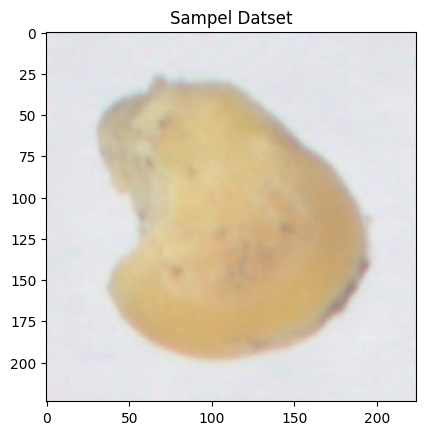

In [ ]:
dataset = write_cachedImg(args['dataset'])
print("x size = ",dataset['images'].size())
print("y size = ",dataset['class'].size())
gmbr = dataset['images'][0]
plt.title("Sampel Datset")
plt.imshow(gmbr.numpy())

### b. Melakukan Segmentasi

In [ ]:
dataset_segmentasi = segmentasi(dataset['images'])


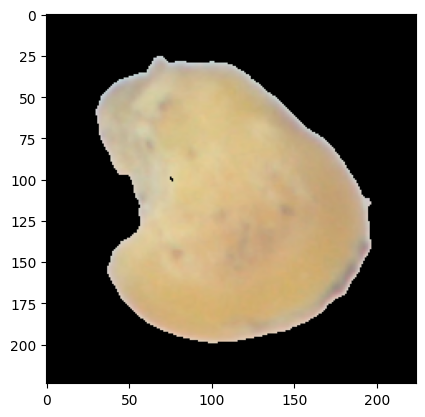

In [ ]:
gmbr = dataset_segmentasi[0]
plt.imshow(gmbr.numpy())

In [ ]:
print(dataset_segmentasi.size())

torch.Size([17801, 224, 224, 3])


In [ ]:
dataset_segmentasi = {'images':dataset_segmentasi,'class':dataset['class']}

In [ ]:
save_cachedImg(args['segmentasi']+"segmentasi.pkl",{'images':dataset_segmentasi,'class':dataset['class']})

berhasil menyimpan pkl drive/MyDrive/dataset/hasil_segmentasi/segmentasi.pkl


In [ ]:
dataset_segmentasi = write_cachedImg(args['segmentasi']+"segmentasi.pkl")

### c. Melakukan Oversampling

#### *1. Cek Ukuran Data

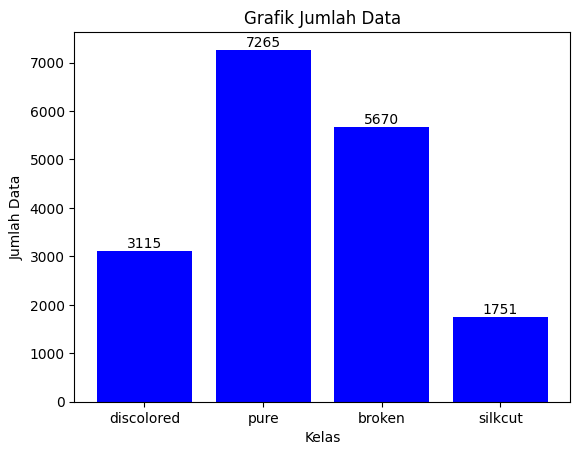

In [ ]:
n_data = [*get_n_data_class(dataset_segmentasi)]
classes = args['class']
plt.bar(classes, n_data, color='blue')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Data')
plt.title('Grafik Jumlah Data')
for i, value in enumerate(n_data):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom')

#### *2. Pisahkan Data Oversampling

In [ ]:
# select class
jumlah_class = torch.bincount(dataset['class'].int())
target =args['target_oversample']
class_selected_oversample = torch.nonzero(jumlah_class < target).squeeze()
class_selected = torch.nonzero(jumlah_class > target).squeeze()

data_oversample = {
    'images': dataset_segmentasi['images'][torch.isin(dataset['class'], class_selected_oversample)],
    'class': dataset['class'][torch.isin(dataset['class'], class_selected_oversample)]
}
data_non_oversample = {
    'images': dataset_segmentasi['images'][torch.isin(dataset['class'], class_selected)],
    'class': dataset['class'][torch.isin(dataset['class'], class_selected)]
}

In [ ]:
print(f"Jumlah Data pada Tiap Class (class-0, class-1, class-2, class-3) : {jumlah_class}")
print(f"Data Yang akan Di Oversampling (class-0, class-3) : {class_selected_oversample}")
print(f"Data Yang tidak Di Oversampling (class-1, class-2) : {class_selected}")

Jumlah Data pada Tiap Class (class-0, class-1, class-2, class-3) : tensor([3115, 7265, 5670, 1751])
Data Yang akan Di Oversampling (class-0, class-3) : tensor([0, 3])
Data Yang tidak Di Oversampling (class-1, class-2) : tensor([1, 2])


#### *3. Simpan Cache Image

In [ ]:
save_cachedImg(args['batch_oversample'], data_oversample)

berhasil menyimpan pkl drive/MyDrive/dataset/batch_img/data_oversample.pkl


In [ ]:
save_cachedImg(args['batch_non_oversample'], data_non_oversample)

berhasil menyimpan pkl drive/MyDrive/dataset/batch_img/data_non_oversample.pkl


In [ ]:
data_oversample = write_cachedImg(args['batch_oversample'])

#### *4. Melatih Encoder-Decoder

In [ ]:
encoder = Encoder()
decoder = Decoder()
deepsmote = DeepSMOTE(encoder, decoder)

In [ ]:
deepsmote.fit(data_oversample, 'cuda')

Epoch :1 Train Loss: 34.90486764786195 Rec Loss: 17.368733443775955 Penalty_loss: 17.53613427524664
Menyimpan Model ....
Epoch :2 Train Loss: 13.678130614514254 Rec Loss: 6.723597525181819 Penalty_loss: 6.954533124760705
Menyimpan Model ....
Epoch :3 Train Loss: 7.419474243813632 Rec Loss: 3.5735912974543718 Penalty_loss: 3.8458829615645262
Menyimpan Model ....
Epoch :4 Train Loss: 5.171881788543293 Rec Loss: 2.4883160326553853 Penalty_loss: 2.683565749577722
Menyimpan Model ....
Epoch :5 Train Loss: 4.147928632339653 Rec Loss: 2.031458589115313 Penalty_loss: 2.1164700546282895
Menyimpan Model ....
Epoch :6 Train Loss: 3.609836716737066 Rec Loss: 1.7893866760542199 Penalty_loss: 1.820450041291057
Menyimpan Model ....
Epoch :7 Train Loss: 3.2951816236790346 Rec Loss: 1.6237471937677082 Penalty_loss: 1.6714344052027683
Menyimpan Model ....
Epoch :8 Train Loss: 2.9653961640231463 Rec Loss: 1.475708944228839 Penalty_loss: 1.4896872305520334
Menyimpan Model ....
Epoch :9 Train Loss: 2.79100

#### Timer

In [ ]:
f'waktu yg di tempuh: {deepsmote.timer:.2f} menit'

'waktu yg di tempuh: 40.11 menit'

#### Evaluasi

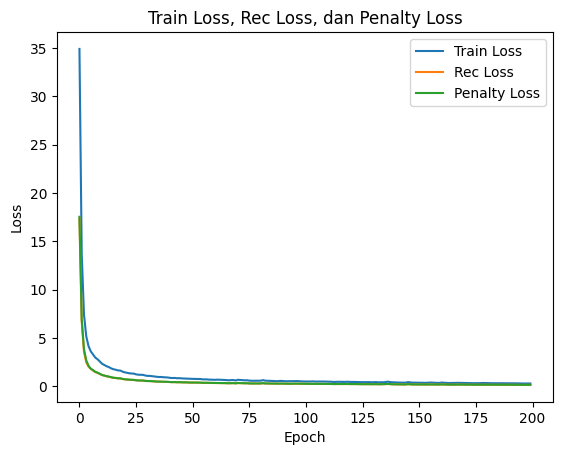

In [ ]:
# write_cachedImg(args['oversample']+"_perform.pkl")
performa=deepsmote.perform
plt.plot(performa['train_loss'], label='Train Loss')
plt.plot(performa['rec_loss'], label='Rec Loss')
plt.plot(performa['penalty_loss'], label='Penalty Loss')

# Menambahkan label dan judul plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss, Rec Loss, dan Penalty Loss')

# Menampilkan legenda
plt.legend()

# Menampilkan plot
plt.show()

#### *5. Generate Data

In [ ]:
deepsmote.preprocess(data_oversample)
deepsmote.generate_samples(1500, args['target_oversample'], 'cpu')

berhasil menyimpan pkl drive/MyDrive/dataset/hasil_oversampling/combine_oversampling.pkl
berhasil menyimpan pkl drive/MyDrive/dataset/hasil_oversampling/combine_oversampling_with_data.pkl
4.3992374142011


#### *6. Cek Ukuran Data

In [ ]:
data_after_oversample = write_cachedImg(args['hasil_oversampling']+"combine_oversampling_with_data.pkl")

In [ ]:
data_non_oversample = write_cachedImg(args['batch_non_oversample'])

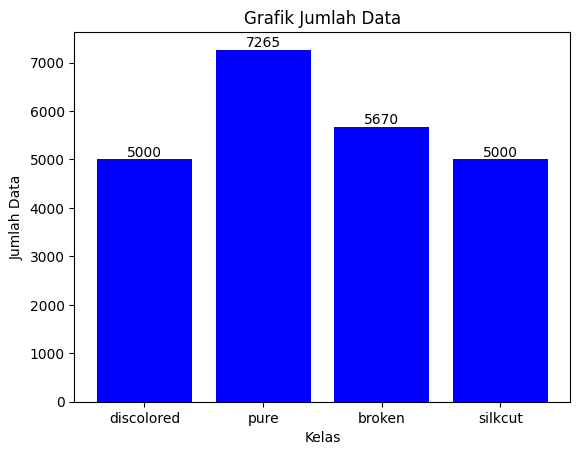

In [ ]:

n_data = [
    data_after_oversample['class'][data_after_oversample['class']==0].size(0),
    data_non_oversample['class'][data_non_oversample['class']==1].size(0),
    data_non_oversample['class'][data_non_oversample['class']==2].size(0),
    data_after_oversample['class'][data_after_oversample['class']==3].size(0)
]

classes = args['class']
plt.bar(classes, n_data, color='blue')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Data')
plt.title('Grafik Jumlah Data')
for i, value in enumerate(n_data):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom')

#### *7. Hasil Gambar Oversampling

In [ ]:
img_ds = write_cachedImg(args['data_hasil_oversampling'])

5134

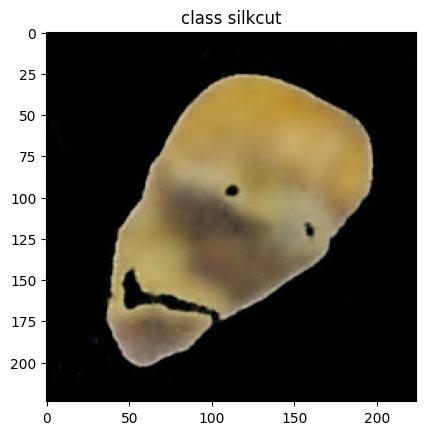

In [ ]:
gmbr = data_after_oversample['images'][0].to(torch.float32)
id=5000
gmbr = img_ds['images'][id].to(torch.float32)/255
plt.imshow(gmbr.numpy())
cls = img_ds['class'][id].numpy()
plt.title(f"class {args['class'][cls]}")
len(img_ds['images'])

#### *8. Undersampling

In [ ]:
classes = torch.unique(data_non_oversample['class'])
data_non_to_Balance = {}
data_x, data_y=[],[]
for cls in classes:
  img=data_non_oversample['images'][data_non_oversample['class']==cls][:5000]
  kelas=data_non_oversample['class'][data_non_oversample['class']==cls][:5000]
  data_x.append(img.to(torch.float16))
  data_y.append(kelas)
data_non_to_Balance={'images': torch.cat(data_x, dim=0),
                     'class': torch.cat(data_y, dim=0)}
save_cachedImg(args['downsample'],data_non_to_Balance)

berhasil menyimpan pkl drive/MyDrive/dataset/batch_img/data_downsampling.pkl


#### Menampilkan Ukuran Data

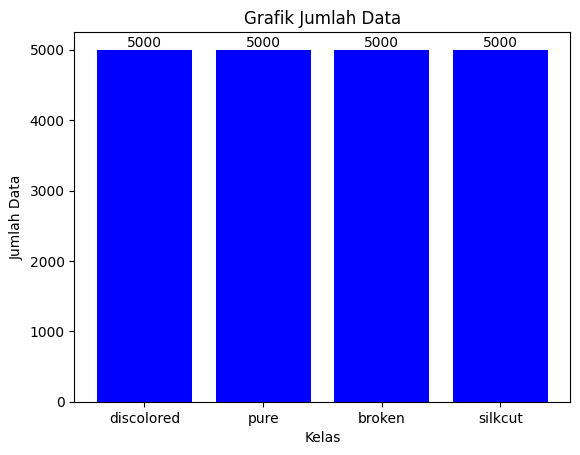

In [ ]:

n_data = [
    data_after_oversample['class'][data_after_oversample['class']==0].size(0),
    data_non_to_Balance['class'][data_non_to_Balance['class']==1].size(0),
    data_non_to_Balance['class'][data_non_to_Balance['class']==2].size(0),
    data_after_oversample['class'][data_after_oversample['class']==3].size(0)
]

classes = args['class']
plt.bar(classes, n_data, color='blue')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Data')
plt.title('Grafik Jumlah Data')
for i, value in enumerate(n_data):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom')

#### *9.Penggabungan data Balance

In [ ]:
data_non_to_Balance = write_cachedImg(args['downsample'])

In [ ]:
data_ready = {
    'images':torch.cat([data_after_oversample['images'], data_non_to_Balance['images']], dim=0),
    'class':torch.cat([data_after_oversample['class'], data_non_to_Balance['class']], dim=0)

}
save_cachedImg(args['ready'],data_ready)
print("ukuran data saat ini:",data_ready['class'].size(0))

berhasil menyimpan pkl drive/MyDrive/dataset/batch_img/data_ready.pkl
ukuran data saat ini: 20000


In [ ]:
print("data_x :",data_ready['images'].size())
print("tipe data_x :",data_ready['images'].dtype)
print("data_y :",data_ready['class'].size())
print("tipe data_y :",data_ready['class'].dtype)

data_x : torch.Size([20000, 224, 224, 3])
tipe data_x : torch.float16
data_y : torch.Size([20000])
tipe data_y : torch.int64


In [ ]:
data_ready  = write_cachedImg(args['ready'])

### d. Melakukan Classification

#### *1. Pembagian Data

#### a. Membagi Data Training dan Testing

In [ ]:
data_x, data_y = data_ready['images'], data_ready['class']
X_train, X_test, y_train, y_test = splitting_data(data_x, data_y, 0.2)

In [ ]:
data_x, data_y = data_ready['images'], data_ready['class']
X_train, X_test, y_train, y_test = splitting_data(data_x, data_y, 0.2)
data_train = {'images':X_train, 'class': y_train}
data_test = {'images':X_test, 'class': y_test }
save_cachedImg(args['training'], data_train)
save_cachedImg(args['testing'], data_test)
print("size of train :", X_train.size(), y_train.size())
print("size of test :", X_test.size(), y_test.size())

berhasil menyimpan pkl drive/MyDrive/dataset/batch_img/data_training.pkl
berhasil menyimpan pkl drive/MyDrive/dataset/batch_img/data_testing.pkl
size of train : torch.Size([16000, 224, 224, 3]) torch.Size([16000])
size of test : torch.Size([4000, 224, 224, 3]) torch.Size([4000])


In [ ]:
data_train = write_cachedImg(args['training'])

In [ ]:
data_test = write_cachedImg(args['testing'])

#### *2. Melihat Persebaran Data

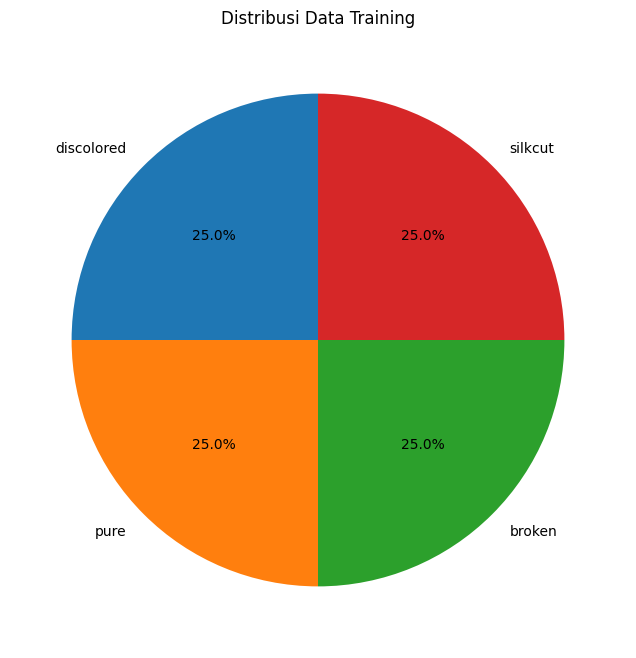

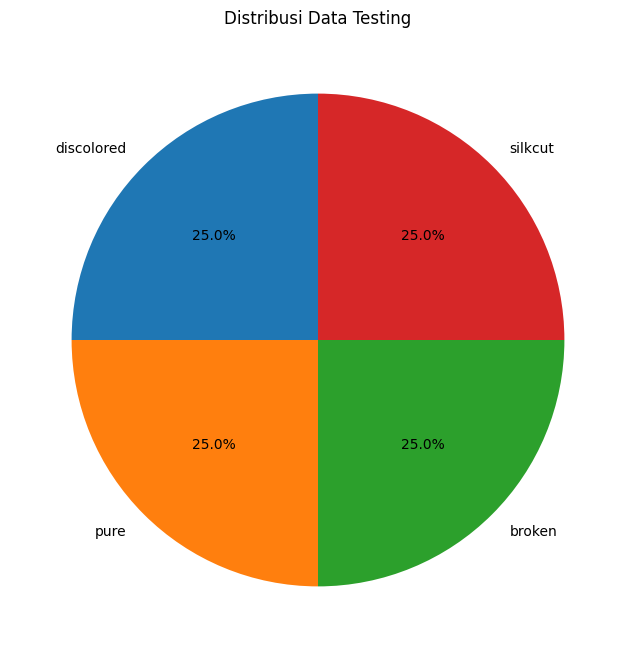

In [ ]:
y_train_numpy = y_train.numpy()
y_test_numpy = y_train.numpy()

# Visualisasi persebaran kelas menggunakan diagram pie
plt.figure(figsize=(8, 8))
plt.pie(np.bincount(y_train_numpy), labels=args['class'], autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Data Training')
plt.show()
plt.figure(figsize=(8, 8))
plt.pie(np.bincount(y_test_numpy), labels=args['class'], autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Data Testing')
plt.show()

#### *3.Pembagian KFOLD

In [ ]:
data_train = write_cachedImg(args['training'])
kfold_splitting(data_train['images'],data_train['class'], 5)

### Skenario 1

#### Training - Val Fold ke-1

In [ ]:
k=0
data_train, data_val = write_cachedImg(args['train_val']+f"train_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_fold_{k}.pkl")
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([12800, 224, 224, 3])
Validation size torch.Size([3200, 224, 224, 3])


In [ ]:
model = EfficientNetClassification("b0")
sistem = Classification(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 435MB/s]


Loaded pretrained weights for efficientnet-b0
fold ke-0
Epoch : 1 train loss : 0.8552759443223477 train acc : 0.6415625 val loss : 0.8109029993414879 val acc : 0.6828125 
Menyimpan Model
Epoch : 2 train loss : 0.608277615532279 train acc : 0.753359375 val loss : 0.6177288608253002 val acc : 0.763125 
Menyimpan Model
Epoch : 3 train loss : 0.4946631063520908 train acc : 0.805625 val loss : 0.6435261507332325 val acc : 0.763125 
Menyimpan Model
Epoch : 4 train loss : 0.40465494472533464 train acc : 0.842890625 val loss : 0.7318280959129333 val acc : 0.7596875 
Menyimpan Model
Epoch : 5 train loss : 0.33501575456932187 train acc : 0.87453125 val loss : 0.8096207278221845 val acc : 0.7690625 
Menyimpan Model
Epoch : 6 train loss : 0.2745907082594931 train acc : 0.898671875 val loss : 1.051563150882721 val acc : 0.749375 
Menyimpan Model
Epoch : 7 train loss : 0.22334741584490986 train acc : 0.917890625 val loss : 0.9881277504563332 val acc : 0.76375 
Menyimpan Model
Epoch : 8 train loss : 

#### Training - Val Fold ke-2

In [ ]:
k=1
data_train, data_val = write_cachedImg(args['train_val']+f"train_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_fold_{k}.pkl")
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([12800, 224, 224, 3])
Validation size torch.Size([3200, 224, 224, 3])


In [ ]:
model = EfficientNetClassification("b0")
sistem = Classification(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Loaded pretrained weights for efficientnet-b0
fold ke-1
Epoch : 1 train loss : 0.842912199869752 train acc : 0.654609375 val loss : 0.7255345553159713 val acc : 0.705625 
Menyimpan Model
Epoch : 2 train loss : 0.6069158796221018 train acc : 0.75671875 val loss : 0.7072852098941803 val acc : 0.7265625 
Menyimpan Model
Epoch : 3 train loss : 0.49924581926316025 train acc : 0.80421875 val loss : 0.7261504340171814 val acc : 0.751875 
Menyimpan Model
Epoch : 4 train loss : 0.4055715289339423 train acc : 0.84140625 val loss : 0.7352608346939087 val acc : 0.758125 
Menyimpan Model
Epoch : 5 train loss : 0.3384069586545229 train acc : 0.8725 val loss : 0.8527116629481316 val acc : 0.7546875 
Menyimpan Model
Epoch : 6 train loss : 0.2697963920328766 train acc : 0.897109375 val loss : 0.920182932280004 val acc : 0.7546875 
Menyimpan Model
Epoch : 7 train loss : 0.22358307860558851 train acc : 0.915859375 val loss : 1.064901970922947 val acc : 0.7509375 
Menyimpan Model
Epoch : 8 train loss : 0.

#### Training - Val Fold ke-3

In [ ]:
k=2
data_train, data_val = write_cachedImg(args['train_val']+f"train_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_fold_{k}.pkl")
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([12800, 224, 224, 3])
Validation size torch.Size([3200, 224, 224, 3])


In [ ]:
model = EfficientNetClassification("b0")
sistem = Classification(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Loaded pretrained weights for efficientnet-b0
fold ke-2
Epoch : 1 train loss : 0.848589077219367 train acc : 0.645625 val loss : 0.6867541360855103 val acc : 0.7278125 
Menyimpan Model
Epoch : 2 train loss : 0.6108076146245003 train acc : 0.7528125 val loss : 0.678401612341404 val acc : 0.7428125 
Menyimpan Model
Epoch : 3 train loss : 0.5045196081697941 train acc : 0.79875 val loss : 0.610844384431839 val acc : 0.771875 
Menyimpan Model
Epoch : 4 train loss : 0.4073288773559034 train acc : 0.84296875 val loss : 0.6704883414506912 val acc : 0.779375 
Menyimpan Model
Epoch : 5 train loss : 0.33689435694366693 train acc : 0.869609375 val loss : 0.7724698500335216 val acc : 0.770625 
Menyimpan Model
Epoch : 6 train loss : 0.2679207680746913 train acc : 0.90046875 val loss : 0.8934893661737442 val acc : 0.77125 
Menyimpan Model
Epoch : 7 train loss : 0.22685907791368665 train acc : 0.915703125 val loss : 1.0521830305457116 val acc : 0.765625 
Menyimpan Model
Epoch : 8 train loss : 0.185853

#### Training - Val Fold ke-4

In [ ]:
k=3
data_train, data_val = write_cachedImg(args['train_val']+f"train_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_fold_{k}.pkl")
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([12800, 224, 224, 3])
Validation size torch.Size([3200, 224, 224, 3])


In [ ]:
model = EfficientNetClassification("b0")
sistem = Classification(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:02<00:00, 9.65MB/s]


Loaded pretrained weights for efficientnet-b0
fold ke-3
Epoch : 1 train loss : 0.8657605703920126 train acc : 0.643046875 val loss : 0.76407516092062 val acc : 0.6859375 
Menyimpan Model
Epoch : 2 train loss : 0.6170114993304014 train acc : 0.752265625 val loss : 0.6346900747716426 val acc : 0.7590625 
Menyimpan Model
Epoch : 3 train loss : 0.5027209949493409 train acc : 0.804140625 val loss : 0.7298735851049423 val acc : 0.7540625 
Menyimpan Model
Epoch : 4 train loss : 0.4168565195798874 train acc : 0.83734375 val loss : 0.6762671759724617 val acc : 0.7659375 
Menyimpan Model
Epoch : 5 train loss : 0.343100488204509 train acc : 0.87078125 val loss : 0.8016207553446293 val acc : 0.7578125 
Menyimpan Model
Epoch : 6 train loss : 0.284093140847981 train acc : 0.89296875 val loss : 0.936774885058403 val acc : 0.766875 
Menyimpan Model
Epoch : 7 train loss : 0.22428434817120432 train acc : 0.9171875 val loss : 0.9930968347191811 val acc : 0.7596875 
Menyimpan Model
Epoch : 8 train loss : 

#### Training - Val Fold ke-5

In [ ]:
k=4
data_train, data_val = write_cachedImg(args['train_val']+f"train_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_fold_{k}.pkl")
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([12800, 224, 224, 3])
Validation size torch.Size([3200, 224, 224, 3])


In [ ]:
model = EfficientNetClassification("b0")
sistem = Classification(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Loaded pretrained weights for efficientnet-b0
fold ke-4
Epoch : 1 train loss : 0.8554630964994431 train acc : 0.641015625 val loss : 0.861789076924324 val acc : 0.6628125 
Menyimpan Model
Epoch : 2 train loss : 0.6031918398290873 train acc : 0.758984375 val loss : 0.6658597278594971 val acc : 0.7446875 
Menyimpan Model
Epoch : 3 train loss : 0.4953883014805615 train acc : 0.80796875 val loss : 0.7151830711960793 val acc : 0.7459375 
Menyimpan Model
Epoch : 4 train loss : 0.41304515091702343 train acc : 0.84015625 val loss : 0.7417165634036064 val acc : 0.7603125 
Menyimpan Model
Epoch : 5 train loss : 0.33149328590370714 train acc : 0.875390625 val loss : 0.8214725413918496 val acc : 0.76 
Menyimpan Model
Epoch : 6 train loss : 0.2628738944418728 train acc : 0.904609375 val loss : 0.8960222332179546 val acc : 0.7625 
Menyimpan Model
Epoch : 7 train loss : 0.21912786070723086 train acc : 0.919140625 val loss : 1.1059701293706894 val acc : 0.755625 
Menyimpan Model
Epoch : 8 train loss :

#### Memilih Model Terbaik

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 209MB/s]


Loaded pretrained weights for efficientnet-b0
fold ke-0


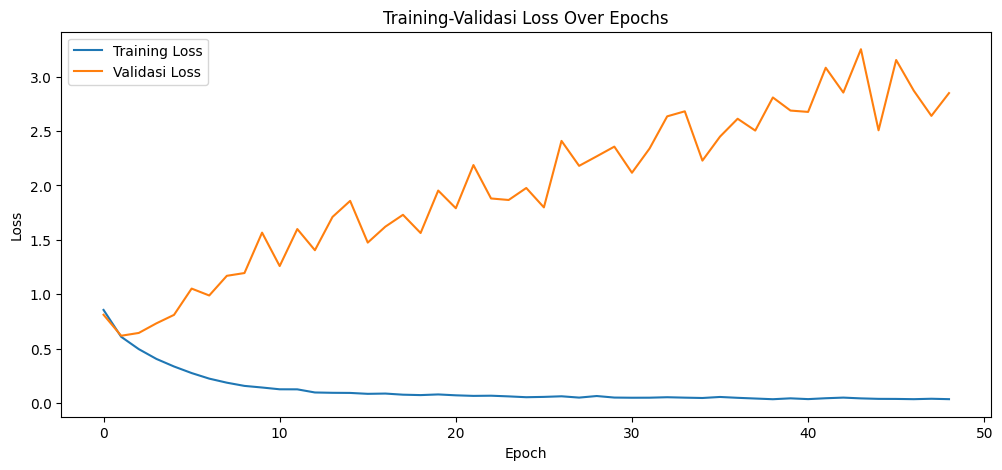

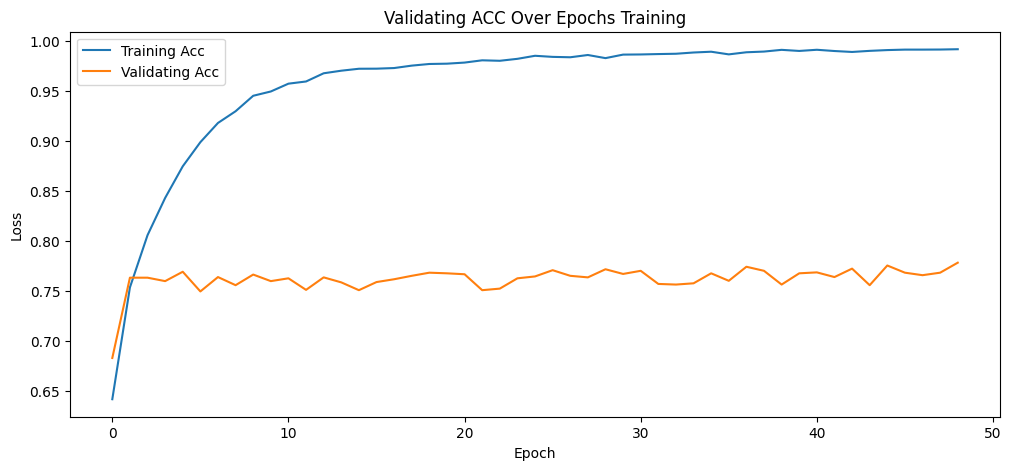

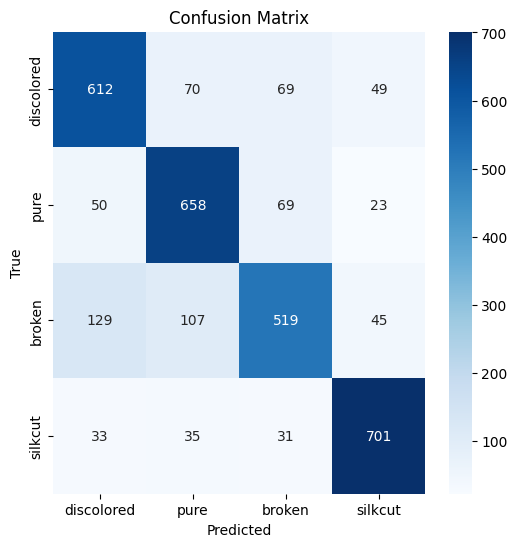

Waktu : 79.43487624724706
Loss : 2.849785007238388
Accuracy : 0.778125
Precision : 0.7775922417640686
Recall : 0.7781250029802322
F1-score : 0.7764502614736557
fold ke-1


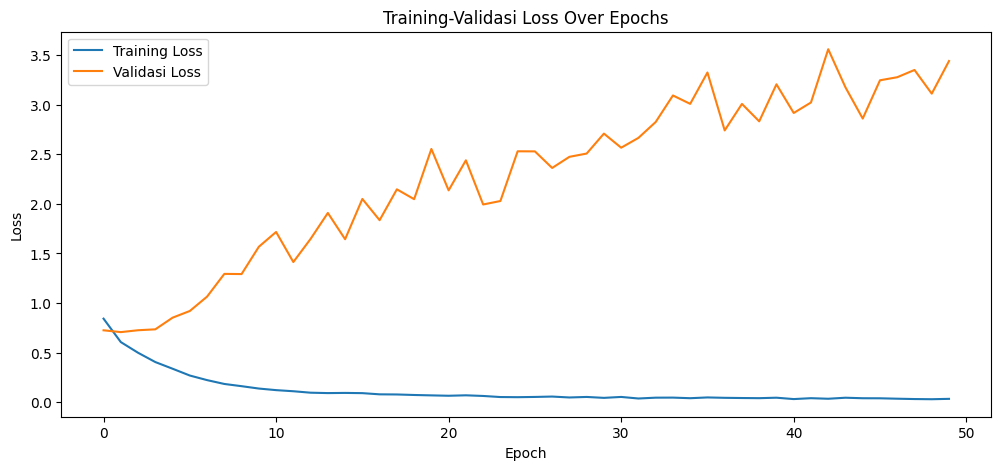

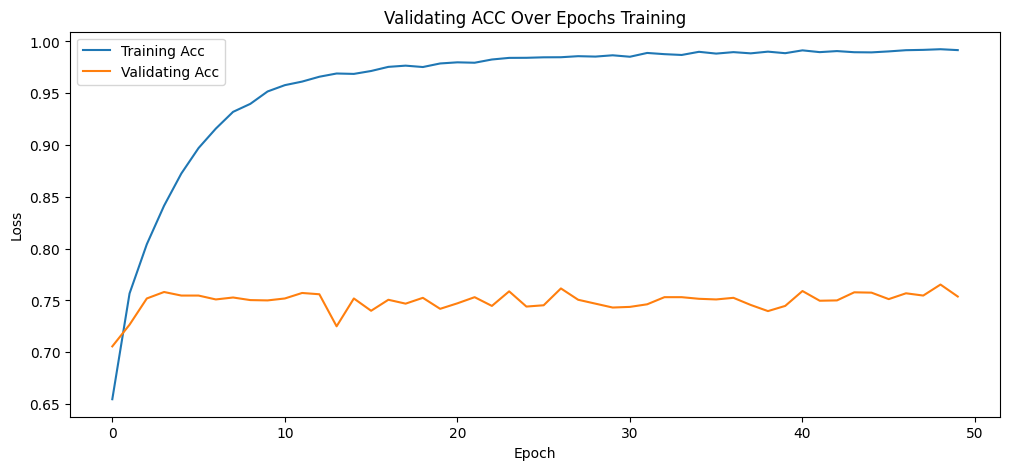

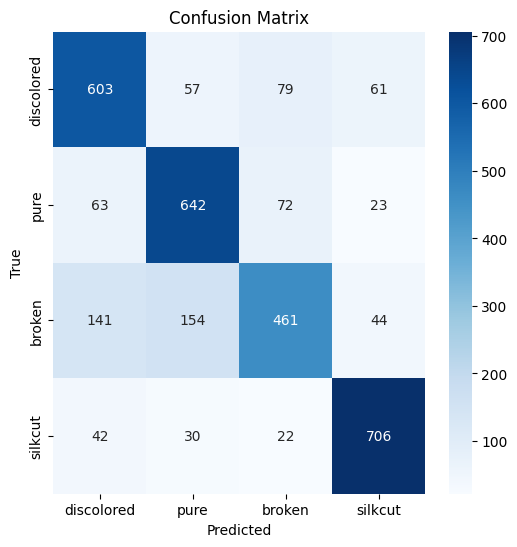

Waktu : 81.26808652083079
Loss : 3.438725484609604
Accuracy : 0.75375
Precision : 0.7527415752410889
Recall : 0.7537500113248825
F1-score : 0.7503423988819122
fold ke-2


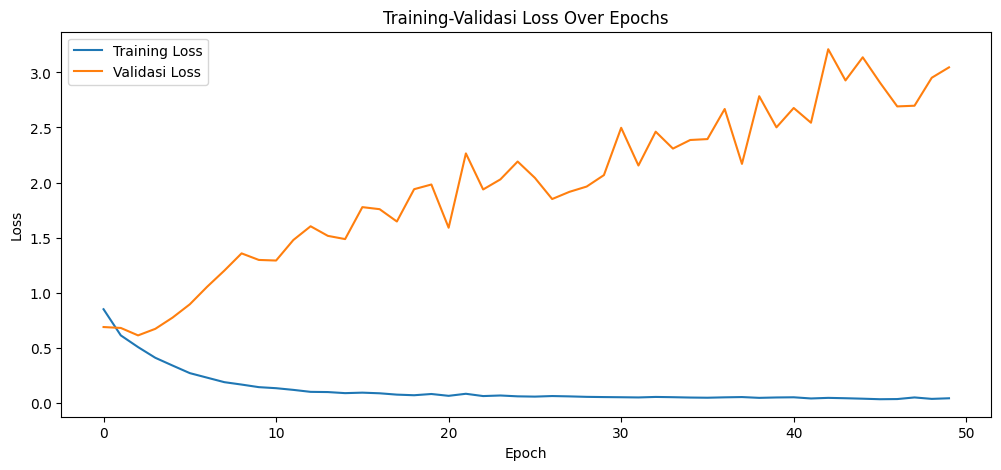

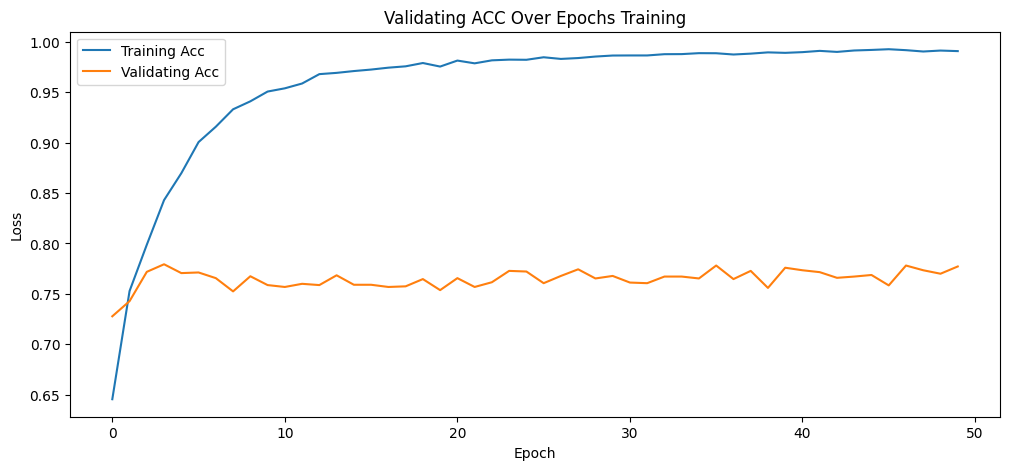

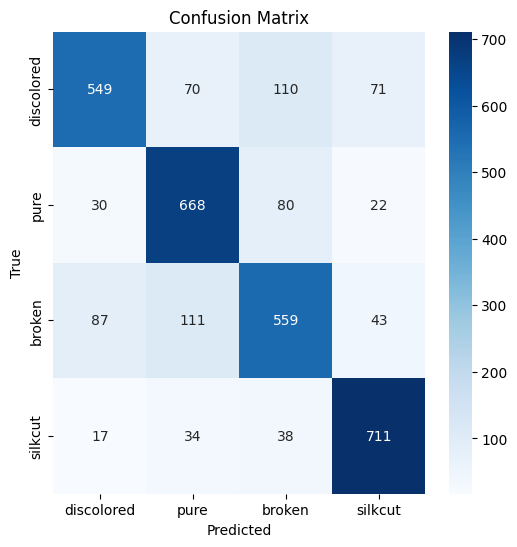

Waktu : 81.87209224303564
Loss : 3.0463466012477873
Accuracy : 0.7771875
Precision : 0.7775110304355621
Recall : 0.7771874964237213
F1-score : 0.7755183577537537
fold ke-3


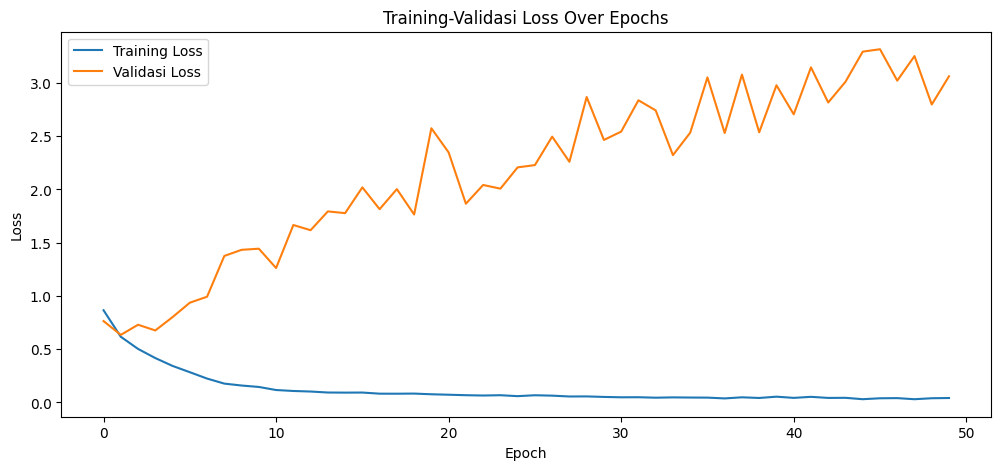

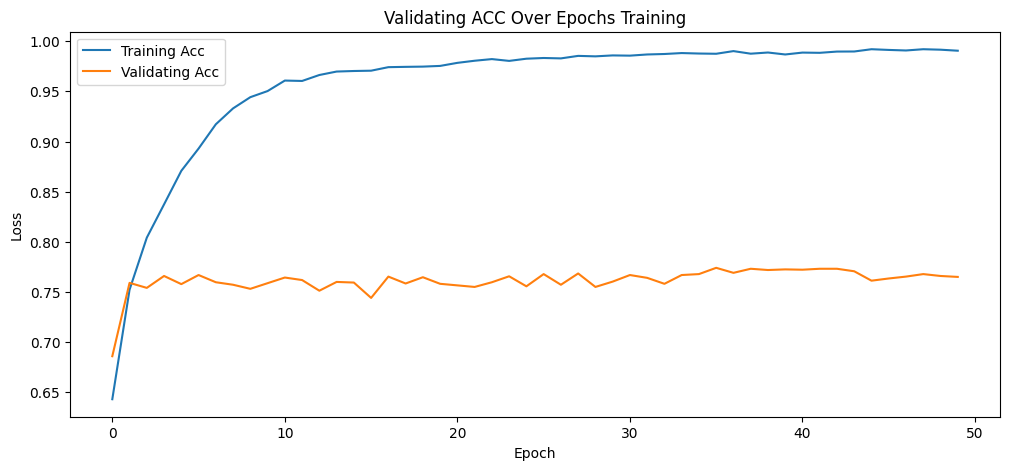

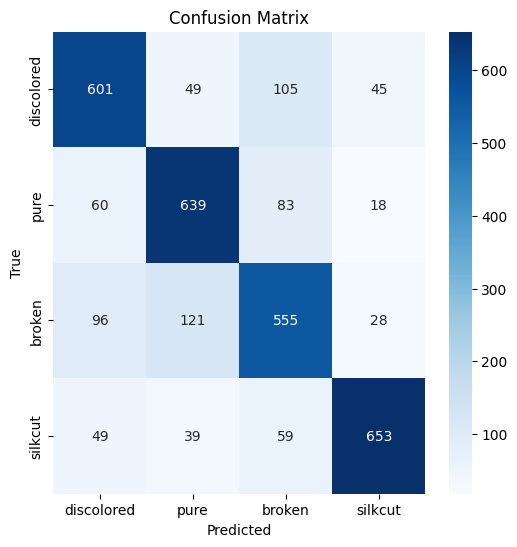

Waktu : 80.15346165498097
Loss : 3.0631906569004057
Accuracy : 0.765
Precision : 0.7672258466482162
Recall : 0.7650000154972076
F1-score : 0.7656668871641159
fold ke-4


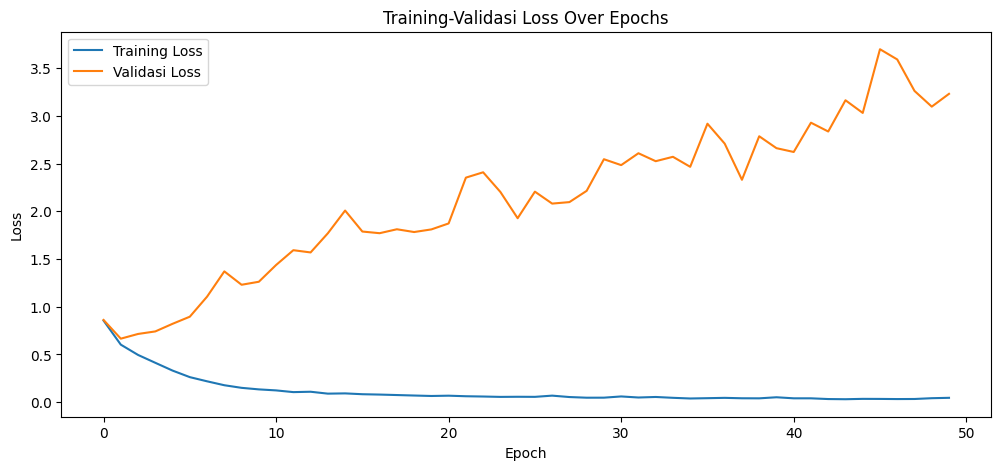

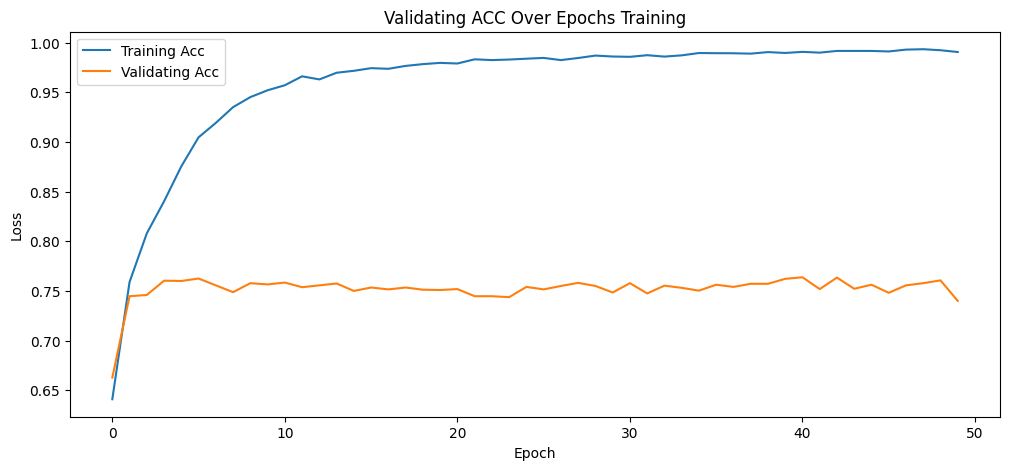

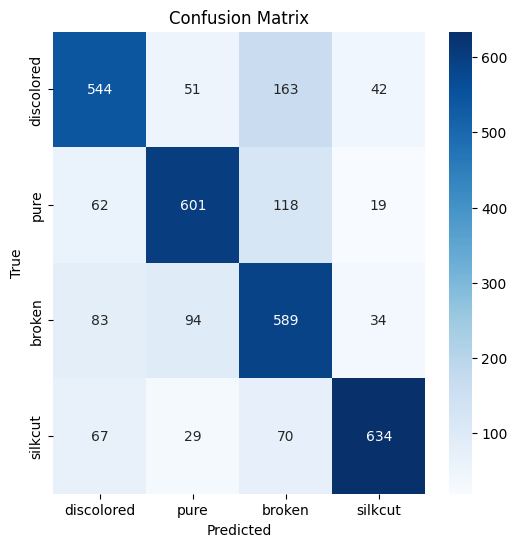

Waktu : 80.08533710241318
Loss : 3.230079288482666
Accuracy : 0.74
Precision : 0.7478352040052414
Recall : 0.7400000095367432
F1-score : 0.7421787977218628
Model Terbaik adalah model pada fold ke-0


In [ ]:
model = EfficientNetClassification("b0")
sistem = Classification(model,50)
sistem.can_predict()

#### Testing

In [ ]:
data_test = write_cachedImg(args['testing'])
x_test, y_test = data_test['images'].to(torch.float32), data_test['class']
print("Testing size", x_test.size())

Testing size torch.Size([4000, 224, 224, 3])


Hasil Testing


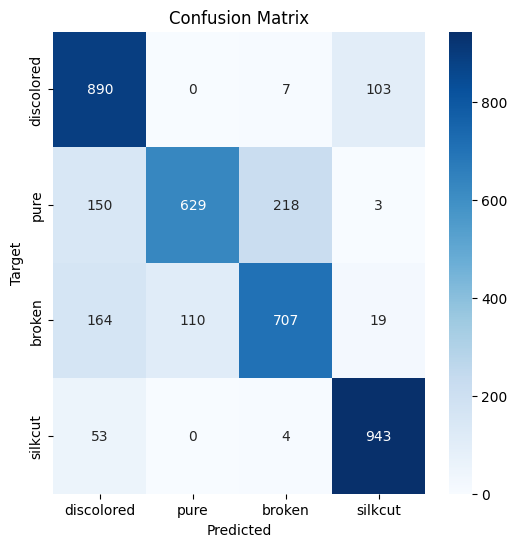

Loss : 2.4747375499010085
Accuracy : 0.79225
Precision : 0.7993714809417725
Recall : 0.792250007390976
F1-score : 0.7886065244674683


In [ ]:
sistem.predict(x_test, y_test, 'cpu')

### Skenario 2

#### Training - Val Fold ke-1

In [ ]:
k=0
data_train, data_val = write_cachedImg(args['train_val']+f"train_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_fold_{k}.pkl")


In [ ]:
data_train['images'], data_val['images'] = Resize(data_train['images'], (240,240)), Resize(data_val['images'], (240,240))
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([12800, 240, 240, 3])
Validation size torch.Size([3200, 240, 240, 3])


In [ ]:
model = EfficientNetClassification("b1")
sistem = Classification(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 57.8MB/s]


Loaded pretrained weights for efficientnet-b1
fold ke-0
Epoch : 1 train loss : 0.8899772411584854 train acc : 0.628203125 val loss : 1.4882410490512847 val acc : 0.2725 
Menyimpan Model
Epoch : 2 train loss : 0.675622077062726 train acc : 0.726640625 val loss : 0.8555948451161385 val acc : 0.686875 
Menyimpan Model
Epoch : 3 train loss : 0.568327219709754 train acc : 0.77921875 val loss : 0.7959182637929917 val acc : 0.7403125 
Menyimpan Model
Epoch : 4 train loss : 0.48950810346752405 train acc : 0.810859375 val loss : 0.9492042852938175 val acc : 0.734375 
Menyimpan Model
Epoch : 5 train loss : 0.41385062884539364 train acc : 0.84484375 val loss : 1.0252772210538388 val acc : 0.7484375 
Menyimpan Model
Epoch : 6 train loss : 0.3447929520439357 train acc : 0.872109375 val loss : 1.2811493155360223 val acc : 0.7259375 
Menyimpan Model
Epoch : 7 train loss : 0.2938648354075849 train acc : 0.892734375 val loss : 1.6524565458297729 val acc : 0.7196875 
Menyimpan Model
Epoch : 8 train loss

#### Training - Val Fold ke-2

In [ ]:
k=1
data_train, data_val = write_cachedImg(args['train_val']+f"train_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_fold_{k}.pkl")
data_train['images'], data_val['images'] = Resize(data_train['images'], (240,240)), Resize(data_val['images'], (240,240))
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([12800, 240, 240, 3])
Validation size torch.Size([3200, 240, 240, 3])


In [ ]:
model = EfficientNetClassification("b1")
sistem = Classification(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")


Loaded pretrained weights for efficientnet-b1
fold ke-1
Epoch : 1 train loss : 0.8896858786791563 train acc : 0.628203125 val loss : 1.571958419084549 val acc : 0.254375 
Menyimpan Model
Epoch : 2 train loss : 0.6665386109054089 train acc : 0.7328125 val loss : 0.9212219434976577 val acc : 0.6775 
Menyimpan Model
Epoch : 3 train loss : 0.5586312226578594 train acc : 0.781640625 val loss : 1.0039399856328963 val acc : 0.715625 
Menyimpan Model
Epoch : 4 train loss : 0.469414480663836 train acc : 0.8184375 val loss : 1.019592974483967 val acc : 0.728125 
Menyimpan Model
Epoch : 5 train loss : 0.40276087848469616 train acc : 0.85 val loss : 1.3217316710948943 val acc : 0.695625 
Menyimpan Model
Epoch : 6 train loss : 0.33167939546518027 train acc : 0.878359375 val loss : 1.3094714936614036 val acc : 0.7284375 
Menyimpan Model
Epoch : 7 train loss : 0.27865374062210324 train acc : 0.90125 val loss : 1.405320299565792 val acc : 0.73625 
Menyimpan Model
Epoch : 8 train loss : 0.2472935259435

#### Training - Val Fold ke-3

In [ ]:
k=2
data_train, data_val = write_cachedImg(args['train_val']+f"train_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_fold_{k}.pkl")
data_train['images'], data_val['images'] = Resize(data_train['images'], (240,240)), Resize(data_val['images'], (240,240))
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([12800, 240, 240, 3])
Validation size torch.Size([3200, 240, 240, 3])


In [ ]:
model = EfficientNetClassification("b1")
sistem = Classification(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 192MB/s] 


Loaded pretrained weights for efficientnet-b1
fold ke-2
Epoch : 1 train loss : 0.889629827439785 train acc : 0.623515625 val loss : 1.587616547346115 val acc : 0.2746875 
Menyimpan Model
Epoch : 2 train loss : 0.6638969477266073 train acc : 0.73140625 val loss : 0.8912746280431747 val acc : 0.6778125 
Menyimpan Model
Epoch : 3 train loss : 0.565596801713109 train acc : 0.779296875 val loss : 0.7248826923966408 val acc : 0.7553125 
Menyimpan Model
Epoch : 4 train loss : 0.48133958123624326 train acc : 0.81171875 val loss : 0.8861989605426789 val acc : 0.74625 
Menyimpan Model
Epoch : 5 train loss : 0.41013690948486325 train acc : 0.8478125 val loss : 1.0239810684323312 val acc : 0.733125 
Menyimpan Model
Epoch : 6 train loss : 0.3517709776572883 train acc : 0.86484375 val loss : 1.070667039602995 val acc : 0.7409375 
Menyimpan Model
Epoch : 7 train loss : 0.28538075372576716 train acc : 0.895078125 val loss : 1.3922517690062524 val acc : 0.7365625 
Menyimpan Model
Epoch : 8 train loss :

#### Training - Val Fold ke-4

In [ ]:
k=3
data_train, data_val = write_cachedImg(args['train_val']+f"train_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_fold_{k}.pkl")
data_train['images'], data_val['images'] = Resize(data_train['images'], (240,240)), Resize(data_val['images'], (240,240))
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([12800, 240, 240, 3])
Validation size torch.Size([3200, 240, 240, 3])


In [ ]:
model = EfficientNetClassification("b1")
sistem = Classification(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")


Loaded pretrained weights for efficientnet-b1
fold ke-3
Epoch : 1 train loss : 0.886083557009697 train acc : 0.624609375 val loss : 1.4399804258346558 val acc : 0.26125 
Menyimpan Model
Epoch : 2 train loss : 0.6636897920072079 train acc : 0.73359375 val loss : 1.1271765142679215 val acc : 0.64625 
Menyimpan Model
Epoch : 3 train loss : 0.564995834901929 train acc : 0.77359375 val loss : 0.8772123974561691 val acc : 0.7309375 
Menyimpan Model
Epoch : 4 train loss : 0.48172918278723953 train acc : 0.813125 val loss : 1.0456512692570685 val acc : 0.724375 
Menyimpan Model
Epoch : 5 train loss : 0.40689379185438157 train acc : 0.845390625 val loss : 1.1300296539068222 val acc : 0.73625 
Menyimpan Model
Epoch : 6 train loss : 0.33540632790885866 train acc : 0.874453125 val loss : 1.4254524990916253 val acc : 0.7315625 
Menyimpan Model
Epoch : 7 train loss : 0.2945905817858875 train acc : 0.893671875 val loss : 1.6671824818849563 val acc : 0.723125 
Menyimpan Model
Epoch : 8 train loss : 0.

#### Training - Val Fold ke-5

In [ ]:
k=4
data_train, data_val = write_cachedImg(args['train_val']+f"train_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_fold_{k}.pkl")
data_train['images'], data_val['images'] = Resize(data_train['images'], (240,240)), Resize(data_val['images'], (240,240))
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([12800, 240, 240, 3])
Validation size torch.Size([3200, 240, 240, 3])


In [ ]:
model = EfficientNetClassification("b1")
sistem = Classification(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")


Loaded pretrained weights for efficientnet-b1
fold ke-4
Epoch : 1 train loss : 0.8974794635176658 train acc : 0.622890625 val loss : 1.4584401178359985 val acc : 0.2771875 
Menyimpan Model
Epoch : 2 train loss : 0.6739492662250995 train acc : 0.728828125 val loss : 0.9729315873980522 val acc : 0.6871875 
Menyimpan Model
Epoch : 3 train loss : 0.5742050568759441 train acc : 0.77140625 val loss : 0.8039947691559791 val acc : 0.7353125 
Menyimpan Model
Epoch : 4 train loss : 0.4887278029322624 train acc : 0.808671875 val loss : 0.9691884630918502 val acc : 0.735625 
Menyimpan Model
Epoch : 5 train loss : 0.43168905675411223 train acc : 0.834921875 val loss : 1.356939291357994 val acc : 0.7271875 
Menyimpan Model
Epoch : 6 train loss : 0.3610681575909257 train acc : 0.86328125 val loss : 1.5452471312880516 val acc : 0.7215625 
Menyimpan Model
Epoch : 7 train loss : 0.2991636642254889 train acc : 0.8915625 val loss : 1.3306776279211043 val acc : 0.7403125 
Menyimpan Model
Epoch : 8 train lo

#### Memilih Model Terbaik

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 267MB/s]


Loaded pretrained weights for efficientnet-b1
fold ke-0


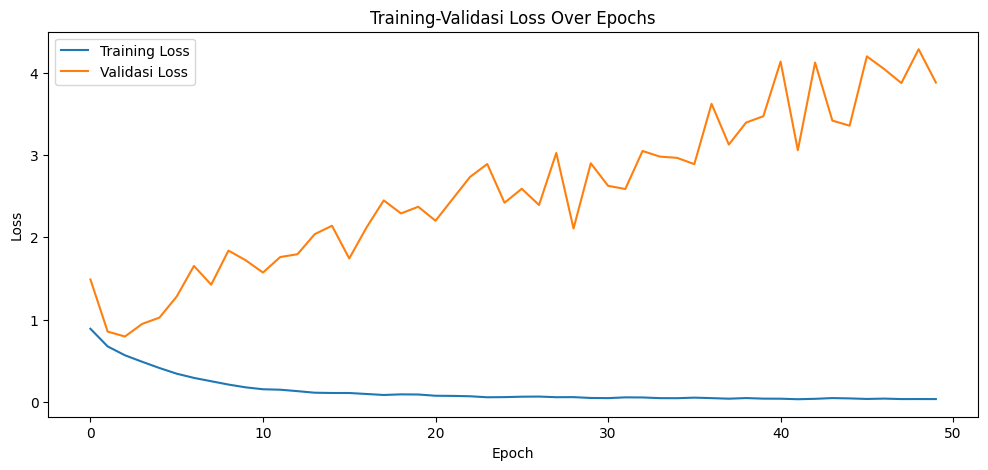

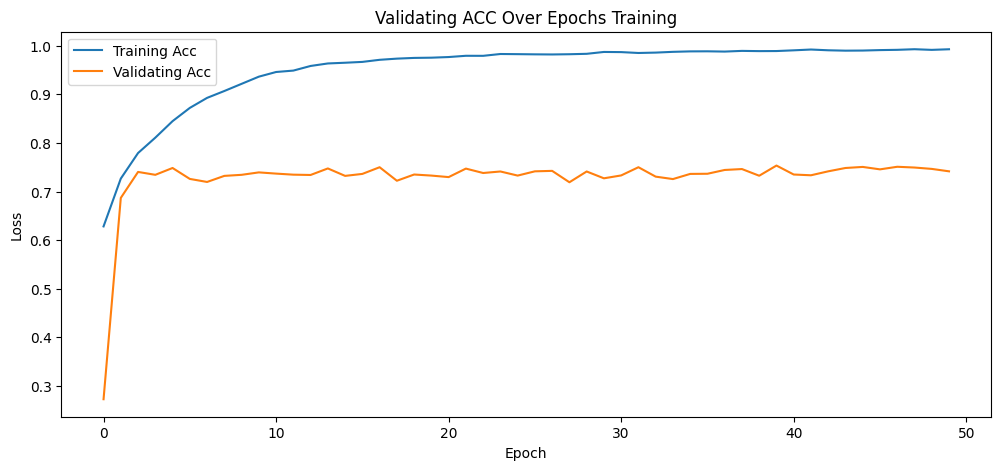

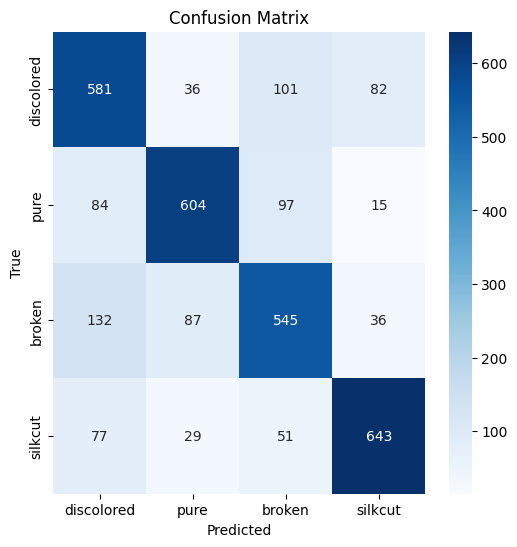

Waktu : 130.43249453306197
Loss : 3.8784080052375796
Accuracy : 0.7415625
Precision : 0.744676947593689
Recall : 0.7415624856948853
F1-score : 0.7425748556852341
fold ke-1


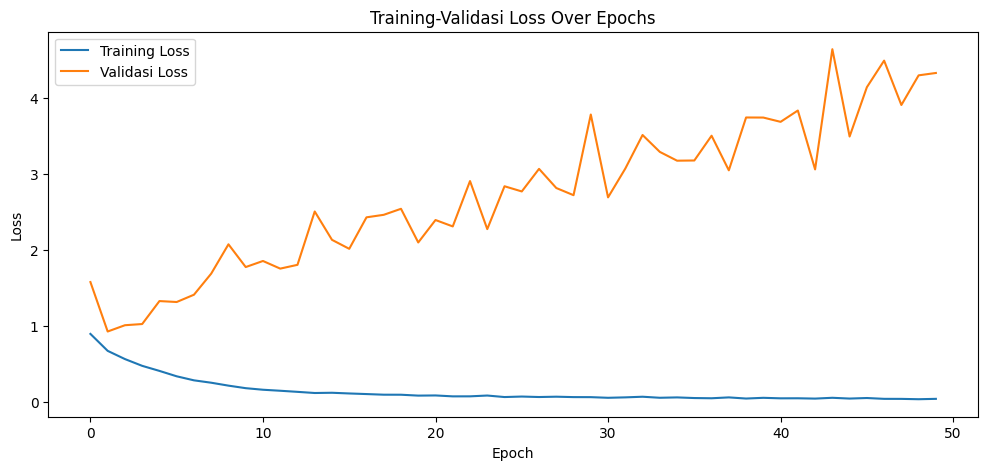

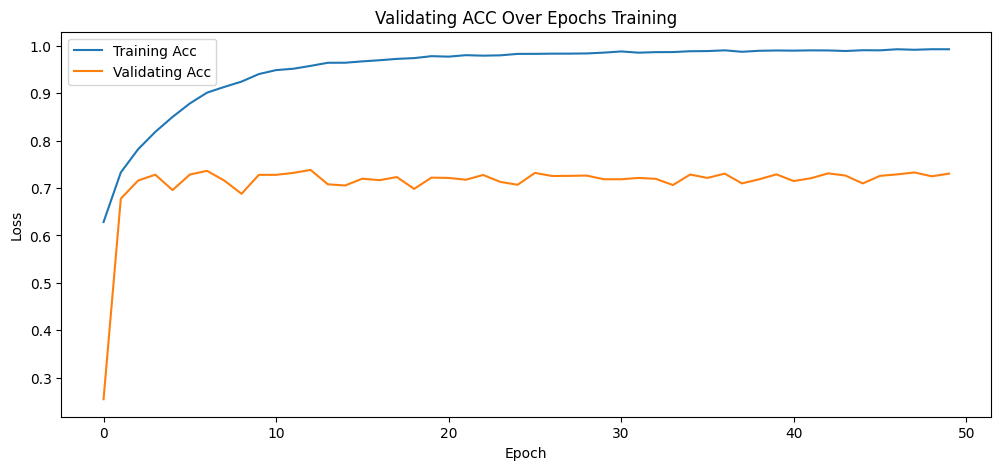

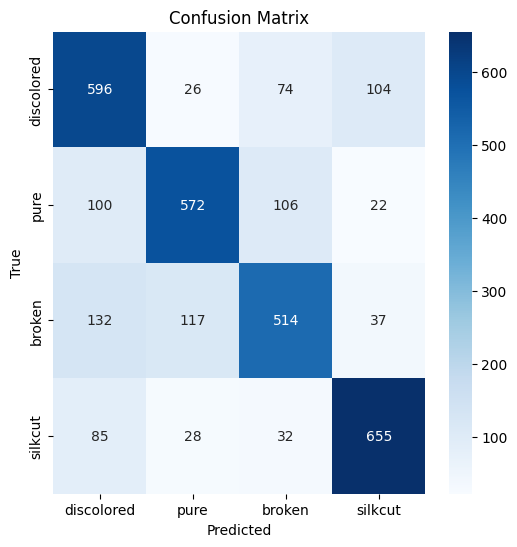

Waktu : 130.68319825728733
Loss : 4.323503886088729
Accuracy : 0.7303125
Precision : 0.7328418493270874
Recall : 0.7303124964237213
F1-score : 0.7301415801048279
fold ke-2


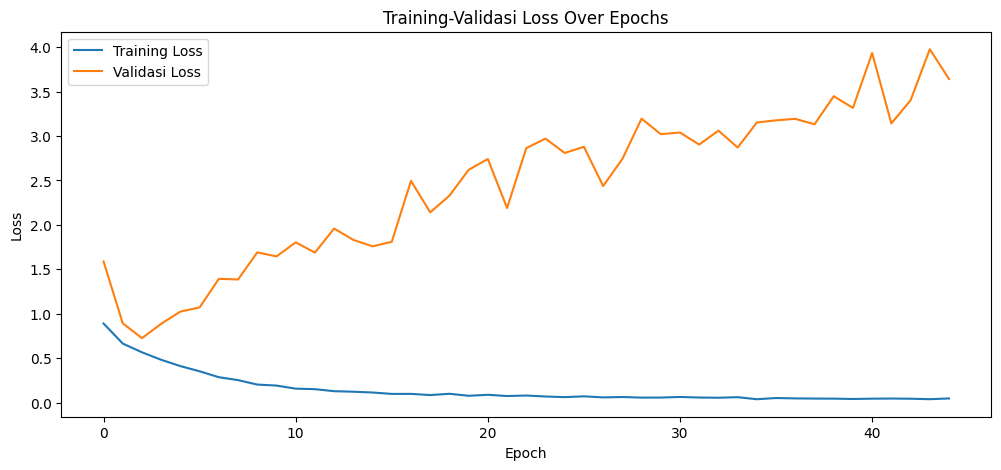

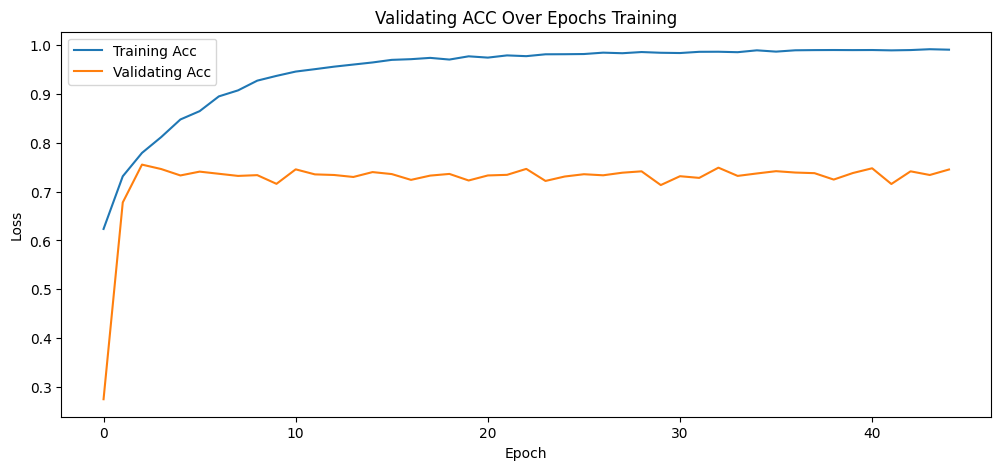

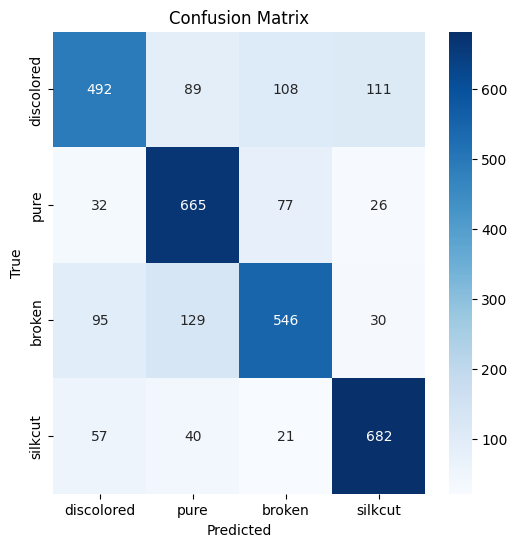

Waktu : 120.2359297712644
Loss : 3.6410528856515882
Accuracy : 0.7453125
Precision : 0.744412288069725
Recall : 0.745312511920929
F1-score : 0.7423381060361862
fold ke-3


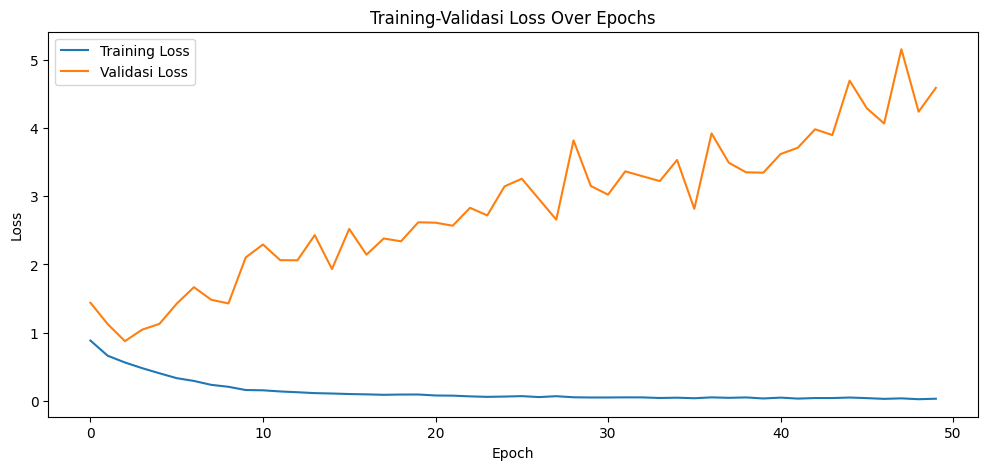

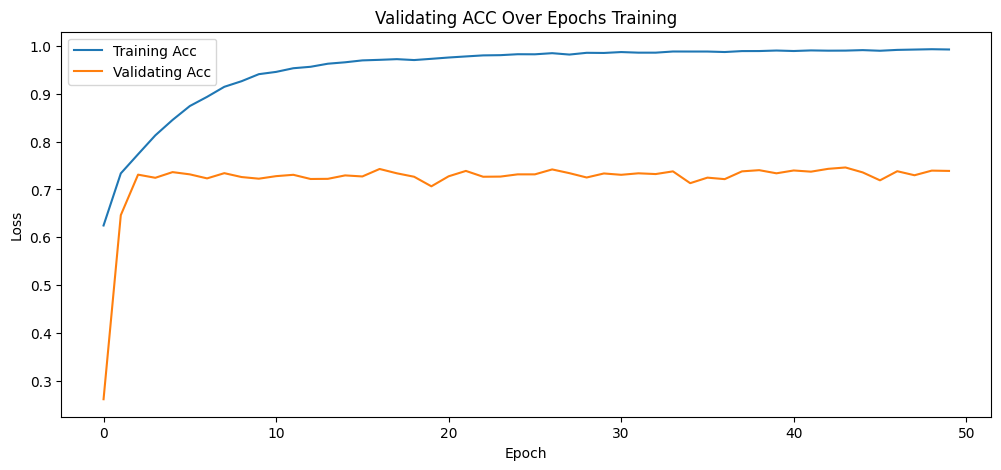

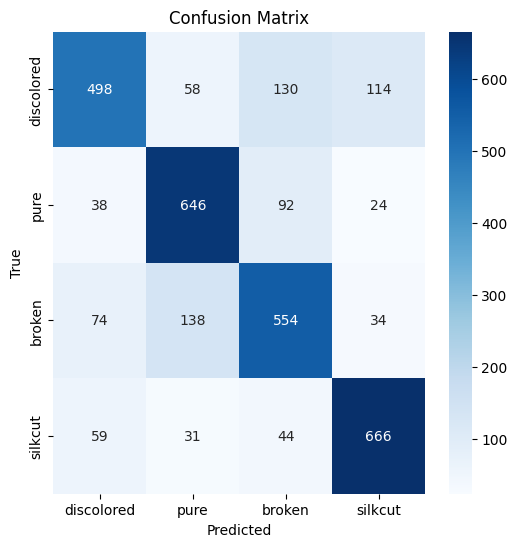

Waktu : 133.72838956514994
Loss : 4.585423473119736
Accuracy : 0.73875
Precision : 0.7386827021837234
Recall : 0.7387499958276749
F1-score : 0.7368537783622742
fold ke-4


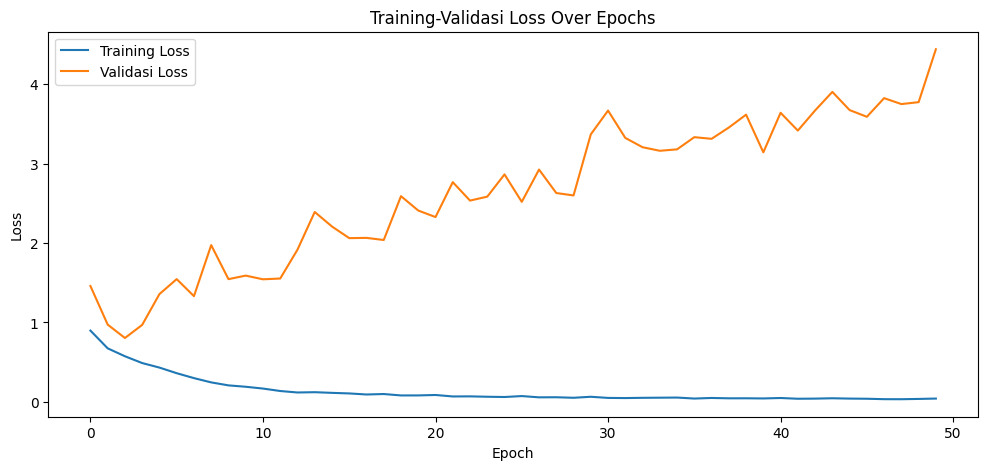

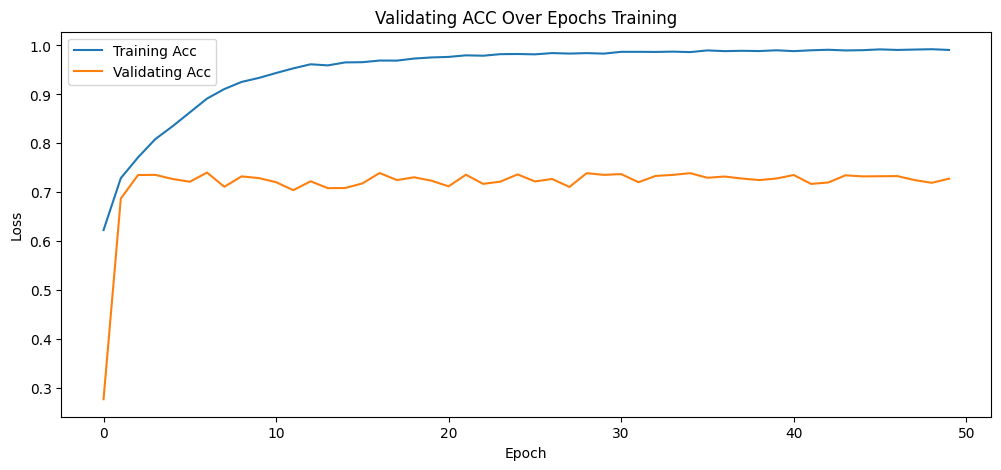

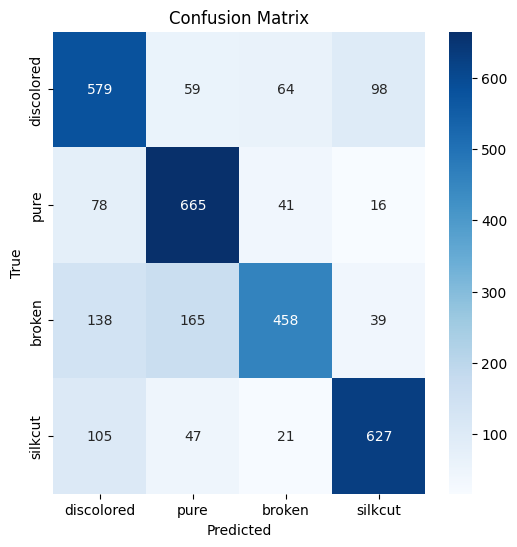

Waktu : 133.75476077397664
Loss : 4.439255958199501
Accuracy : 0.7278125
Precision : 0.7354740351438522
Recall : 0.7278124988079071
F1-score : 0.7257065027952194
Model Terbaik adalah model pada fold ke-2


In [ ]:
model = EfficientNetClassification("b1")
sistem = Classification(model,50)
sistem.can_predict()

#### Testing

In [ ]:
data_test = write_cachedImg(args['testing'])
x_test, y_test = Resize(data_test['images'], (240,240)), data_test['class']
print("Testing size", x_test.size())

Testing size torch.Size([4000, 240, 240, 3])


Hasil Testing


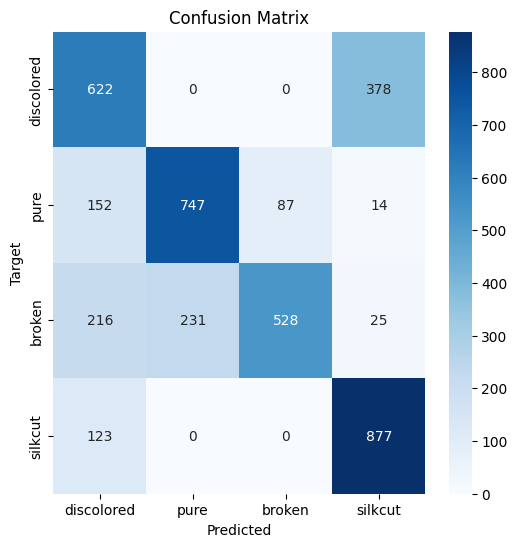

Loss : 4.604227047920227
Accuracy : 0.6935
Precision : 0.7147334069013596
Recall : 0.6934999823570251
F1-score : 0.6906294971704483


In [ ]:
sistem.predict(x_test.to(torch.float32), y_test, 'cpu')

### Skenario 3

#### Training - Val Fold ke-1

In [ ]:
k=0
data_train, data_val = write_cachedImg(args['train_val']+f"train_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_fold_{k}.pkl")
data_train['images'], data_val['images'] = Resize(data_train['images'], (260,260)), Resize(data_val['images'], (260,260))
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

In [ ]:
model = EfficientNetClassification("b2")
sistem = Classification(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 403MB/s]


Loaded pretrained weights for efficientnet-b2
fold ke-0
Epoch : 1 train loss : 0.8948828176409006 train acc : 0.623203125 val loss : 1.4381974744796753 val acc : 0.2503125 
Menyimpan Model
Epoch : 2 train loss : 0.6757481338083744 train acc : 0.7321875 val loss : 1.2962753933668136 val acc : 0.5984375 
Menyimpan Model
Epoch : 3 train loss : 0.5658387773111463 train acc : 0.776953125 val loss : 0.7898007065057755 val acc : 0.7375 
Menyimpan Model
Epoch : 4 train loss : 0.4801213767752051 train acc : 0.8196875 val loss : 0.8374373219907284 val acc : 0.7596875 
Menyimpan Model
Epoch : 5 train loss : 0.4045017359033227 train acc : 0.8525 val loss : 1.6291346935927868 val acc : 0.7284375 
Menyimpan Model
Epoch : 6 train loss : 0.3377965739183128 train acc : 0.874140625 val loss : 1.1835122822225095 val acc : 0.740625 
Menyimpan Model
Epoch : 7 train loss : 0.2812186046130955 train acc : 0.894453125 val loss : 1.4463932390511036 val acc : 0.7503125 
Menyimpan Model
Epoch : 8 train loss : 0.2

#### Training - Val Fold ke-2

In [ ]:
k=1
data_train, data_val = write_cachedImg(args['train_val']+f"train_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_fold_{k}.pkl")
data_train['images'], data_val['images'] = Resize(data_train['images'], (260,260)), Resize(data_val['images'], (260,260))
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([12800, 260, 260, 3])
Validation size torch.Size([3200, 260, 260, 3])


In [ ]:
model = EfficientNetClassification("b2")
sistem = Classification(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 258MB/s]


Loaded pretrained weights for efficientnet-b2
fold ke-1
Epoch : 1 train loss : 0.8809682708233595 train acc : 0.63578125 val loss : 1.385354986190796 val acc : 0.314375 
Menyimpan Model
Epoch : 2 train loss : 0.6584605207294225 train acc : 0.736328125 val loss : 1.0272008931636811 val acc : 0.62625 
Menyimpan Model
Epoch : 3 train loss : 0.5553700160980225 train acc : 0.783828125 val loss : 0.8428995637595653 val acc : 0.7278125 
Menyimpan Model
Epoch : 4 train loss : 0.4699053420871496 train acc : 0.821015625 val loss : 1.0060619580745698 val acc : 0.718125 
Menyimpan Model
Epoch : 5 train loss : 0.393769498988986 train acc : 0.85125 val loss : 1.376115706861019 val acc : 0.7228125 
Menyimpan Model
Epoch : 6 train loss : 0.3241922740638256 train acc : 0.878125 val loss : 1.4401638765633107 val acc : 0.7225 
Menyimpan Model
Epoch : 7 train loss : 0.26775555570609866 train acc : 0.901328125 val loss : 1.4124262246489525 val acc : 0.734375 
Menyimpan Model
Epoch : 8 train loss : 0.227880

#### Training - Val Fold ke-3

In [ ]:
k=2
data_train, data_val = write_cachedImg(args['train_val']+f"train_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_fold_{k}.pkl")
data_train['images'], data_val['images'] = Resize(data_train['images'], (260,260)), Resize(data_val['images'], (260,260))
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([12800, 260, 260, 3])
Validation size torch.Size([3200, 260, 260, 3])


In [ ]:
model = EfficientNetClassification("b2")
sistem = Classification(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 241MB/s]


Loaded pretrained weights for efficientnet-b2
fold ke-2
Epoch : 1 train loss : 0.9014916948229075 train acc : 0.62203125 val loss : 1.393247525691986 val acc : 0.238125 
Menyimpan Model
Epoch : 2 train loss : 0.6768610259890556 train acc : 0.728046875 val loss : 1.3584061044454574 val acc : 0.5925 
Menyimpan Model
Epoch : 3 train loss : 0.5643842544406652 train acc : 0.78078125 val loss : 0.8483716425299644 val acc : 0.7359375 
Menyimpan Model
Epoch : 4 train loss : 0.49220685470849274 train acc : 0.810390625 val loss : 1.3389896795153617 val acc : 0.7359375 
Menyimpan Model
Epoch : 5 train loss : 0.41527720365673304 train acc : 0.843125 val loss : 1.0328517761826514 val acc : 0.7353125 
Menyimpan Model
Epoch : 6 train loss : 0.3442886759713292 train acc : 0.8734375 val loss : 1.268661383986473 val acc : 0.7371875 
Menyimpan Model
Epoch : 7 train loss : 0.28789496523328123 train acc : 0.895546875 val loss : 1.374538715481758 val acc : 0.735 
Menyimpan Model
Epoch : 8 train loss : 0.245

#### Training - Val Fold ke-4

In [ ]:
k=3
data_train, data_val = write_cachedImg(args['train_val']+f"train_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_fold_{k}.pkl")
data_train['images'], data_val['images'] = Resize(data_train['images'], (260,260)), Resize(data_val['images'], (260,260))
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([12800, 260, 260, 3])
Validation size torch.Size([3200, 260, 260, 3])


In [ ]:
model = EfficientNetClassification("b2")
sistem = Classification(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Loaded pretrained weights for efficientnet-b2
fold ke-3
Epoch : 1 train loss : 0.8821676982939244 train acc : 0.627265625 val loss : 1.3773011898994445 val acc : 0.29625 
Menyimpan Model
Epoch : 2 train loss : 0.651684469729662 train acc : 0.740625 val loss : 1.241496165394783 val acc : 0.6259375 
Menyimpan Model
Epoch : 3 train loss : 0.5536935864761472 train acc : 0.7828125 val loss : 0.8835256624221802 val acc : 0.7453125 
Menyimpan Model
Epoch : 4 train loss : 0.47648924954235555 train acc : 0.819375 val loss : 1.0021768504381179 val acc : 0.729375 
Menyimpan Model
Epoch : 5 train loss : 0.40048815190792086 train acc : 0.8496875 val loss : 1.0286626479029655 val acc : 0.72875 
Menyimpan Model
Epoch : 6 train loss : 0.33434796473011374 train acc : 0.8790625 val loss : 1.6233802771568298 val acc : 0.715 
Menyimpan Model
Epoch : 7 train loss : 0.280901746628806 train acc : 0.90203125 val loss : 1.5339226769655943 val acc : 0.7303125 
Menyimpan Model
Epoch : 8 train loss : 0.2316498403

#### Training - Val Fold ke-5

In [ ]:
k=4
data_train, data_val = write_cachedImg(args['train_val']+f"train_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_fold_{k}.pkl")
data_train['images'], data_val['images'] = Resize(data_train['images'], (260,260)), Resize(data_val['images'], (260,260))
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([12800, 260, 260, 3])
Validation size torch.Size([3200, 260, 260, 3])


In [ ]:
model = EfficientNetClassification("b2")
sistem = Classification(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 182MB/s]


Loaded pretrained weights for efficientnet-b2
fold ke-4
Epoch : 1 train loss : 0.8801884112507105 train acc : 0.63234375 val loss : 1.4104676365852356 val acc : 0.2928125 
Menyimpan Model
Epoch : 2 train loss : 0.6727895818650722 train acc : 0.732265625 val loss : 1.3748851376771927 val acc : 0.60375 
Menyimpan Model
Epoch : 3 train loss : 0.5606008138507604 train acc : 0.778515625 val loss : 0.884567160308361 val acc : 0.7503125 
Menyimpan Model
Epoch : 4 train loss : 0.4783957984670997 train acc : 0.81640625 val loss : 1.3039574497938156 val acc : 0.73875 
Menyimpan Model
Epoch : 5 train loss : 0.406778195053339 train acc : 0.845390625 val loss : 1.2305943492054938 val acc : 0.731875 
Menyimpan Model
Epoch : 6 train loss : 0.336174819227308 train acc : 0.87484375 val loss : 1.3686883237957954 val acc : 0.734375 
Menyimpan Model
Epoch : 7 train loss : 0.2704245654586703 train acc : 0.900859375 val loss : 1.668158677816391 val acc : 0.6978125 
Menyimpan Model
Epoch : 8 train loss : 0.2

#### Memilih Model Terbaik

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 309MB/s]


Loaded pretrained weights for efficientnet-b2
fold ke-0


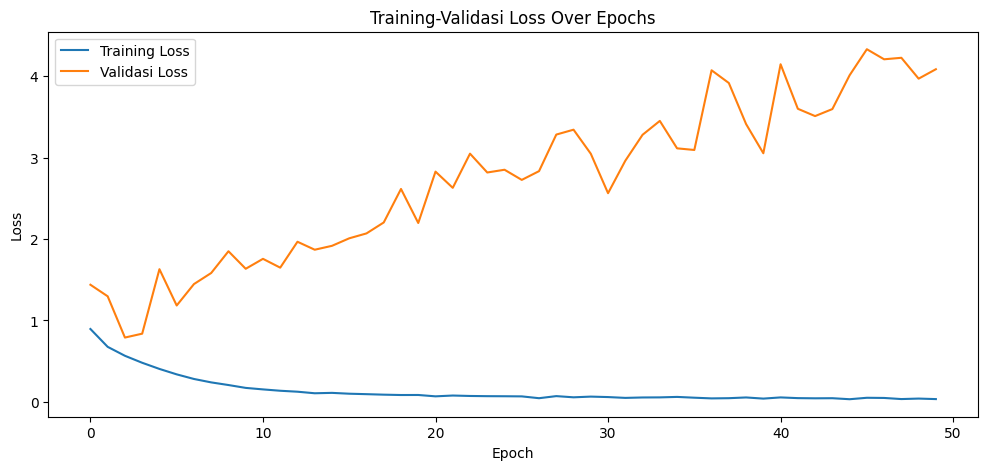

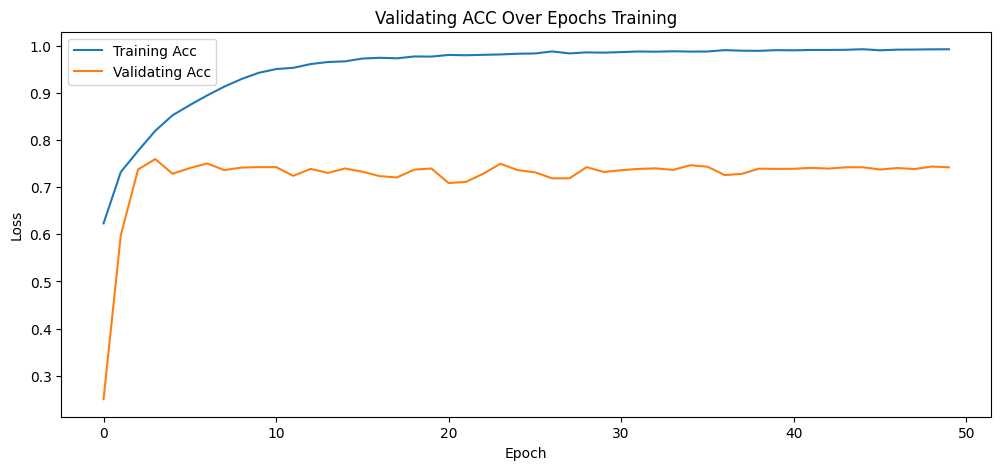

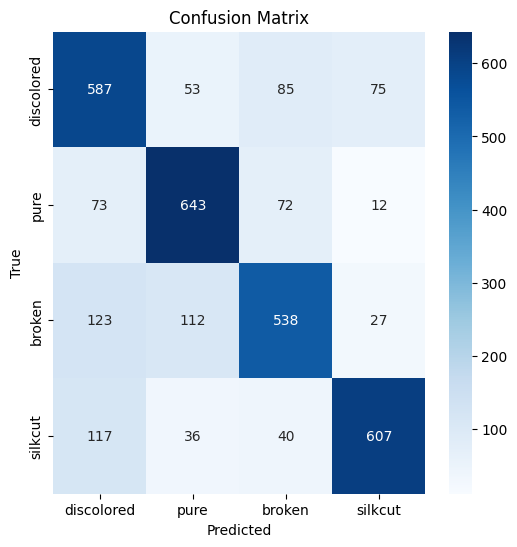

Waktu : 169.0548889160156
Loss : 4.084590176939964
Accuracy : 0.7421875
Precision : 0.7469824105501175
Recall : 0.7421875
F1-score : 0.7429907470941544
fold ke-1


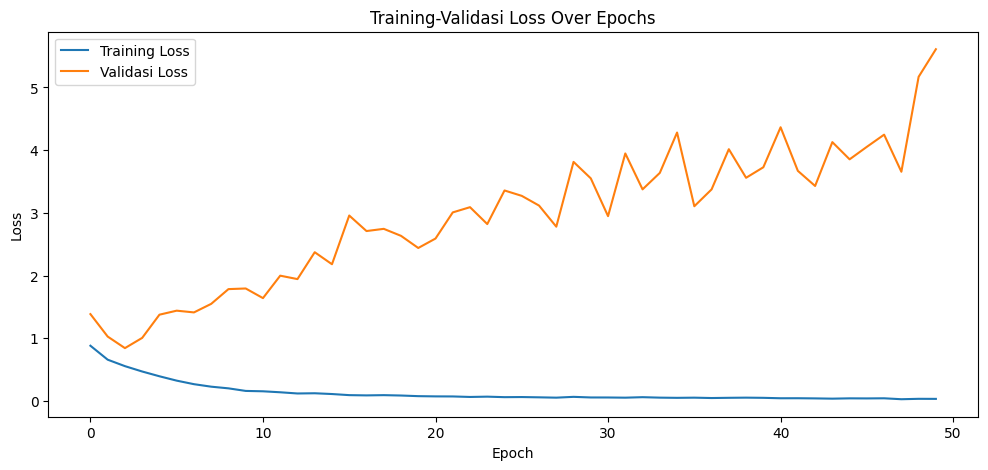

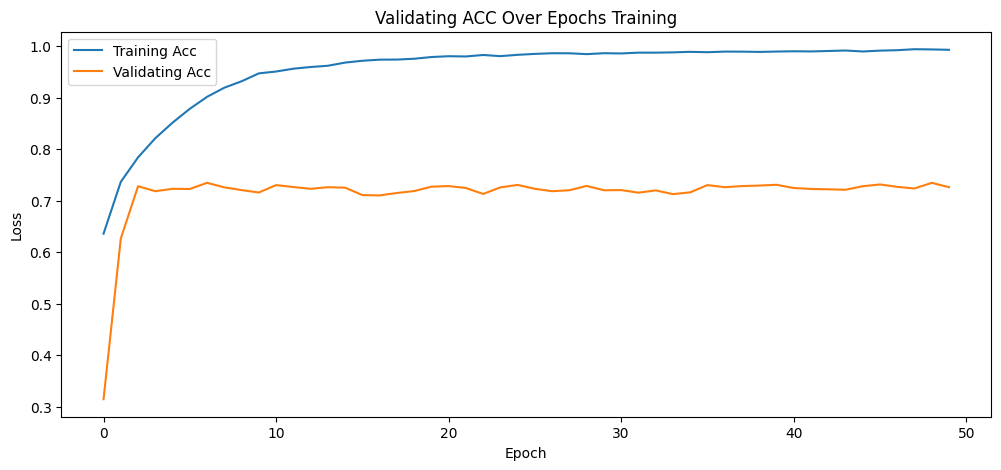

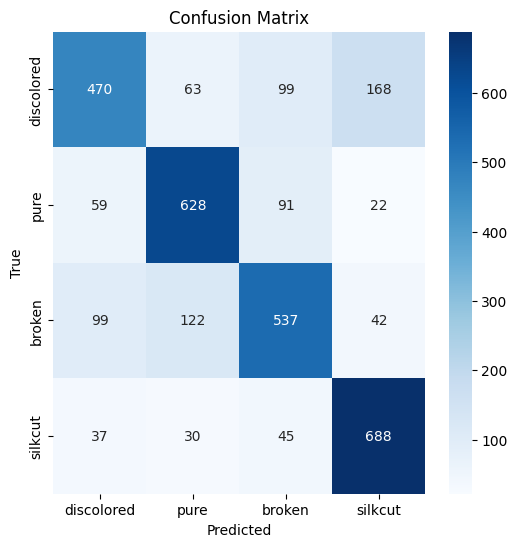

Waktu : 168.2245647350947
Loss : 5.610143674612045
Accuracy : 0.7259375
Precision : 0.7237868309020996
Recall : 0.7259375005960464
F1-score : 0.7223249077796936
fold ke-2


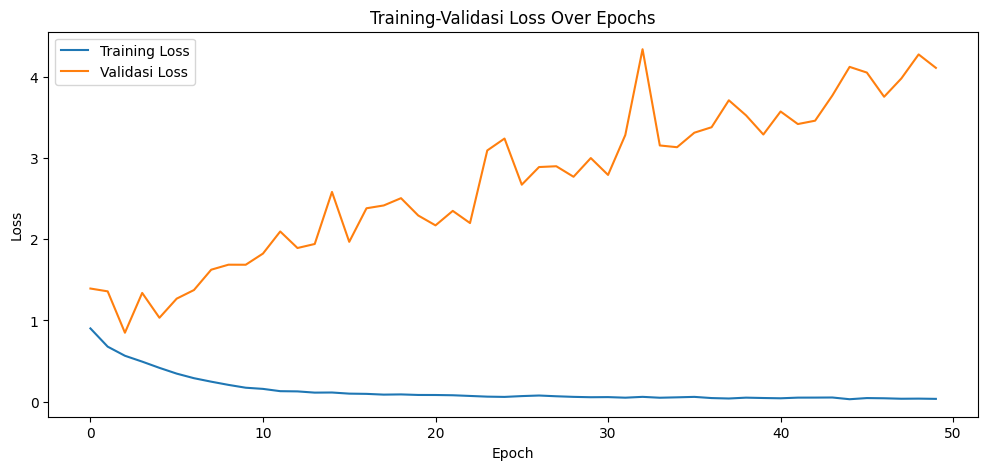

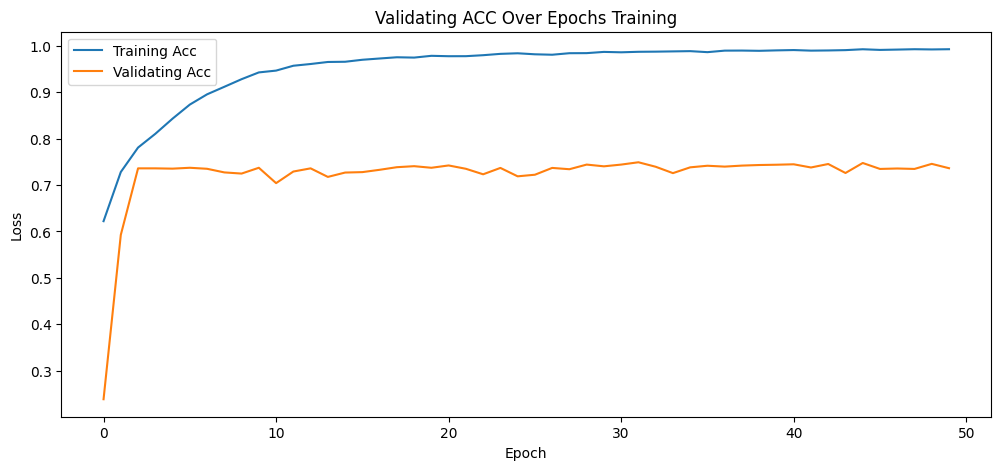

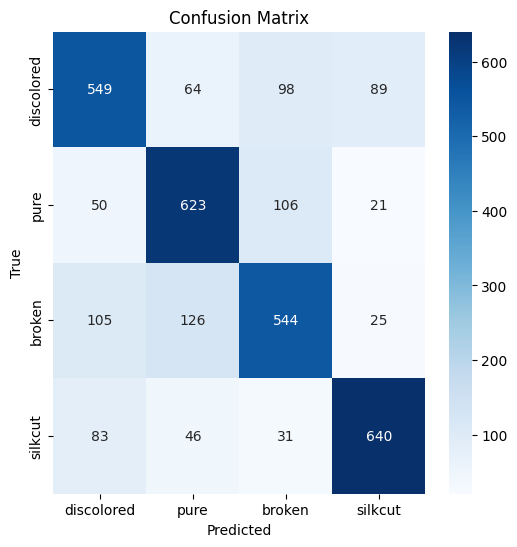

Waktu : 172.35150987704594
Loss : 4.113448352217675
Accuracy : 0.73625
Precision : 0.7367463260889053
Recall : 0.7362499982118607
F1-score : 0.7361670881509781
fold ke-3


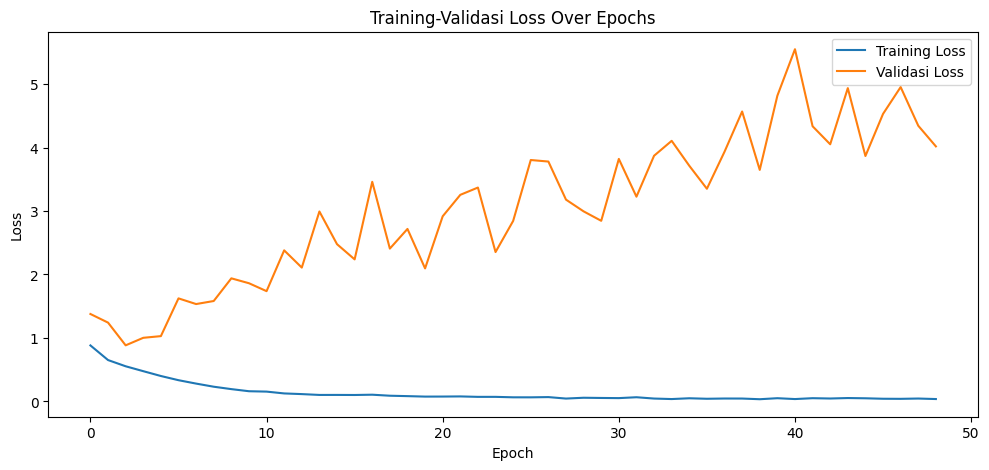

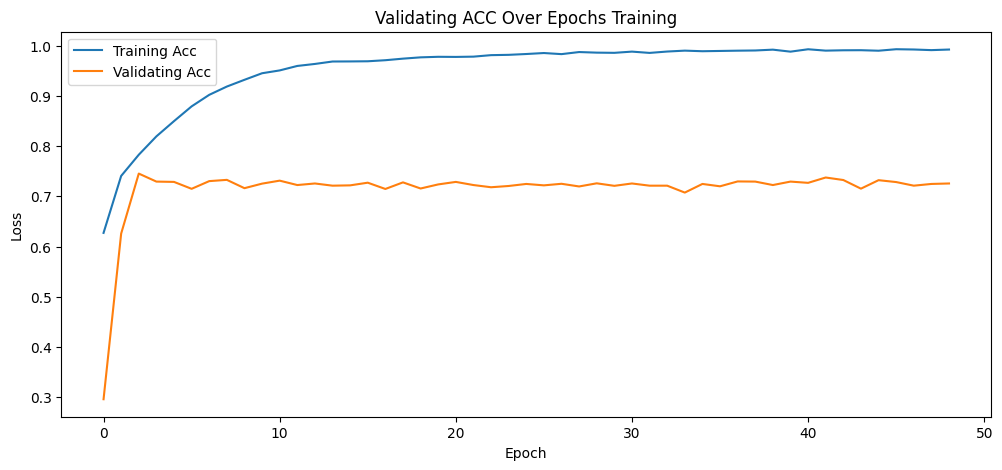

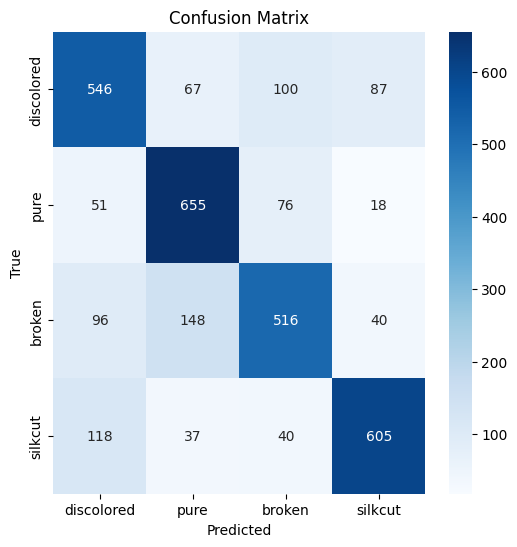

Waktu : 169.1033728758494
Loss : 4.0178778052330015
Accuracy : 0.725625
Precision : 0.7267471551895142
Recall : 0.7256250083446503
F1-score : 0.7248856276273727
fold ke-4


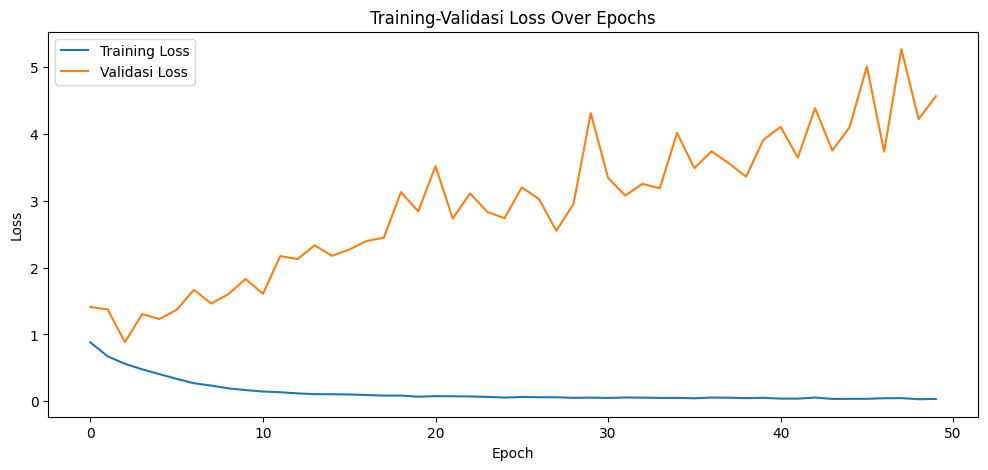

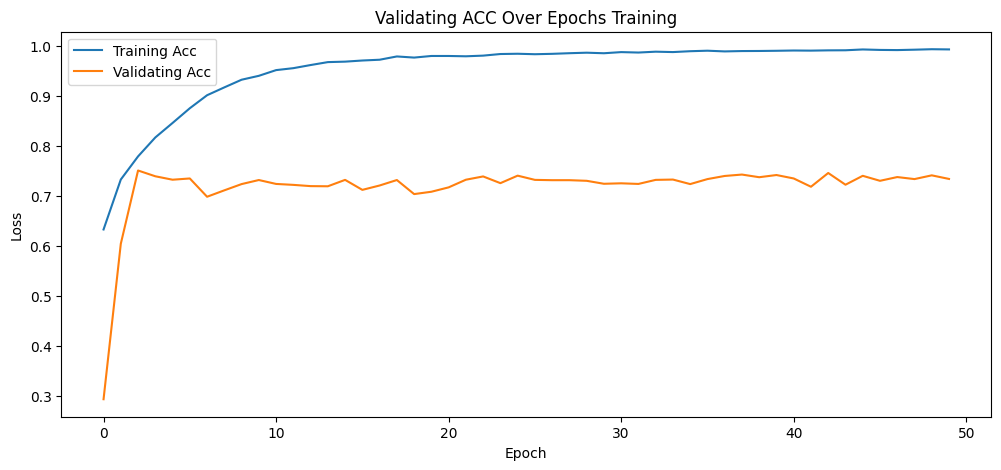

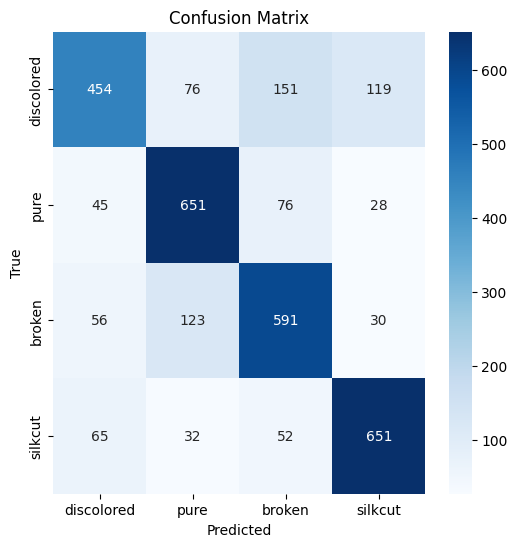

Waktu : 166.70768122673036
Loss : 4.563148227334023
Accuracy : 0.7334375
Precision : 0.7339738756418228
Recall : 0.7334375083446503
F1-score : 0.7302634567022324
Model Terbaik adalah model pada fold ke-0


In [ ]:
model = EfficientNetClassification("b2")
sistem = Classification(model,50)
sistem.can_predict()

#### Testing

In [ ]:
data_test = write_cachedImg(args['testing'])
x_test, y_test = Resize(data_test['images'], (260,260)), data_test['class']
print("Testing size", x_test.size())

Testing size torch.Size([4000, 260, 260, 3])


Hasil Testing


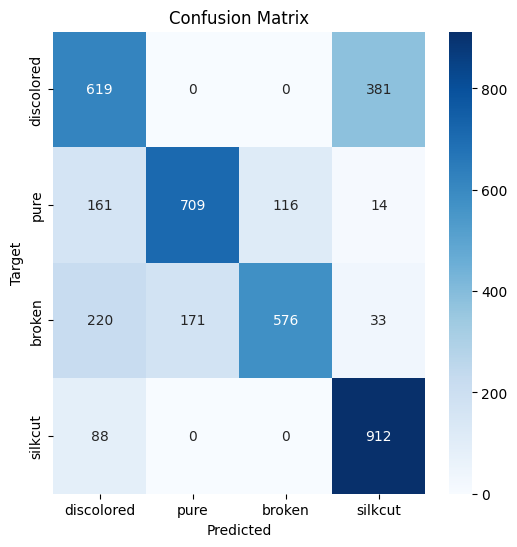

Loss : 5.398692862510681
Accuracy : 0.704
Precision : 0.7218956500291824
Recall : 0.7039999961853027
F1-score : 0.7018763422966003


In [ ]:
sistem.predict(x_test.to(torch.float32), y_test, 'cpu')

### Menampilkan hasil Prediksi

In [ ]:
data_test = write_cachedImg(args['testing'])
x_test, y_test =data_test['images'].to(torch.float32), data_test['class']
# x_test = x_test
test_loader = DataLoader(TensorDataset(x_test.permute(0,3,1,2), y_test), batch_size = 32, shuffle=True, num_workers = 0)

model = EfficientNetClassification('b0')
prediksi =[]
model.load_state_dict(torch.load(args['best_model'], map_location='cpu') ,strict=False)
model.eval()
with torch.no_grad():

    for batch_idx, (images, labels) in enumerate(test_loader):

        outputs = model(images)
        _, predict = torch.max(outputs.data, 1)
        prediksi.extend(predict)

# with torch.no_grad():
#     model.eval()
#     outputs = model(x_test)
#     _, predict = torch.max(outputs.data,1)



In [ ]:
n_result=100
for i in range(0,n_result,2):
    target_1 = args['class'][y_test[i].item()]
    target_2 = args['class'][y_test[i+1].item()]
    predict_1 = args['class'][prediksi[i]]
    predict_2 = args['class'][prediksi[i+1]]

    if target_1==predict_1:
        result_1="Benar"
    else:
        result_1="Salah"
    plt.rcParams.update({'font.size': 8})

    plt.subplot(1, 2, 1)
    plt.imshow(x_test[i].abs()/255)
    plt.title(f'Target: {target_1} Prediksi :{predict_1} \n({result_1})')

    if target_2==predict_2:
        result_2="Benar"
    else:
        result_2="Salah"

    plt.subplot(1, 2, 2)
    plt.imshow(x_test[i+1].abs()/255)
    plt.title(f'Target: {target_2} Prediksi :{predict_2}\n ({result_2})')
    plt.show()

# KLASIFIKASI NON DEEPSMOTE

## Class dan Function Khusus Non DeepSMOTE

### a. Klasifikasi Non DeepSMOTE

In [ ]:
#preprocessing, training+validation, testing,
class ClassificationNonDS:
  def __init__(self, model, epochs):
    self.model, self.criterion, self.epochs = model, nn.CrossEntropyLoss(), epochs

  def compile(self, optim, lr):
    if optim == "rmsprop":
      self.model_optimizer = torch.optim.RMSprop(self.model.parameters(), lr=lr, alpha=1-0.9, momentum=1-0.9)

  def preprocessing(self,x, y, xval, yval):
    if self.Train == True:
      self.data_x_train, self.data_y_train = x.permute(0,3,1,2)/255.0, y
      self.data_x_val, self.data_y_val = xval.permute(0,3,1,2)/255.0, yval

      # self.classes = torch.unique(self.data_y.))
      self.train_loader = DataLoader(TensorDataset(self.data_x_train, self.data_y_train), batch_size = 32, shuffle=True, num_workers = 0)
      self.val_loader = DataLoader(TensorDataset(self.data_x_val, self.data_y_val), batch_size = 32, shuffle=True, num_workers = 0)

    else:
      self.data_x_test, self.data_y_test = x.permute(0,3,1,2)/255.0, y
      self.test_loader = DataLoader(TensorDataset(self.data_x_test, self.data_y_test), batch_size = 32, shuffle=True, num_workers = 0)

  def save_model(self, k):
    torch.save(self.model.state_dict(), args['model_klasifikasi']+"best_nonds_lib_eff_"+self.model.version+"_"+str(k)+"fold_.pth")

  def train(self, model, optimizer, criterion, train_loader):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    alpha, beta = 1e-5, 1e-3
    for id_batch, (images, labels) in enumerate(train_loader):
        images = images.to(self.device)
        labels = labels.to(self.device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        l1_regularization = torch.tensor(0.0, device=self.device)
        l2_regularization = torch.tensor(0.0, device=self.device)

        for param in model.parameters():
            l1_regularization += torch.norm(param, 1)
            l2_regularization += torch.norm(param, 2)

        running_loss += loss.item()
        _, predict = torch.max(outputs.data, 1)
        correct += (predict == labels).sum().item()
        total += labels.size(0)
        loss = loss + alpha * l1_regularization + beta * l2_regularization

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    return model, train_loss, train_acc

  def valid(self, model, criterion, valid_loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    all_prediction, all_target = [], []

    with torch.no_grad():

        for batch_idx, (images, labels) in enumerate(valid_loader):
            images = images.to(self.device)
            labels = labels.to(self.device)

            outputs = model(images)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predict = torch.max(outputs.data, 1)
            correct += (predict == labels).sum().item()
            total += labels.size(0)


            all_prediction.extend(predict.cpu().numpy())
            all_target.extend(labels.cpu().numpy())

    val_loss = running_loss / len(valid_loader)
    val_acc = correct / total
    eval=self.evaluate(all_prediction, all_target)

    return model, val_loss, val_acc, eval

  def fit(self, X,y,xval,yval,k, device):
    self.Train = True
    self.device=device
    self.fold_stats = {}
    self.model = self.model.to(device)
    self.criterion = self.criterion.to(device)
    self.compile('rmsprop',args['lr'])
    # best_perform = -1

    #Kfold Splitting
    # for k, (self.train_id, self.val_id) in enumerate (self.kfold.split(X,y)):
    loss_fold, acc_fold, loss_val, acc_val, perform=[], [], [], [], []
    best_loss = 999
    time_start = time.time()
    print(f"fold ke-{k}")
    self.preprocessing(X,y,xval,yval)

    # early stopping setup
    es_threshold = 10
    es_counter = 0

    #Training Model with fold
    for epoch in range(self.epochs):

      self.model, train_loss, train_acc = self.train(self.model, self.model_optimizer, self.criterion, self.train_loader)

      self.model, val_loss, val_acc, eval = self.valid(self.model, self.criterion, self.val_loader)
      loss_fold.append(train_loss)
      acc_fold.append(train_acc)
      loss_val.append(val_loss)
      acc_val.append(val_acc)
      perform.append(eval)

      #simpan model
      print(f"Epoch : {epoch+1} train loss : {train_loss} train acc : {train_acc} val loss : {val_loss} val acc : {val_acc} ")
      if train_loss < best_loss :
        print("Menyimpan Model")
        self.save_model(k)
        best_loss = train_loss
        es_counter = 0
      else:
        es_counter+=1
        if es_counter>=es_threshold:
          print(f"Early stopping after {epoch + 1} epochs.")
          break

    #save timer
    time_stop = time.time()
    self.fold_stats['timer']=(time_stop-time_start)/60

    #simpan semua loss fold
    self.fold_stats['loss_training'], self.fold_stats['acc_training']=loss_fold, acc_fold
    self.fold_stats['loss_validasi'], self.fold_stats['acc_validasi'], self.fold_stats['perform']=loss_val, acc_val, perform

    save_cachedImg(args['model_klasifikasi']+f"perform_nonds_lib_eff_{self.model.version}_{k}_fold.pkl", self.fold_stats)
    print(f"fold -{k} acc : {self.fold_stats['perform'][-1][0]} precision : {self.fold_stats['perform'][-1][1]} recall : {self.fold_stats['perform'][-1][2]} f1 : {self.fold_stats['perform'][-1][3]}")
    #save fold model final with best accuracy

  def can_predict(self):
    path_class = os.listdir(args['model_klasifikasi'])
    #checking perform model version with fold
    path_perform = [f"perform_nonds_lib_eff_{self.model.version}_{k}_fold.pkl" for k in range (5)]
    stats = []
    for path in path_perform:
      if path in path_class:
        can_it = True
        status_fold = write_cachedImg(args['model_klasifikasi']+path)
        stats.append(status_fold)

      else:
        can_it =False
        print("Tidak bisa dilakukan karena kfold validation belum selesai!")
        break

    # select_by_accuracy
    if can_it:
      self.show_perform(stats)
      best_acc, best_k = 0, 0
      for k in range (len(stats)):
        if stats[k]['acc_validasi'][-1]>best_acc:
          best_acc = stats[k]['acc_validasi'][-1]
          best_k = k
      print(f"Model Terbaik adalah model pada fold ke-{best_k}")
      self.best_model_path = self.select_path_model(best_k)


  def predict(self, X,y, device):
    self.Train = False
    self.device = device
    #select path
    self.model.load_state_dict(torch.load(self.best_model_path, map_location=device) ,strict=False)
    # self.model.eval()

    # #preprocessing
    self.preprocessing(X,y, None, None)

    # self.final_perform = self.evaluate(*self.prediction_(self.test_loader, device))
    _, test_loss, test_acc, perform = self.valid(self.model, self.criterion, self.test_loader)

    print(f"Hasil Testing")

    plt.figure(figsize=(6, 6))
    sn.heatmap(perform[4], annot=True, fmt='d', cmap='Blues', xticklabels=args['class'], yticklabels=args['class'])
    plt.xlabel('Predicted')
    plt.ylabel('Target')
    plt.title('Confusion Matrix')
    plt.show()

    print(f"Loss : {test_loss}")
    print(f"Accuracy : {test_acc}")
    print(f"Precision : {perform[1]}")
    print(f"Recall : {perform[2]}")
    print(f"F1-score : {perform[3]}")

  def select_path_model(self, k):
    return args['model_klasifikasi']+f"best_nonds_lib_eff_"+self.model.version+"_"+str(k)+"fold_.pth"

  def show_perform(self, stats):
    for k in range(len(stats)):
      print(f"fold ke-{k}")
      acc_val, precision, recall, f1_total = [], [], [], []
      for a in range(len(stats[k]['perform'])):
        acc_val.append(stats[k]['perform'][a][0])
        precision.append(stats[k]['perform'][a][1])
        recall.append(stats[k]['perform'][a][2])
        f1_total.append(stats[k]['perform'][a][3])
      plt.figure(figsize=(12, 5))
      plt.plot(stats[k]['loss_training'], label='Training Loss')
      plt.plot(stats[k]['loss_validasi'], label='Validasi Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.title('Training-Validasi Loss Over Epochs')
      plt.legend()
      plt.show()

      plt.figure(figsize=(12, 5))
      plt.plot(stats[k]['acc_training'], label='Training Acc')
      plt.plot(stats[k]['acc_validasi'], label='Validating Acc')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.title('Validating ACC Over Epochs Training')
      plt.legend()
      plt.show()


      plt.figure(figsize=(6, 6))
      sn.heatmap(stats[k]['perform'][-1][4], annot=True, fmt='d', cmap='Blues', xticklabels=args['class'], yticklabels=args['class'])
      plt.xlabel('Predicted')
      plt.ylabel('True')
      plt.title('Confusion Matrix')
      plt.show()

      print(f"Waktu : {stats[k]['timer']}")
      print(f"Loss : {stats[k]['loss_validasi'][-1]}")
      print(f"Accuracy : {stats[k]['acc_validasi'][-1]}")
      print(f"Precision : {stats[k]['perform'][-1][1]}")
      print(f"Recall : {stats[k]['perform'][-1][2]}")
      print(f"F1-score : {stats[k]['perform'][-1][3]}")

  def evaluate(self, predict, target):
    conf_matrix = torch.from_numpy(confusion_matrix(target, predict))
    metrics_per_class = {}
    for i in range(conf_matrix.size(0)):
      TP = conf_matrix[i, i]
      FP = torch.sum(conf_matrix[:, i]) - TP
      FN = torch.sum(conf_matrix[i, :]) - TP
      TN = torch.sum(conf_matrix) - TP -FP -FN

      accuracy = (TP + TN) / torch.sum(conf_matrix)
      precision = TP / (TP + FP)
      recall = TP / (TP + FN)
      f1 = 2 * (precision * recall) / (precision + recall)

      metrics_per_class[args['class'][i]] = {
          'acc': accuracy.item(),
          'precision': precision.item(),
          'recall': recall.item(),
          'f1': f1.item()}
    accuracy_total = sum(metric['acc'] for metric in metrics_per_class.values()) / conf_matrix.size(0)
    precision_total = sum(metric['precision'] for metric in metrics_per_class.values()) / conf_matrix.size(0)
    recall_total = sum(metric['recall'] for metric in metrics_per_class.values()) / conf_matrix.size(0)
    f1_total = sum(metric['f1'] for metric in metrics_per_class.values()) / conf_matrix.size(0)
    return [accuracy_total, precision_total, recall_total, f1_total, conf_matrix, metrics_per_class]


### b. Fungsi KFOLD Non DeepSMOTE

In [ ]:
def kfold_splitting_nds(X,y,n):
  kfold = StratifiedKFold(n_splits=n, shuffle=True)
  for k, (train_id, val_id) in enumerate (kfold.split(X,y)):
    data_train = {'images':X[train_id], 'class':y[train_id]}
    data_validasi = {'images':X[val_id], 'class':y[val_id]}
    # data_train_validasi[k]={'train':data_train, 'validasi':data_validasi}
    save_cachedImg(args['train_val']+f"train_nonds_fold_{k}.pkl", data_train)
    save_cachedImg(args['train_val']+f"val_nonds_fold_{k}.pkl", data_validasi)

## Implementasi

### *1. Load Data

In [ ]:
dataset_segmentasi = write_cachedImg(args['segmentasi']+"segmentasi.pkl")

### *2. Undersampling

In [ ]:
# select class
classes = torch.unique(dataset_segmentasi['class'])
jumlah_class = torch.bincount(dataset_segmentasi['class'].int())
min = torch.argmin(jumlah_class)
target = jumlah_class[min]
print("Jumlah kelas :", jumlah_class)
print("Kelas Minimum :", jumlah_class[min])
data_x, data_y=[],[]
for cls in classes:
  img=dataset_segmentasi['images'][dataset_segmentasi['class']==cls][:target]
  kelas=dataset_segmentasi['class'][dataset_segmentasi['class']==cls][:target]
  data_x.append(img.to(torch.float16))
  data_y.append(kelas)
data_non_to_Balance_nds ={'images': torch.cat(data_x, dim=0),
                     'class': torch.cat(data_y, dim=0)}
save_cachedImg(args['downsample_nds'], data_non_to_Balance_nds)


Jumlah kelas : tensor([3115, 7265, 5670, 1751])
Kelas Minimum : tensor(1751)
berhasil menyimpan pkl drive/MyDrive/dataset/batch_img/data_undersampling_nds.pkl


### *3. Viusalisasi Ukuran Data

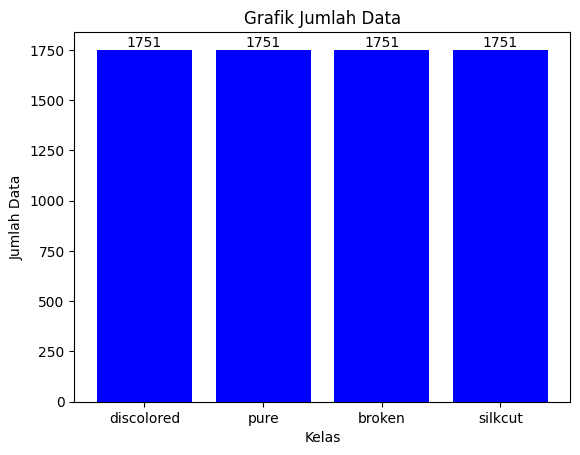

In [ ]:
n_data = [
    data_non_to_Balance_nds['class'][data_non_to_Balance_nds['class']==0].size(0),
    data_non_to_Balance_nds['class'][data_non_to_Balance_nds['class']==1].size(0),
    data_non_to_Balance_nds['class'][data_non_to_Balance_nds['class']==2].size(0),
    data_non_to_Balance_nds['class'][data_non_to_Balance_nds['class']==3].size(0)
]

classes = args['class']
plt.bar(classes, n_data, color='blue')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Data')
plt.title('Grafik Jumlah Data')
for i, value in enumerate(n_data):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom')

### *4. Pembagian Data Training dan Testing

In [ ]:
data_x, data_y = data_non_to_Balance_nds['images'], data_non_to_Balance_nds['class']
X_train, X_test, y_train, y_test = splitting_data(data_x, data_y, 0.2)

data_train = {'images':X_train, 'class': y_train}
data_test = {'images':X_test, 'class': y_test }

save_cachedImg(args['training_nds'], data_train)
save_cachedImg(args['testing_nds'], data_test)

print("size of train :", X_train.size(), y_train.size())
print("size of test :", X_test.size(), y_test.size())

berhasil menyimpan pkl drive/MyDrive/dataset/batch_img/data_training_nds.pkl
berhasil menyimpan pkl drive/MyDrive/dataset/batch_img/data_testing_nds.pkl
size of train : torch.Size([5604, 224, 224, 3]) torch.Size([5604])
size of test : torch.Size([1400, 224, 224, 3]) torch.Size([1400])


### *5. Pembagian KFOLD

In [ ]:
data_train = write_cachedImg(args['training_nds'])
kfold_splitting_nds(data_train['images'], data_train['class'], 5)

berhasil menyimpan pkl drive/MyDrive/dataset/batch_img/train_nonds_fold_0.pkl
berhasil menyimpan pkl drive/MyDrive/dataset/batch_img/val_nonds_fold_0.pkl
berhasil menyimpan pkl drive/MyDrive/dataset/batch_img/train_nonds_fold_1.pkl
berhasil menyimpan pkl drive/MyDrive/dataset/batch_img/val_nonds_fold_1.pkl
berhasil menyimpan pkl drive/MyDrive/dataset/batch_img/train_nonds_fold_2.pkl
berhasil menyimpan pkl drive/MyDrive/dataset/batch_img/val_nonds_fold_2.pkl
berhasil menyimpan pkl drive/MyDrive/dataset/batch_img/train_nonds_fold_3.pkl
berhasil menyimpan pkl drive/MyDrive/dataset/batch_img/val_nonds_fold_3.pkl
berhasil menyimpan pkl drive/MyDrive/dataset/batch_img/train_nonds_fold_4.pkl
berhasil menyimpan pkl drive/MyDrive/dataset/batch_img/val_nonds_fold_4.pkl


## KLASIFIKASI EFFICIENTNET

## Skenario 1

### Training - Val Fold ke-1

In [ ]:
k=0
data_train, data_val = write_cachedImg(args['train_val']+f"train_nonds_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_nonds_fold_{k}.pkl")
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([4483, 224, 224, 3])
Validation size torch.Size([1121, 224, 224, 3])


In [ ]:
model = EfficientNetClassification("b0")
sistem = ClassificationNonDS(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 340MB/s]


Loaded pretrained weights for efficientnet-b0
fold ke-0
Epoch : 1 train loss : 1.1044924352185945 train acc : 0.5451706446575953 val loss : 1.386404212978151 val acc : 0.3639607493309545 
Menyimpan Model
Epoch : 2 train loss : 0.7468778089428625 train acc : 0.7097925496319429 val loss : 1.0121967119889126 val acc : 0.5718108831400536 
Menyimpan Model
Epoch : 3 train loss : 0.5921182197036473 train acc : 0.77002007584207 val loss : 0.8310988131496642 val acc : 0.6797502230151651 
Menyimpan Model
Epoch : 4 train loss : 0.4683689521559587 train acc : 0.8244479143430739 val loss : 0.7463315369354354 val acc : 0.7297056199821588 
Menyimpan Model
Epoch : 5 train loss : 0.3530852291600924 train acc : 0.8681686370733883 val loss : 0.9417576450440619 val acc : 0.719892952720785 
Menyimpan Model
Epoch : 6 train loss : 0.28062240203433003 train acc : 0.901405308944903 val loss : 0.9177510616783466 val acc : 0.7234611953612846 
Menyimpan Model
Epoch : 7 train loss : 0.20439246351044651 train acc :

### Training - Val Fold ke-2

In [ ]:
k=1
data_train, data_val = write_cachedImg(args['train_val']+f"train_nonds_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_nonds_fold_{k}.pkl")
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([4483, 224, 224, 3])
Validation size torch.Size([1121, 224, 224, 3])


In [ ]:
model = EfficientNetClassification("b0")
sistem = ClassificationNonDS(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Loaded pretrained weights for efficientnet-b0
fold ke-1
Epoch : 1 train loss : 1.1024541402539463 train acc : 0.541824670979255 val loss : 1.4428886456622019 val acc : 0.3095450490633363 
Menyimpan Model
Epoch : 2 train loss : 0.768667569397189 train acc : 0.6981931742136962 val loss : 0.9939766170250045 val acc : 0.584299732381802 
Menyimpan Model
Epoch : 3 train loss : 0.5956366345392051 train acc : 0.7726968547847424 val loss : 0.8519237173928155 val acc : 0.6886708296164139 
Menyimpan Model
Epoch : 4 train loss : 0.4696674542435518 train acc : 0.8260093687262994 val loss : 0.7669465856419669 val acc : 0.7234611953612846 
Menyimpan Model
Epoch : 5 train loss : 0.3610871923519364 train acc : 0.8695070265447246 val loss : 0.7714596862594286 val acc : 0.7341659232827832 
Menyimpan Model
Epoch : 6 train loss : 0.2633273475770409 train acc : 0.904528217711354 val loss : 0.883991503995882 val acc : 0.7154326494201606 
Menyimpan Model
Epoch : 7 train loss : 0.2121337627635357 train acc : 0

### Training - Val Fold ke-3

In [ ]:
k=2
data_train, data_val = write_cachedImg(args['train_val']+f"train_nonds_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_nonds_fold_{k}.pkl")
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([4483, 224, 224, 3])
Validation size torch.Size([1121, 224, 224, 3])


In [ ]:
model = EfficientNetClassification("b0")
sistem = ClassificationNonDS(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Loaded pretrained weights for efficientnet-b0
fold ke-2
Epoch : 1 train loss : 1.0828280482731811 train acc : 0.5650234218157484 val loss : 1.3334757023387485 val acc : 0.3773416592328278 
Menyimpan Model
Epoch : 2 train loss : 0.7423800838754532 train acc : 0.7062235110417131 val loss : 1.0154804239670436 val acc : 0.5905441570026762 
Menyimpan Model
Epoch : 3 train loss : 0.5891821703589555 train acc : 0.7742583091679679 val loss : 0.7069093906838033 val acc : 0.727921498661909 
Menyimpan Model
Epoch : 4 train loss : 0.4504865233568435 train acc : 0.8342627704662057 val loss : 0.7527669741409935 val acc : 0.7190008920606601 
Menyimpan Model
Epoch : 5 train loss : 0.37099269095887527 train acc : 0.8697300914566138 val loss : 0.8507413888959895 val acc : 0.7448706512042819 
Menyimpan Model
Epoch : 6 train loss : 0.27815154237104645 train acc : 0.8944902966763328 val loss : 0.877430077496279 val acc : 0.7404103479036575 
Menyimpan Model
Epoch : 7 train loss : 0.203857883810997 train acc

### Training - Val Fold ke-4

In [ ]:
k=3
data_train, data_val = write_cachedImg(args['train_val']+f"train_nonds_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_nonds_fold_{k}.pkl")
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([4483, 224, 224, 3])
Validation size torch.Size([1121, 224, 224, 3])


In [ ]:
model = EfficientNetClassification("b0")
sistem = ClassificationNonDS(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Loaded pretrained weights for efficientnet-b0
fold ke-3
Epoch : 1 train loss : 1.100445847562019 train acc : 0.5556546955163952 val loss : 1.526092893547482 val acc : 0.3238180196253345 
Menyimpan Model
Epoch : 2 train loss : 0.7477959240159244 train acc : 0.7082310952487174 val loss : 0.9733876221709781 val acc : 0.5994647636039251 
Menyimpan Model
Epoch : 3 train loss : 0.5888586143652598 train acc : 0.7787196074057551 val loss : 0.7640127843866745 val acc : 0.7020517395182873 
Menyimpan Model
Epoch : 4 train loss : 0.4758810142041944 train acc : 0.8175329020745037 val loss : 0.7012518354588084 val acc : 0.7332738626226584 
Menyimpan Model
Epoch : 5 train loss : 0.3605861989318902 train acc : 0.8715146107517288 val loss : 0.8814278625779681 val acc : 0.7136485280999108 
Menyimpan Model
Epoch : 6 train loss : 0.26394750135587464 train acc : 0.9040820878875753 val loss : 1.3372741258806653 val acc : 0.6868867082961642 
Menyimpan Model
Epoch : 7 train loss : 0.2299370618788063 train acc

### Training - Val Fold ke-5

In [ ]:
k=4
data_train, data_val = write_cachedImg(args['train_val']+f"train_nonds_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_nonds_fold_{k}.pkl")
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([4484, 224, 224, 3])
Validation size torch.Size([1120, 224, 224, 3])


In [ ]:
model = EfficientNetClassification("b0")
sistem = ClassificationNonDS(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Loaded pretrained weights for efficientnet-b0
fold ke-4
Epoch : 1 train loss : 1.09455750428193 train acc : 0.5557537912578056 val loss : 1.3314066546303884 val acc : 0.37589285714285714 
Menyimpan Model
Epoch : 2 train loss : 0.7363566113701949 train acc : 0.7098572702943801 val loss : 0.9789708512169975 val acc : 0.6017857142857143 
Menyimpan Model
Epoch : 3 train loss : 0.5927305249034935 train acc : 0.768064228367529 val loss : 0.7939344678606306 val acc : 0.7008928571428571 
Menyimpan Model
Epoch : 4 train loss : 0.4514727033410512 train acc : 0.8258251561106156 val loss : 0.8447518323149 val acc : 0.7258928571428571 
Menyimpan Model
Epoch : 5 train loss : 0.3460884281295411 train acc : 0.8722123104371097 val loss : 0.8898429725851331 val acc : 0.7303571428571428 
Menyimpan Model
Epoch : 6 train loss : 0.26436702822539826 train acc : 0.9027653880463872 val loss : 0.9571783329759326 val acc : 0.7223214285714286 
Menyimpan Model
Epoch : 7 train loss : 0.19740853659438748 train acc :

### Memilih Model Terbaik

Loaded pretrained weights for efficientnet-b0
fold ke-0


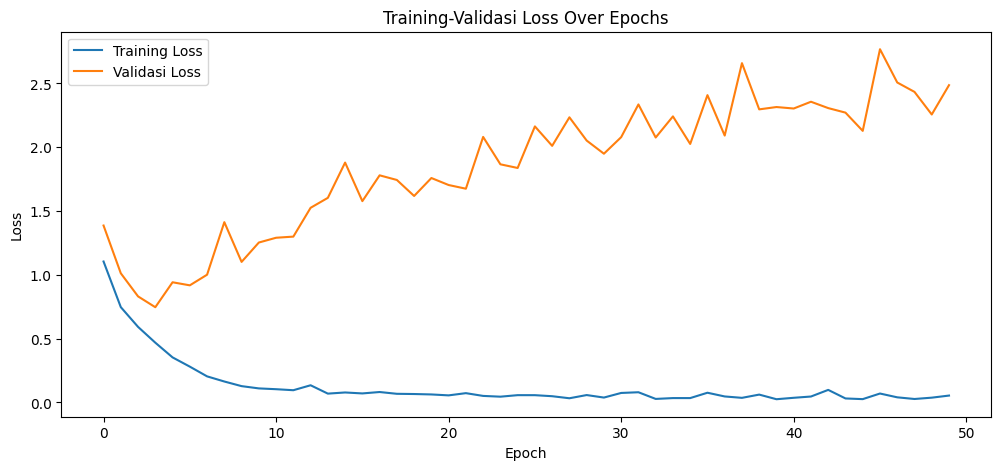

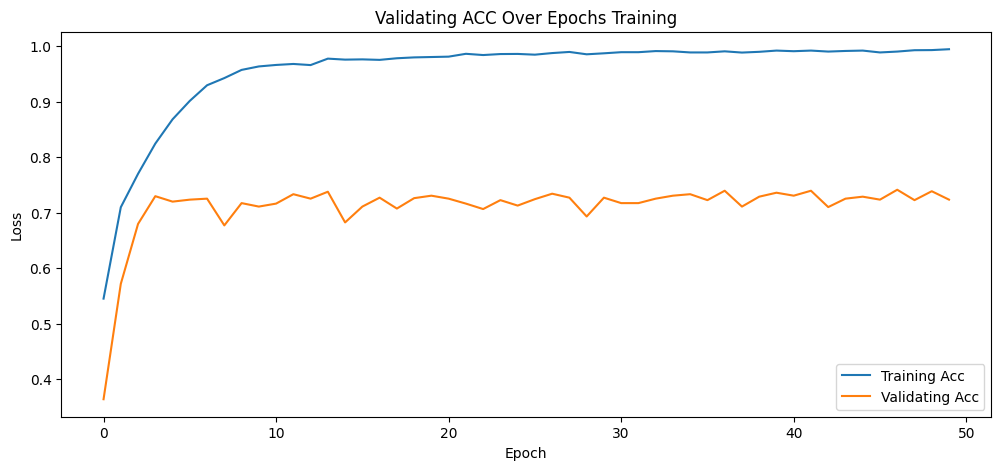

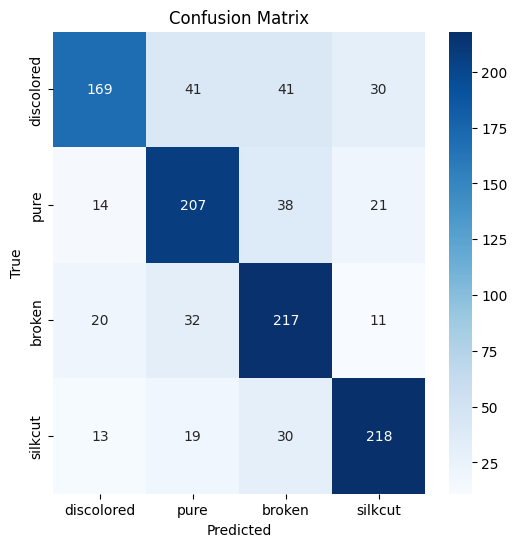

Waktu : 28.341586021582284
Loss : 2.4863347123480506
Accuracy : 0.7234611953612846
Precision : 0.7297326773405075
Recall : 0.7235701531171799
F1-score : 0.7224623709917068
fold ke-1


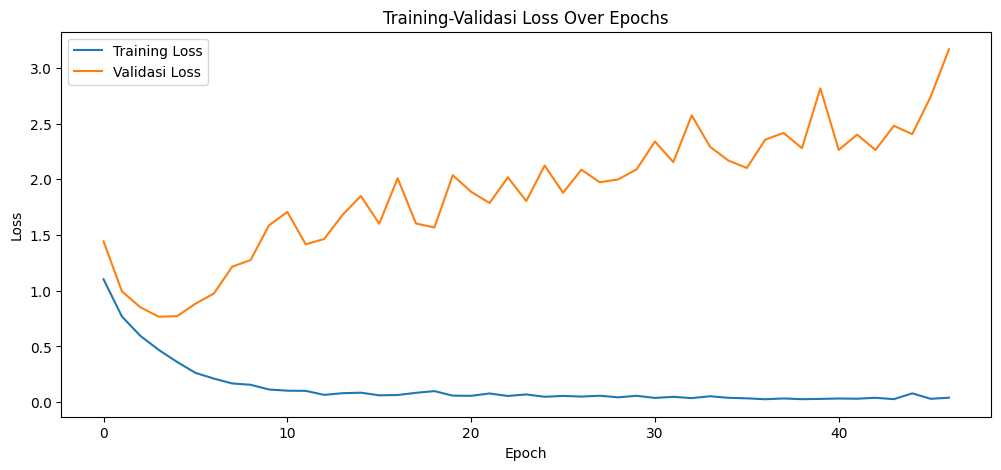

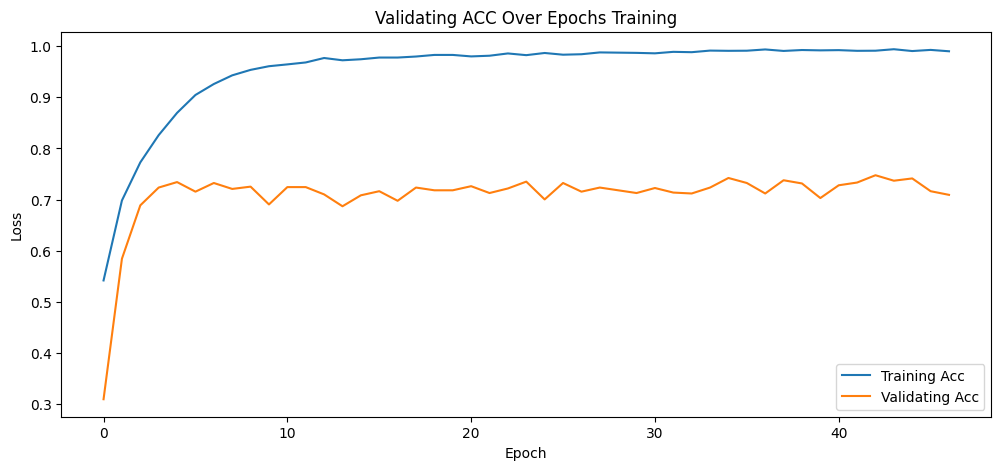

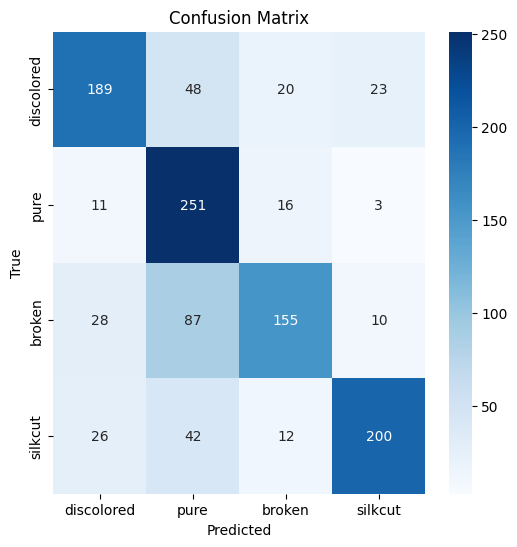

Waktu : 26.597590716679893
Loss : 3.166349765327242
Accuracy : 0.7091882247992863
Precision : 0.7353868931531906
Recall : 0.7090238928794861
F1-score : 0.708230122923851
fold ke-2


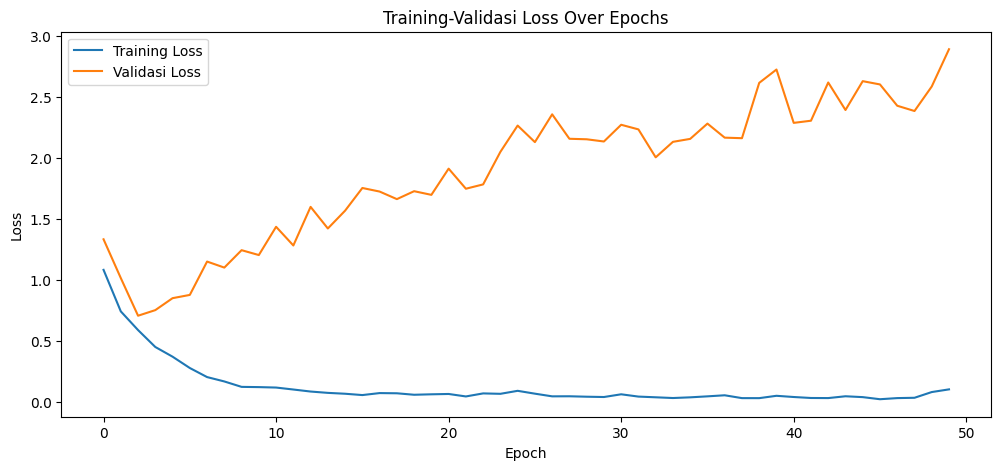

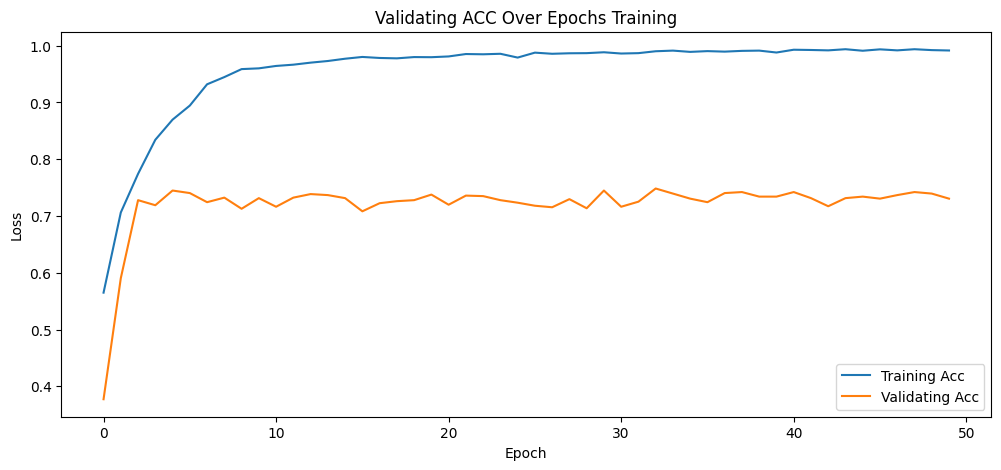

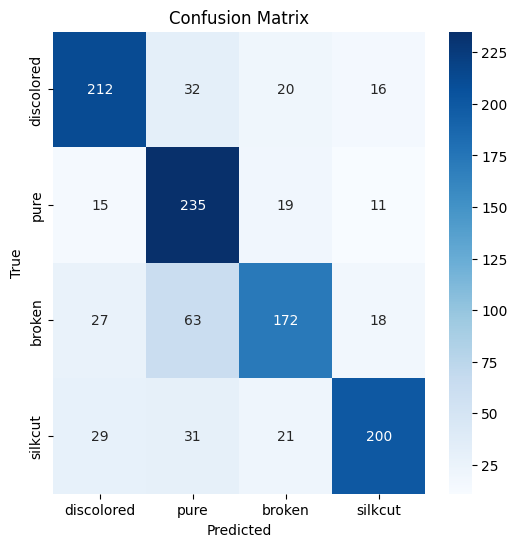

Waktu : 28.36437740723292
Loss : 2.8917046799583153
Accuracy : 0.7305976806422837
Precision : 0.7394479960203171
Recall : 0.7306145131587982
F1-score : 0.7296672165393829
fold ke-3


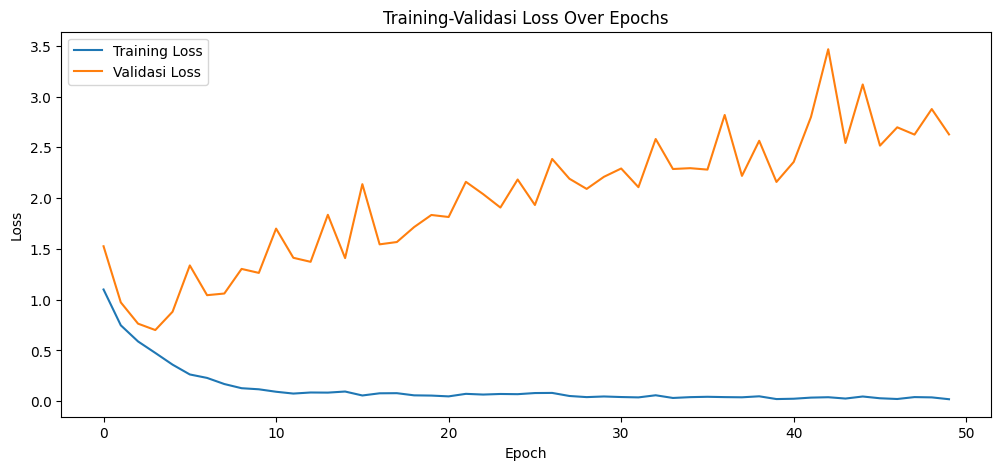

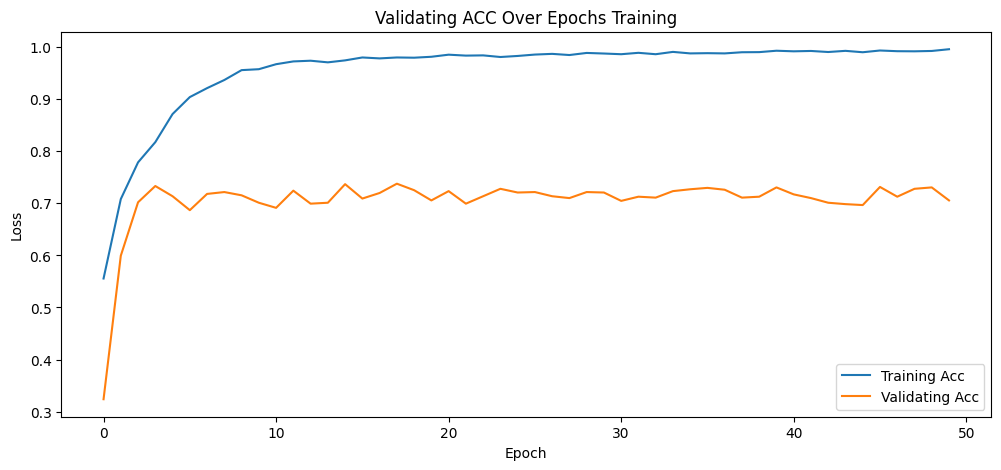

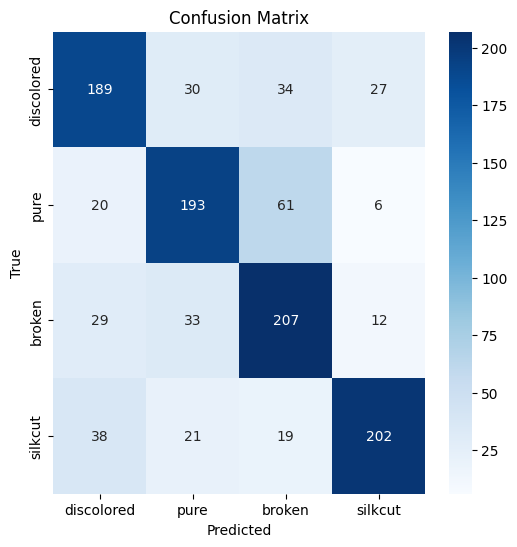

Waktu : 28.288653262456258
Loss : 2.6272830648554697
Accuracy : 0.7056199821587869
Precision : 0.7110517621040344
Recall : 0.7055922746658325
F1-score : 0.7067913115024567
fold ke-4


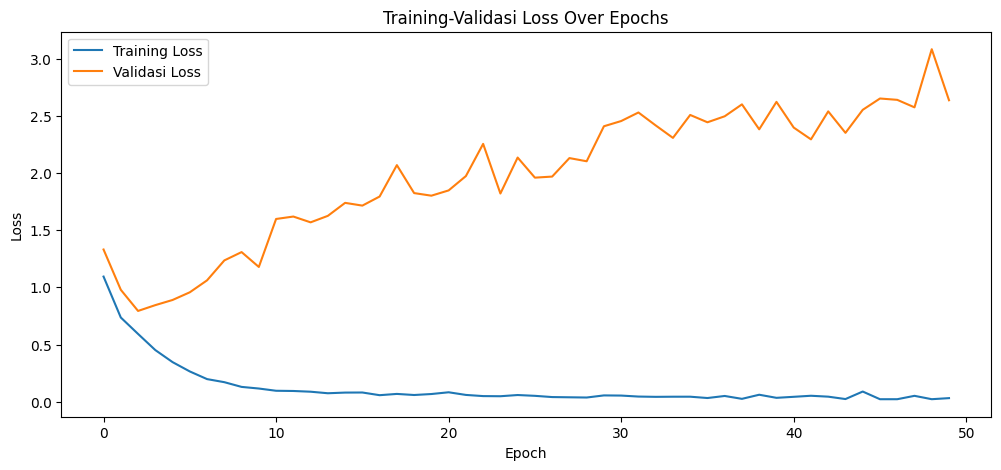

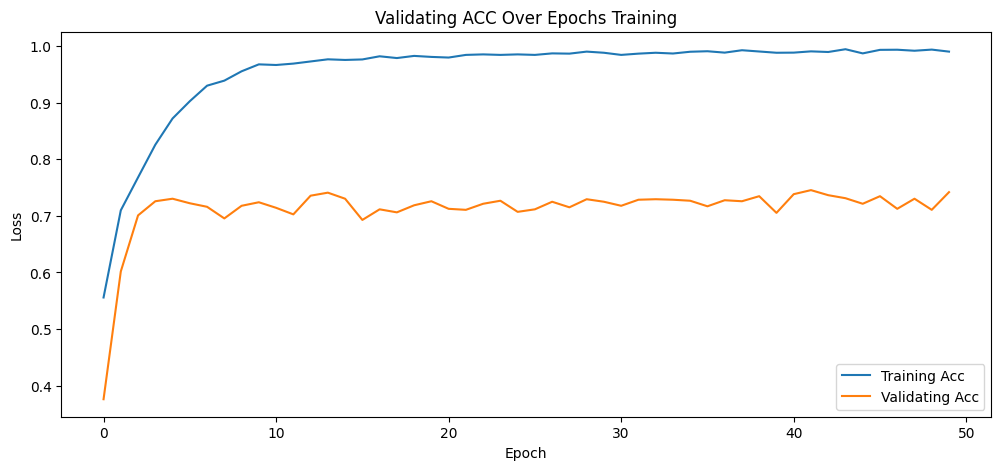

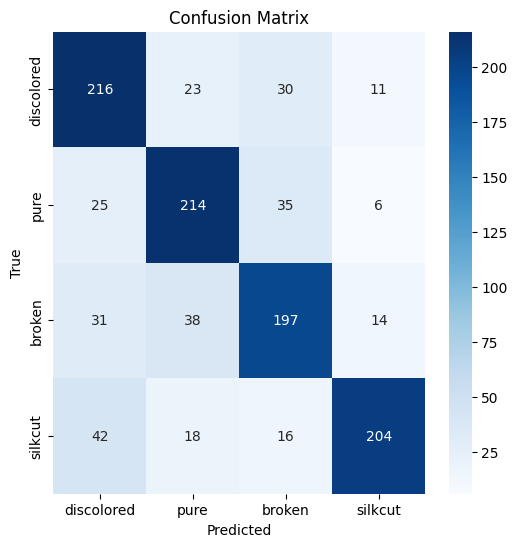

Waktu : 28.231717638174693
Loss : 2.637445524760655
Accuracy : 0.7419642857142857
Precision : 0.7487479150295258
Recall : 0.7419642955064774
F1-score : 0.7431361973285675
Model Terbaik adalah model pada fold ke-4


In [ ]:
model = EfficientNetClassification("b0")
sistem = ClassificationNonDS(model,50)
sistem.can_predict()

### Testing

In [ ]:
data_test = write_cachedImg(args['testing_nds'])
x_test, y_test = data_test['images'], data_test['class']
print("Testing size", x_test.size())

Testing size torch.Size([1400, 224, 224, 3])


Hasil Testing


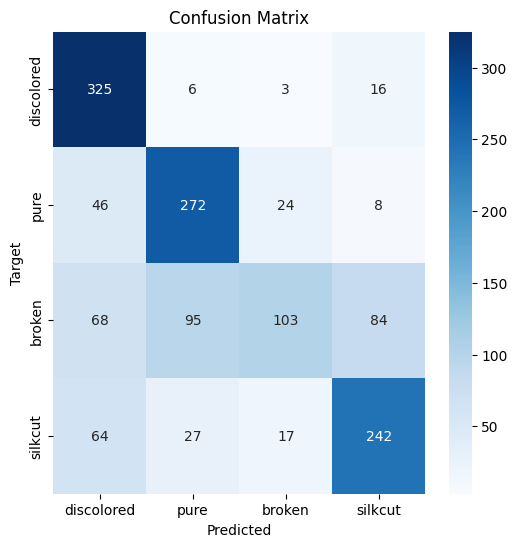

Loss : 3.6824213645674964
Accuracy : 0.6728571428571428
Precision : 0.6795580238103867
Recall : 0.6728571355342865
F1-score : 0.648316316306591


In [ ]:
sistem.predict(x_test.to(torch.float32), y_test, 'cpu')

## Skenario 2

### Training - Val Fold ke-1

In [ ]:
k=0
data_train, data_val = write_cachedImg(args['train_val']+f"train_nonds_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_nonds_fold_{k}.pkl")
data_train['images'], data_val['images'] = Resize(data_train['images'], (240,240)), Resize(data_val['images'], (240,240))
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([4483, 240, 240, 3])
Validation size torch.Size([1121, 240, 240, 3])


In [ ]:
model = EfficientNetClassification("b1")
sistem = ClassificationNonDS(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 336MB/s]


Loaded pretrained weights for efficientnet-b1
fold ke-0
Epoch : 1 train loss : 1.1221288476429931 train acc : 0.5279946464421147 val loss : 1.400396443075604 val acc : 0.24977698483496877 
Menyimpan Model
Epoch : 2 train loss : 0.7942729812141851 train acc : 0.6915012268570154 val loss : 1.433853526910146 val acc : 0.25245316681534347 
Menyimpan Model
Epoch : 3 train loss : 0.6114264294399437 train acc : 0.7651126477805041 val loss : 1.624305182033115 val acc : 0.2569134701159679 
Menyimpan Model
Epoch : 4 train loss : 0.47116280267847344 train acc : 0.8266785634619674 val loss : 1.578694565428628 val acc : 0.39964317573595004 
Menyimpan Model
Epoch : 5 train loss : 0.34766367416009836 train acc : 0.8726299353111755 val loss : 1.7090823981497023 val acc : 0.4950936663693131 
Menyimpan Model
Epoch : 6 train loss : 0.24798746619717027 train acc : 0.9130046843631496 val loss : 1.2635771334171295 val acc : 0.6306868867082962 
Menyimpan Model
Epoch : 7 train loss : 0.19353553440078353 train

### Training - Val Fold ke-2

In [ ]:
k=1
data_train, data_val = write_cachedImg(args['train_val']+f"train_nonds_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_nonds_fold_{k}.pkl")
data_train['images'], data_val['images'] = Resize(data_train['images'], (240,240)), Resize(data_val['images'], (240,240))
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([4483, 240, 240, 3])
Validation size torch.Size([1121, 240, 240, 3])


In [ ]:
model = EfficientNetClassification("b1")
sistem = ClassificationNonDS(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Loaded pretrained weights for efficientnet-b1
fold ke-1
Epoch : 1 train loss : 1.1156385012552248 train acc : 0.5333482043274593 val loss : 1.393003311422136 val acc : 0.24977698483496877 
Menyimpan Model
Epoch : 2 train loss : 0.7854685259203539 train acc : 0.685701539147892 val loss : 1.4229617019494374 val acc : 0.24977698483496877 
Menyimpan Model
Epoch : 3 train loss : 0.6065575877825419 train acc : 0.7675663618112871 val loss : 1.4013167520364125 val acc : 0.27386262265834077 
Menyimpan Model
Epoch : 4 train loss : 0.46693478989685683 train acc : 0.828240017845193 val loss : 1.2631331177221403 val acc : 0.39785905441570024 
Menyimpan Model
Epoch : 5 train loss : 0.3635942989841421 train acc : 0.8703992861922819 val loss : 1.0142991758055158 val acc : 0.6494201605709188 
Menyimpan Model
Epoch : 6 train loss : 0.24870756215660283 train acc : 0.9078741913896944 val loss : 1.2045493480206158 val acc : 0.6449598572702944 
Menyimpan Model
Epoch : 7 train loss : 0.2096915658008545 train

### Training - Val Fold ke-3

In [ ]:
k=2
data_train, data_val = write_cachedImg(args['train_val']+f"train_nonds_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_nonds_fold_{k}.pkl")
data_train['images'], data_val['images'] = Resize(data_train['images'], (240,240)), Resize(data_val['images'], (240,240))
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([4483, 240, 240, 3])
Validation size torch.Size([1121, 240, 240, 3])


In [ ]:
model = EfficientNetClassification("b1")
sistem = ClassificationNonDS(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 162MB/s]


Loaded pretrained weights for efficientnet-b1
fold ke-2
Epoch : 1 train loss : 1.131060963404094 train acc : 0.5320098148561231 val loss : 1.4119080271985796 val acc : 0.24977698483496877 
Menyimpan Model
Epoch : 2 train loss : 0.8112086044981125 train acc : 0.6796787865268793 val loss : 1.4486371245649126 val acc : 0.27386262265834077 
Menyimpan Model
Epoch : 3 train loss : 0.6395765012460397 train acc : 0.7579745706000446 val loss : 1.5030615958902571 val acc : 0.30776092774308655 
Menyimpan Model
Epoch : 4 train loss : 0.4811263951003974 train acc : 0.8246709792549632 val loss : 1.8593313462204404 val acc : 0.4255129348795718 
Menyimpan Model
Epoch : 5 train loss : 0.34869856213001493 train acc : 0.8692839616328352 val loss : 1.209673612895939 val acc : 0.5512934879571811 
Menyimpan Model
Epoch : 6 train loss : 0.2713930533921465 train acc : 0.9043051527994647 val loss : 1.1211926225158904 val acc : 0.6137377341659233 
Menyimpan Model
Epoch : 7 train loss : 0.2034013608193144 train 

### Training - Val Fold ke-4

In [ ]:
k=3
data_train, data_val = write_cachedImg(args['train_val']+f"train_nonds_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_nonds_fold_{k}.pkl")
data_train['images'], data_val['images'] = Resize(data_train['images'], (240,240)), Resize(data_val['images'], (240,240))
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([4483, 240, 240, 3])
Validation size torch.Size([1121, 240, 240, 3])


In [ ]:
model = EfficientNetClassification("b1")
sistem = ClassificationNonDS(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Loaded pretrained weights for efficientnet-b1
fold ke-3
Epoch : 1 train loss : 1.1242697987150638 train acc : 0.5300022306491189 val loss : 1.435945835378435 val acc : 0.25066904549509367 
Menyimpan Model
Epoch : 2 train loss : 0.8046302256431985 train acc : 0.6872629935311175 val loss : 1.4101924101511638 val acc : 0.3006244424620874 
Menyimpan Model
Epoch : 3 train loss : 0.61951944126305 train acc : 0.7657818425161722 val loss : 1.3183983365694683 val acc : 0.35504014272970563 
Menyimpan Model
Epoch : 4 train loss : 0.4800023951217638 train acc : 0.8190943564577292 val loss : 1.234936260514789 val acc : 0.4915254237288136 
Menyimpan Model
Epoch : 5 train loss : 0.36172772130222186 train acc : 0.8681686370733883 val loss : 1.056598737835884 val acc : 0.5976806422836753 
Menyimpan Model
Epoch : 6 train loss : 0.27887680170172496 train acc : 0.9009591791211242 val loss : 1.3467555857366986 val acc : 0.6592328278322926 
Menyimpan Model
Epoch : 7 train loss : 0.21073678479338367 train ac

### Training - Val Fold ke-5

In [ ]:
k=4
data_train, data_val = write_cachedImg(args['train_val']+f"train_nonds_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_nonds_fold_{k}.pkl")
data_train['images'], data_val['images'] = Resize(data_train['images'], (240,240)), Resize(data_val['images'], (240,240))
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([4484, 240, 240, 3])
Validation size torch.Size([1120, 240, 240, 3])


In [ ]:
model = EfficientNetClassification("b1")
sistem = ClassificationNonDS(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Loaded pretrained weights for efficientnet-b1
fold ke-4
Epoch : 1 train loss : 1.1348130047744047 train acc : 0.5165031222123104 val loss : 1.4364463942391532 val acc : 0.25 
Menyimpan Model
Epoch : 2 train loss : 0.8068200645717323 train acc : 0.6799732381801963 val loss : 1.4222790956497193 val acc : 0.26071428571428573 
Menyimpan Model
Epoch : 3 train loss : 0.613532489918648 train acc : 0.7591436217662801 val loss : 1.69911162512643 val acc : 0.30357142857142855 
Menyimpan Model
Epoch : 4 train loss : 0.4725679176073548 train acc : 0.8240410347903657 val loss : 1.7949666363852366 val acc : 0.36875 
Menyimpan Model
Epoch : 5 train loss : 0.35244877435636857 train acc : 0.8681980374665478 val loss : 1.3763903294290816 val acc : 0.5366071428571428 
Menyimpan Model
Epoch : 6 train loss : 0.265127458682297 train acc : 0.9043264942016057 val loss : 1.1888452546937125 val acc : 0.6285714285714286 
Menyimpan Model
Epoch : 7 train loss : 0.20661235428976674 train acc : 0.9275200713648528 va

### Memilih Model Terbaik

Loaded pretrained weights for efficientnet-b1
fold ke-0


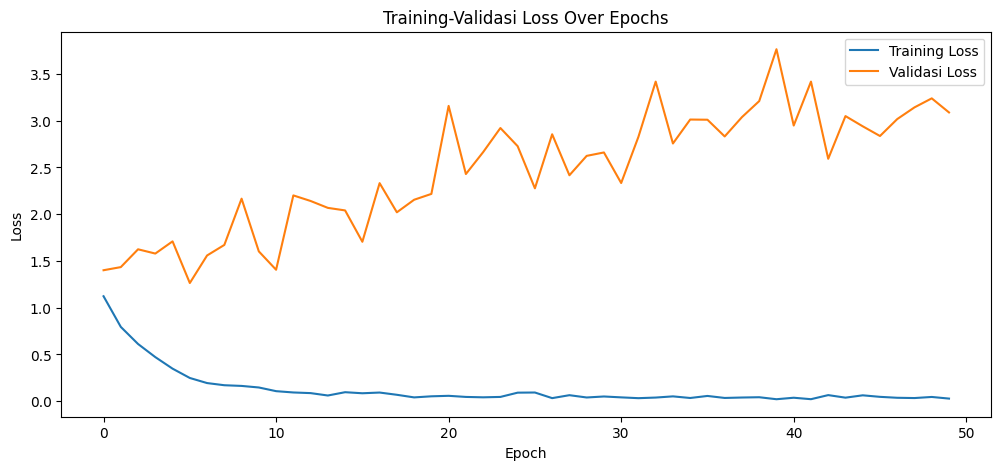

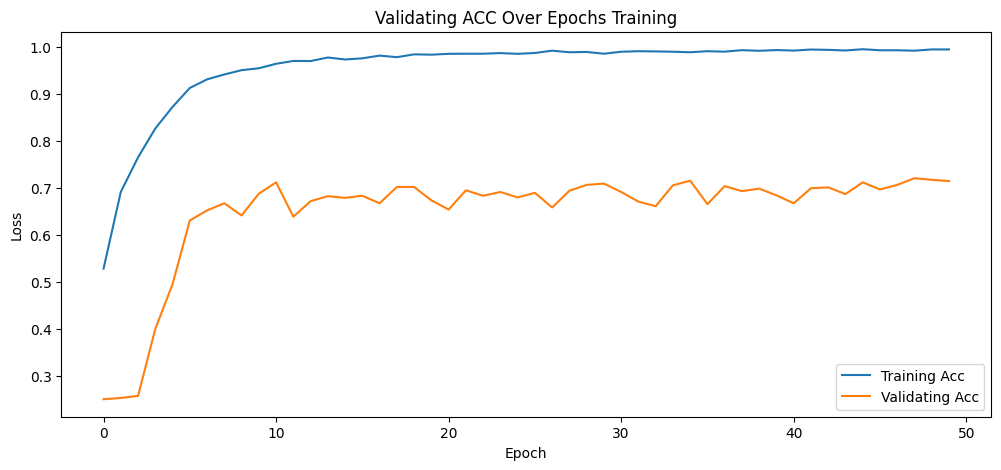

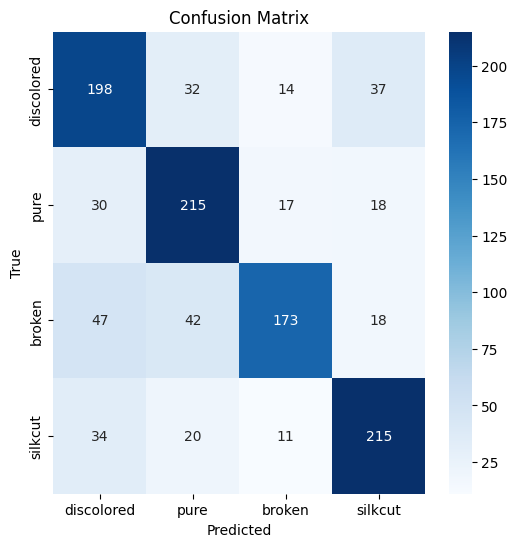

Waktu : 44.954415357112886
Loss : 3.0881312406725354
Accuracy : 0.7145405887600357
Precision : 0.7219371199607849
Recall : 0.7145494371652603
F1-score : 0.7143173813819885
fold ke-1


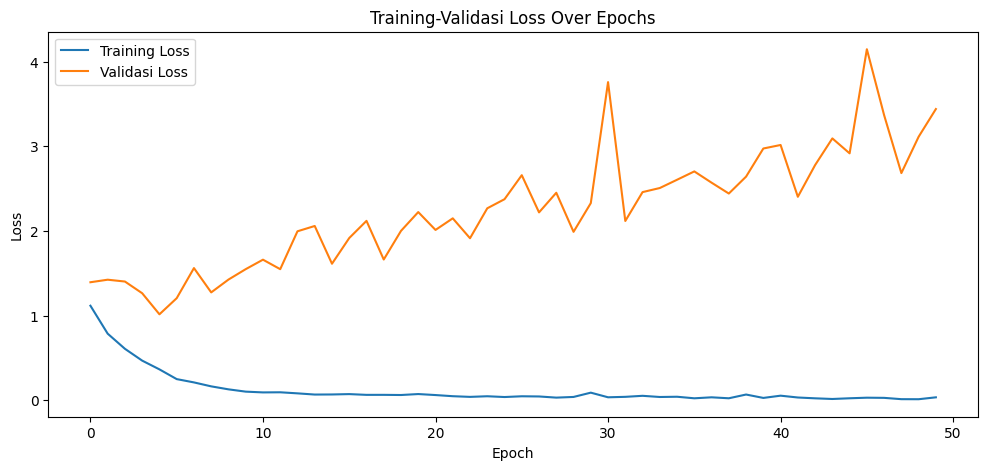

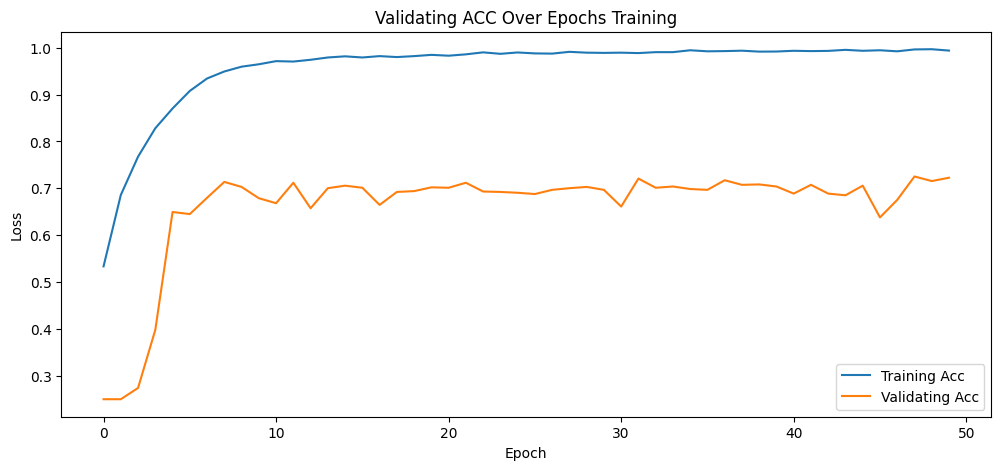

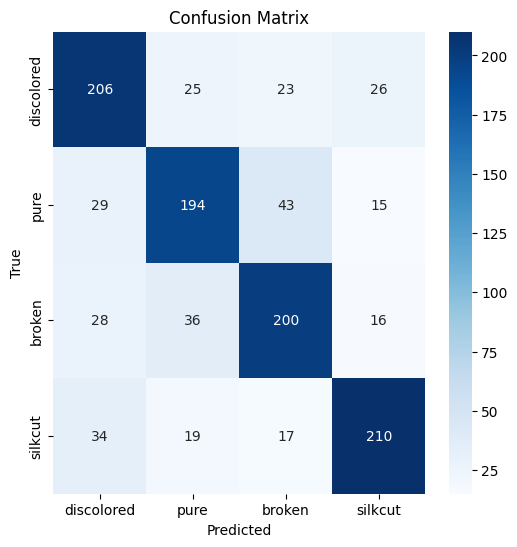

Waktu : 45.054381438096364
Loss : 3.4390678016675844
Accuracy : 0.7225691347011597
Precision : 0.7237156331539154
Recall : 0.7225978672504425
F1-score : 0.7228603065013885
fold ke-2


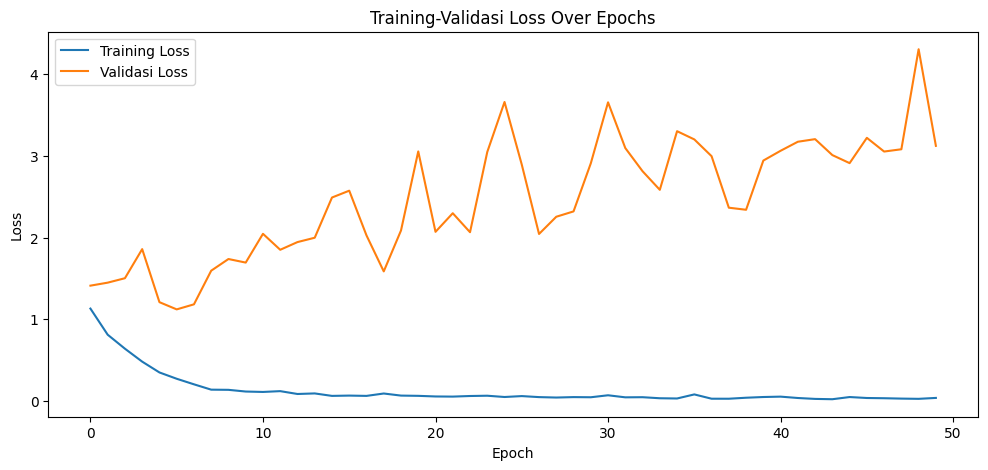

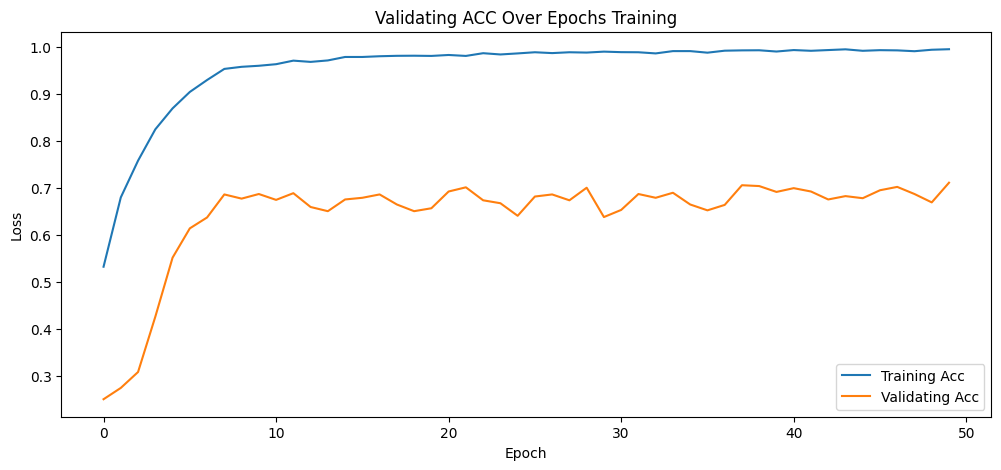

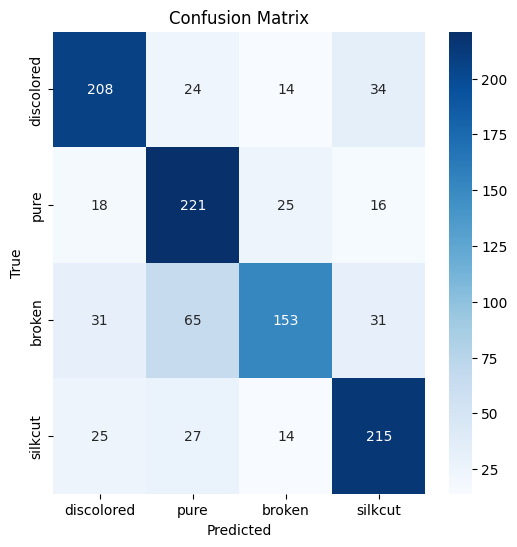

Waktu : 45.902308611075085
Loss : 3.124354441960653
Accuracy : 0.7109723461195361
Precision : 0.7156112045049667
Recall : 0.7109239995479584
F1-score : 0.7078616768121719
fold ke-3


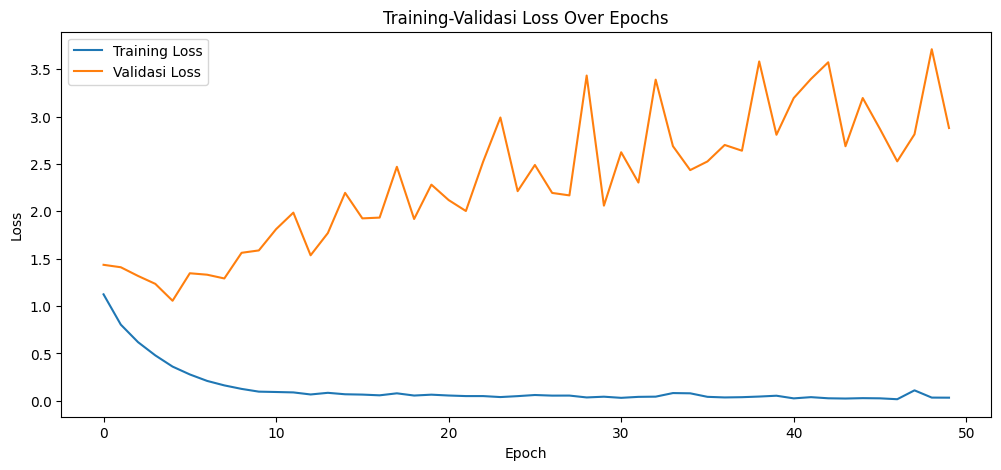

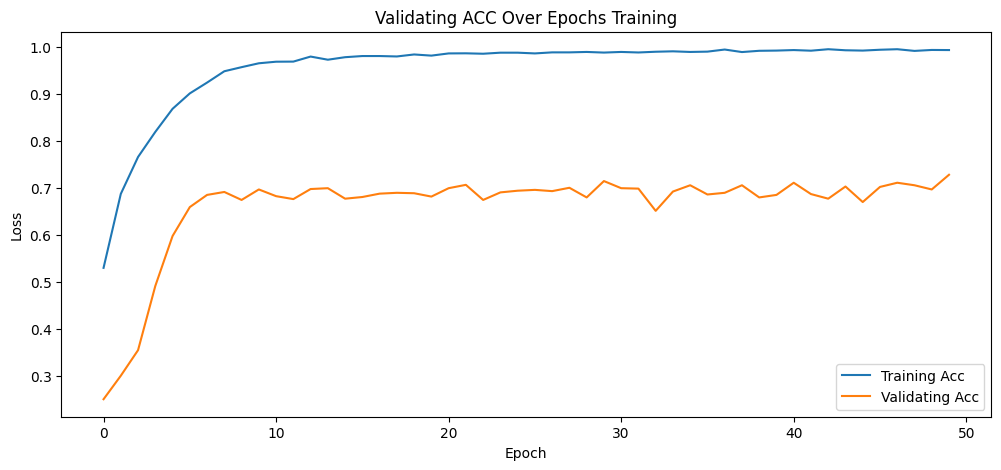

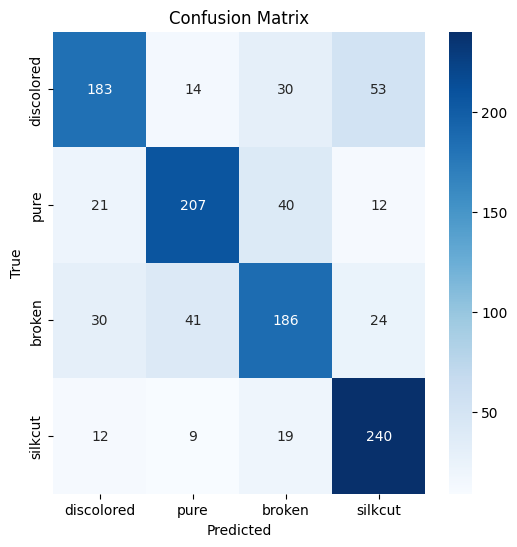

Waktu : 45.86978791952133
Loss : 2.8798428012263964
Accuracy : 0.727921498661909
Precision : 0.7283967584371567
Recall : 0.7279804199934006
F1-score : 0.7261051833629608
fold ke-4


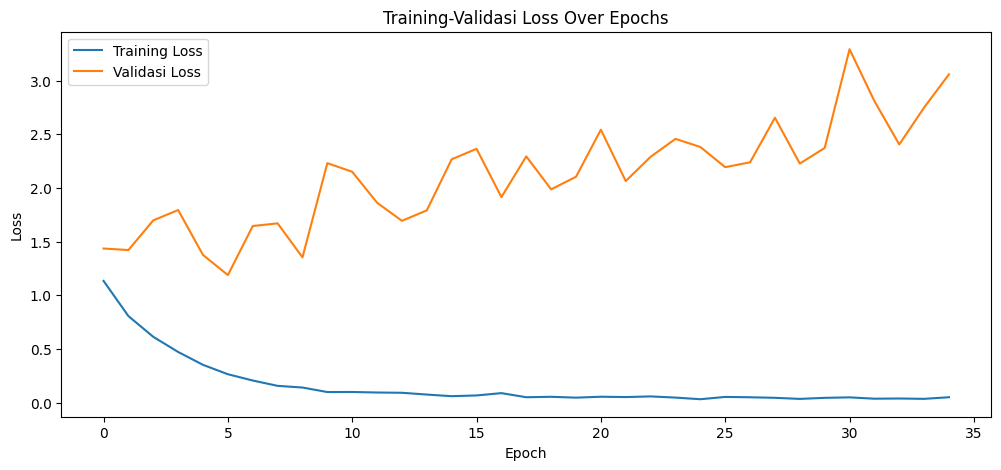

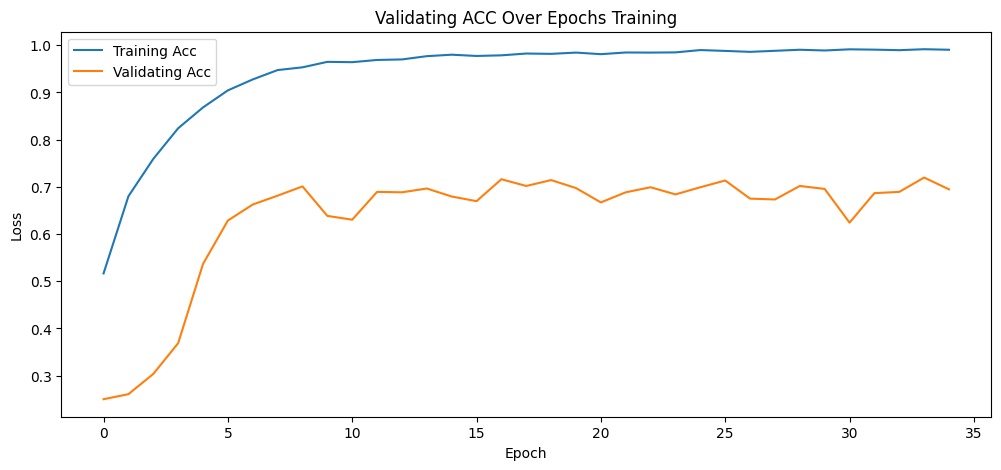

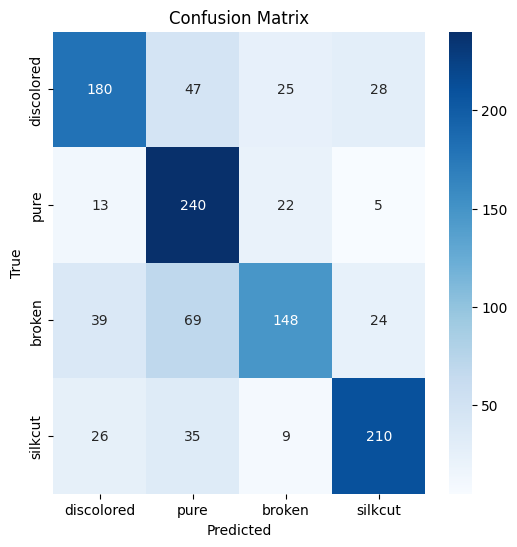

Waktu : 32.120601960023244
Loss : 3.0602871656417845
Accuracy : 0.6946428571428571
Precision : 0.705873042345047
Recall : 0.6946428567171097
F1-score : 0.6909724622964859
Model Terbaik adalah model pada fold ke-3


In [ ]:
model = EfficientNetClassification("b1")
sistem = ClassificationNonDS(model,50)
sistem.can_predict()

### Testing

In [ ]:
data_test = write_cachedImg(args['testing_nds'])
x_test, y_test = Resize(data_test['images'], (240,240)), data_test['class']
print("Testing size", x_test.size())

Testing size torch.Size([1400, 240, 240, 3])


Hasil Testing


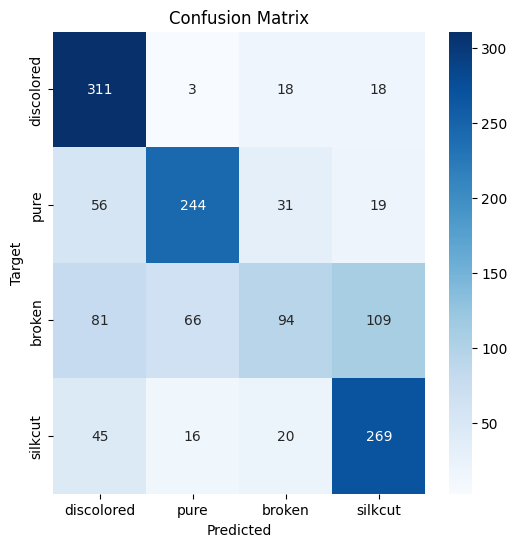

Loss : 3.7712069397622887
Accuracy : 0.6557142857142857
Precision : 0.6493382155895233
Recall : 0.65571428835392
F1-score : 0.6315711811184883


In [ ]:
sistem.predict(x_test.to(torch.float32), y_test, 'cpu')

## Skenario 3

### Training - Val Fold ke-1

In [ ]:
k=0
data_train, data_val = write_cachedImg(args['train_val']+f"train_nonds_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_nonds_fold_{k}.pkl")
data_train['images'], data_val['images'] = Resize(data_train['images'], (260,260)), Resize(data_val['images'], (260,260))
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([4483, 260, 260, 3])
Validation size torch.Size([1121, 260, 260, 3])


In [ ]:
model = EfficientNetClassification("b2")
sistem = ClassificationNonDS(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 201MB/s] 


Loaded pretrained weights for efficientnet-b2
fold ke-0
Epoch : 1 train loss : 1.1200490027454728 train acc : 0.519518179790319 val loss : 1.395804054207272 val acc : 0.24977698483496877 
Menyimpan Model
Epoch : 2 train loss : 0.8019613306573097 train acc : 0.6821325005576623 val loss : 1.3963350620534685 val acc : 0.24977698483496877 
Menyimpan Model
Epoch : 3 train loss : 0.6189866672593651 train acc : 0.7653357126923935 val loss : 1.456292298105028 val acc : 0.2711864406779661 
Menyimpan Model
Epoch : 4 train loss : 0.46384431453461344 train acc : 0.8251171090787419 val loss : 1.6445549991395738 val acc : 0.4094558429973238 
Menyimpan Model
Epoch : 5 train loss : 0.3415310538195549 train acc : 0.8795449475797457 val loss : 1.5293350617090862 val acc : 0.48349687778768957 
Menyimpan Model
Epoch : 6 train loss : 0.2516653410403441 train acc : 0.9103279054204774 val loss : 1.3568175914891374 val acc : 0.6012488849241748 
Menyimpan Model
Epoch : 7 train loss : 0.18206624090935744 train 

### Training - Val Fold ke-2

In [ ]:
k=1
data_train, data_val = write_cachedImg(args['train_val']+f"train_nonds_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_nonds_fold_{k}.pkl")
data_train['images'], data_val['images'] = Resize(data_train['images'], (260,260)), Resize(data_val['images'], (260,260))
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([4483, 260, 260, 3])
Validation size torch.Size([1121, 260, 260, 3])


In [ ]:
model = EfficientNetClassification("b2")
sistem = ClassificationNonDS(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Loaded pretrained weights for efficientnet-b2
fold ke-1
Epoch : 1 train loss : 1.1090476216999352 train acc : 0.5293330359134508 val loss : 1.4260758227772183 val acc : 0.24977698483496877 
Menyimpan Model
Epoch : 2 train loss : 0.7918034631309779 train acc : 0.6883783180905644 val loss : 1.4565390116638608 val acc : 0.24977698483496877 
Menyimpan Model
Epoch : 3 train loss : 0.6142878481682311 train acc : 0.7702431407539594 val loss : 1.499808328019248 val acc : 0.24977698483496877 
Menyimpan Model
Epoch : 4 train loss : 0.46461763280503293 train acc : 0.8251171090787419 val loss : 2.3159161508083344 val acc : 0.34611953612845675 
Menyimpan Model
Epoch : 5 train loss : 0.3398873523828831 train acc : 0.8813294668748606 val loss : 1.3753009753094778 val acc : 0.567350579839429 
Menyimpan Model
Epoch : 6 train loss : 0.2523699510604777 train acc : 0.9063127370064689 val loss : 1.3154740393349331 val acc : 0.6181980374665478 
Menyimpan Model
Epoch : 7 train loss : 0.18592299114093713 trai

### Training - Val Fold ke-3

In [ ]:
k=2
data_train, data_val = write_cachedImg(args['train_val']+f"train_nonds_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_nonds_fold_{k}.pkl")
data_train['images'], data_val['images'] = Resize(data_train['images'], (260,260)), Resize(data_val['images'], (260,260))
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([4483, 260, 260, 3])
Validation size torch.Size([1121, 260, 260, 3])


In [ ]:
model = EfficientNetClassification("b2")
sistem = ClassificationNonDS(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Loaded pretrained weights for efficientnet-b2
fold ke-2
Epoch : 1 train loss : 1.0817636014721919 train acc : 0.5413785411554762 val loss : 1.3996226688226063 val acc : 0.24977698483496877 
Menyimpan Model
Epoch : 2 train loss : 0.7747963199801479 train acc : 0.6959625250948026 val loss : 1.394750611649619 val acc : 0.27475468331846564 
Menyimpan Model
Epoch : 3 train loss : 0.5779519493803911 train acc : 0.7809502565246487 val loss : 1.3961675895584955 val acc : 0.3006244424620874 
Menyimpan Model
Epoch : 4 train loss : 0.4579903744425334 train acc : 0.8347089002899843 val loss : 1.3249019450611539 val acc : 0.4130240856378234 
Menyimpan Model
Epoch : 5 train loss : 0.31370983325631907 train acc : 0.8893598037028775 val loss : 1.8377322825706668 val acc : 0.512042818911686 
Menyimpan Model
Epoch : 6 train loss : 0.24117227242136677 train acc : 0.913227749275039 val loss : 1.8566400127278433 val acc : 0.5584299732381802 
Menyimpan Model
Epoch : 7 train loss : 0.19627189769653985 train 

### Training - Val Fold ke-4

In [ ]:
k=3
data_train, data_val = write_cachedImg(args['train_val']+f"train_nonds_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_nonds_fold_{k}.pkl")
data_train['images'], data_val['images'] = Resize(data_train['images'], (260,260)), Resize(data_val['images'], (260,260))
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([4483, 260, 260, 3])
Validation size torch.Size([1121, 260, 260, 3])


In [ ]:
model = EfficientNetClassification("b2")
sistem = ClassificationNonDS(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 180MB/s]


Loaded pretrained weights for efficientnet-b2
fold ke-3
Epoch : 1 train loss : 1.1363478505865057 train acc : 0.5275485166183359 val loss : 1.3873455822467804 val acc : 0.24977698483496877 
Menyimpan Model
Epoch : 2 train loss : 0.8015472299241005 train acc : 0.6859246040597814 val loss : 1.4029739366637335 val acc : 0.25066904549509367 
Menyimpan Model
Epoch : 3 train loss : 0.6091325073800189 train acc : 0.7711354004015168 val loss : 1.4035022192531161 val acc : 0.3113291703835861 
Menyimpan Model
Epoch : 4 train loss : 0.4543207773925565 train acc : 0.8324782511710908 val loss : 1.739814453654819 val acc : 0.3818019625334523 
Menyimpan Model
Epoch : 5 train loss : 0.32756685700386445 train acc : 0.879768012491635 val loss : 1.6252917481793299 val acc : 0.5325602140945584 
Menyimpan Model
Epoch : 6 train loss : 0.2655525759179541 train acc : 0.915681463305822 val loss : 1.5251073902472854 val acc : 0.5798394290811775 
Menyimpan Model
Epoch : 7 train loss : 0.19112966352320732 train a

### Training - Val Fold ke-5

In [ ]:
k=4
data_train, data_val = write_cachedImg(args['train_val']+f"train_nonds_fold_{k}.pkl"), write_cachedImg(args['train_val']+f"val_nonds_fold_{k}.pkl")
data_train['images'], data_val['images'] = Resize(data_train['images'], (260,260)), Resize(data_val['images'], (260,260))
print("Training size", data_train['images'].size())
print("Validation size", data_val['images'].size())

Training size torch.Size([4484, 260, 260, 3])
Validation size torch.Size([1120, 260, 260, 3])


In [ ]:
model = EfficientNetClassification("b2")
sistem = ClassificationNonDS(model,50)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'], data_val['images'].to(torch.float32), data_val['class'], k, "cuda")

Loaded pretrained weights for efficientnet-b2
fold ke-4
Epoch : 1 train loss : 1.1145372614792899 train acc : 0.52921498661909 val loss : 1.3896620614188058 val acc : 0.25 
Menyimpan Model
Epoch : 2 train loss : 0.795925147567235 train acc : 0.682649420160571 val loss : 1.3928115231650215 val acc : 0.25 
Menyimpan Model
Epoch : 3 train loss : 0.6214250493134167 train acc : 0.7638269402319358 val loss : 1.4039093392235893 val acc : 0.24464285714285713 
Menyimpan Model
Epoch : 4 train loss : 0.46080769302574454 train acc : 0.8293933987511151 val loss : 1.3836236000061035 val acc : 0.44821428571428573 
Menyimpan Model
Epoch : 5 train loss : 0.3460905391802179 train acc : 0.8773416592328278 val loss : 1.3818577766418456 val acc : 0.5625 
Menyimpan Model
Epoch : 6 train loss : 0.26983308697000463 train acc : 0.9114629794826048 val loss : 1.9311519043786185 val acc : 0.5758928571428571 
Menyimpan Model
Epoch : 7 train loss : 0.17692724427749926 train acc : 0.9388938447814451 val loss : 1.290

### Memilih Model Terbaik

Loaded pretrained weights for efficientnet-b2
fold ke-0


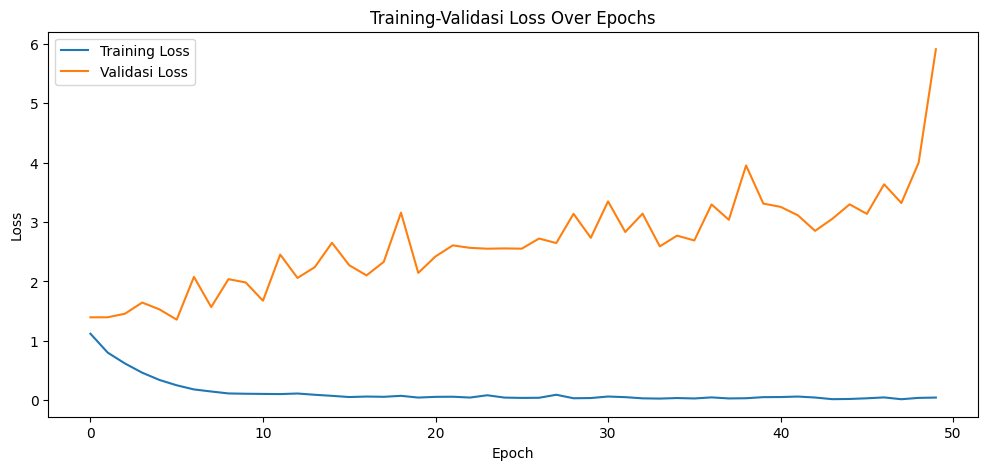

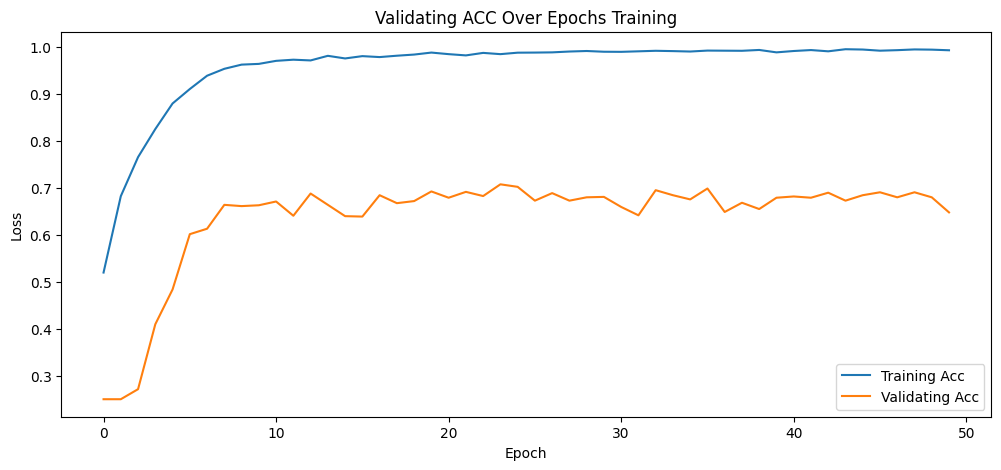

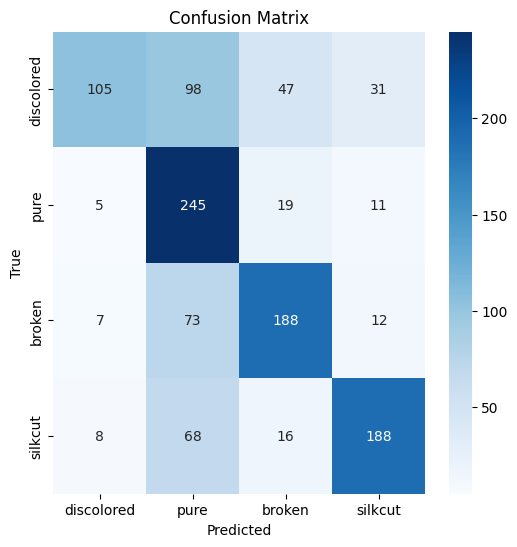

Waktu : 58.99532039960226
Loss : 5.908241735564338
Accuracy : 0.647636039250669
Precision : 0.7048385292291641
Recall : 0.6478806510567665
F1-score : 0.6406363546848297
fold ke-1


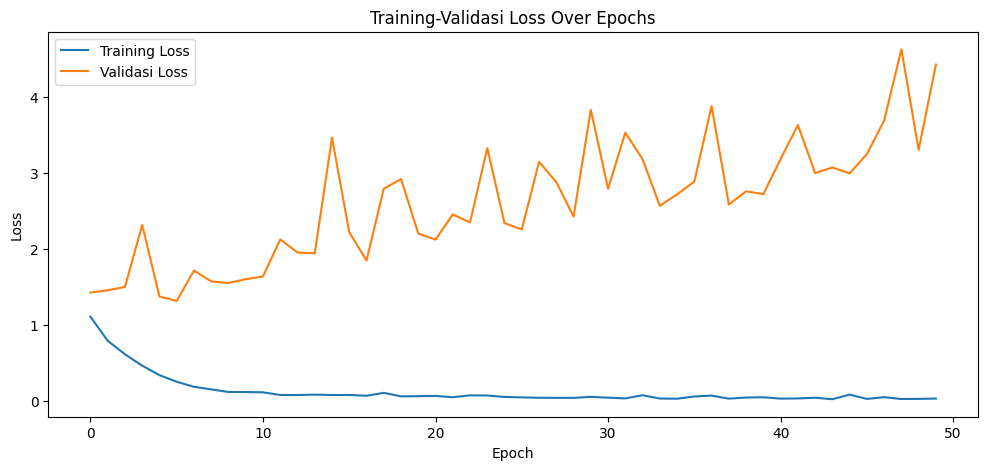

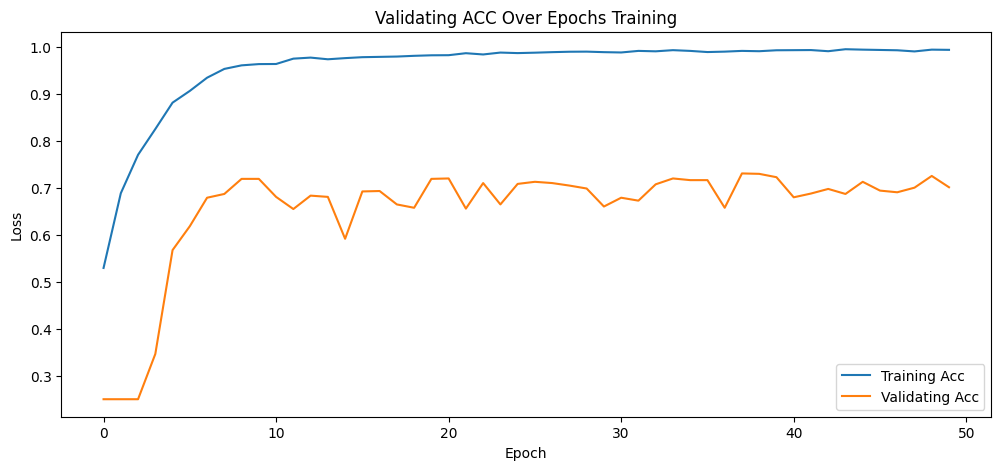

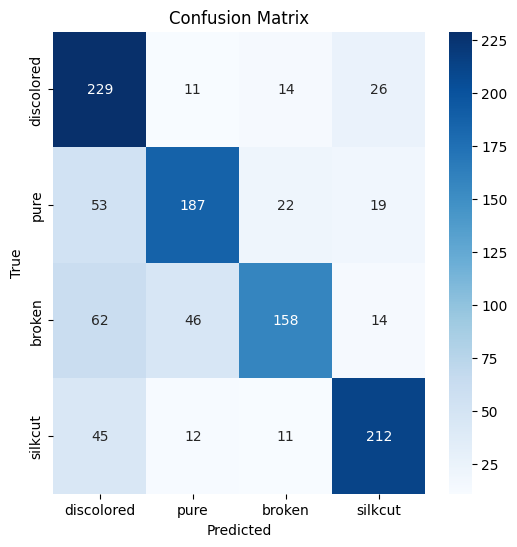

Waktu : 59.01751518249512
Loss : 4.426511224773195
Accuracy : 0.7011596788581623
Precision : 0.7180443108081818
Recall : 0.7011915296316147
F1-score : 0.700530543923378
fold ke-2


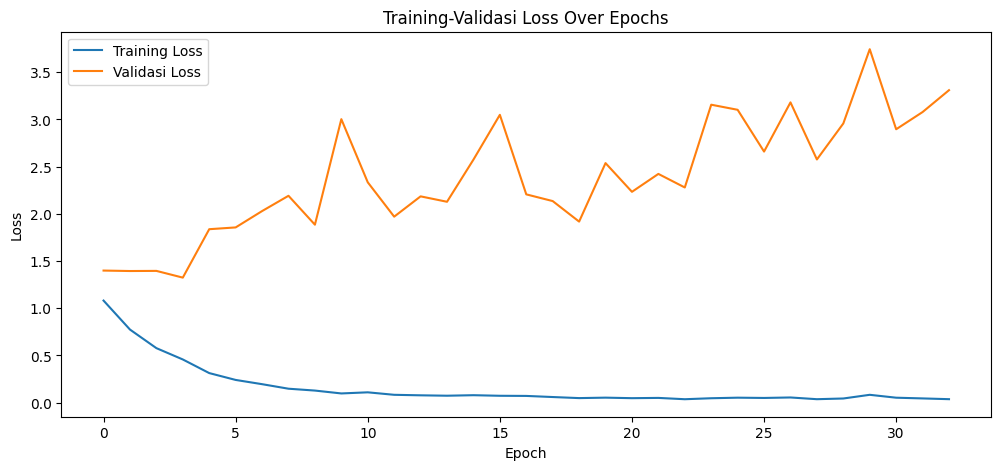

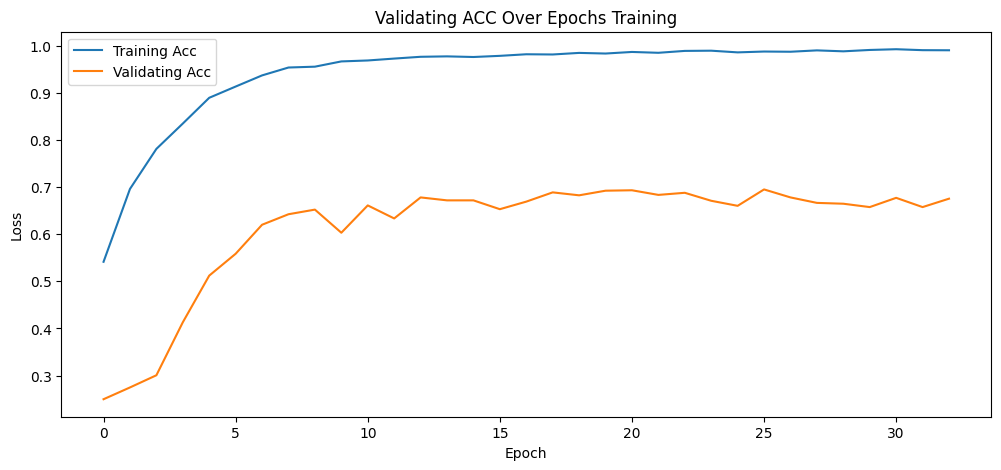

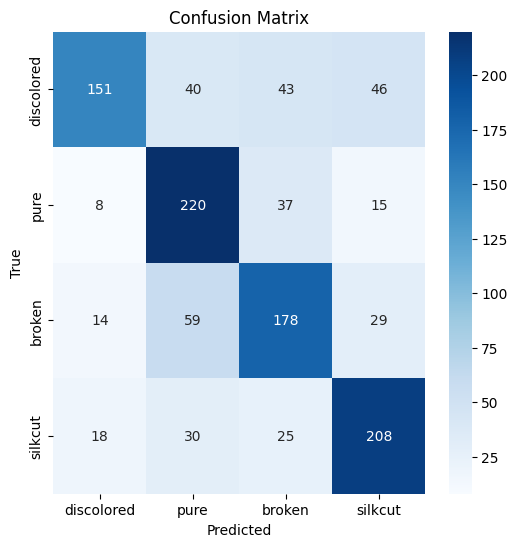

Waktu : 38.9726767261823
Loss : 3.3102704336245856
Accuracy : 0.6752899197145406
Precision : 0.6869775652885437
Recall : 0.6752319484949112
F1-score : 0.6728797554969788
fold ke-3


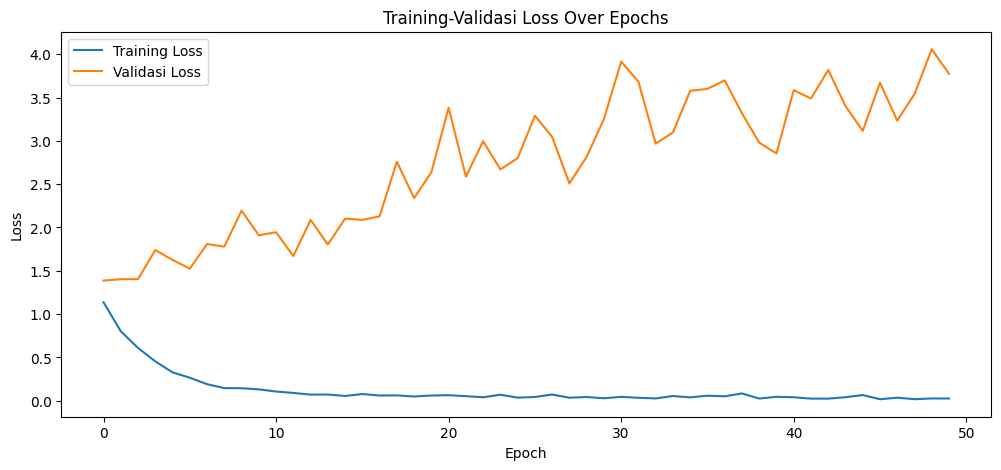

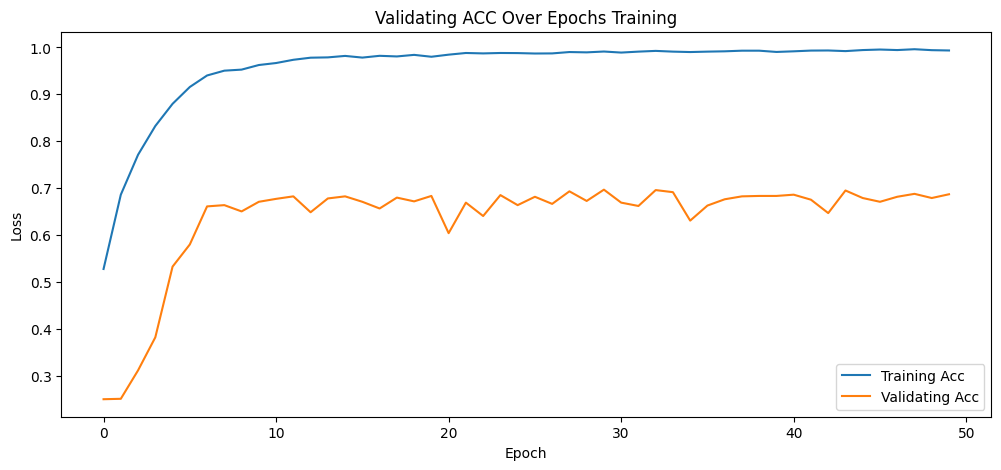

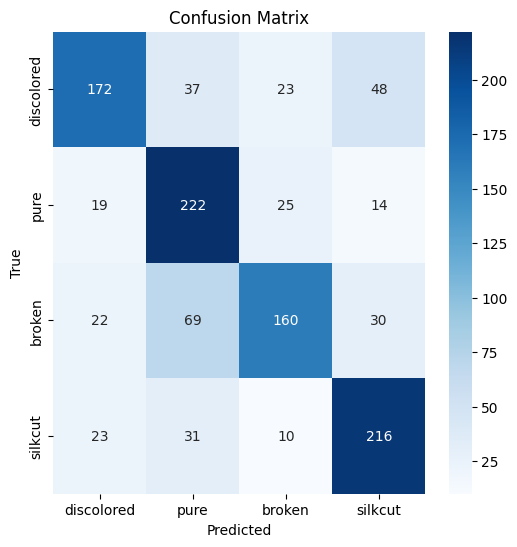

Waktu : 60.74355359077454
Loss : 3.775388773944643
Accuracy : 0.6868867082961642
Precision : 0.6956104189157486
Recall : 0.6869916170835495
F1-score : 0.6843697130680084
fold ke-4


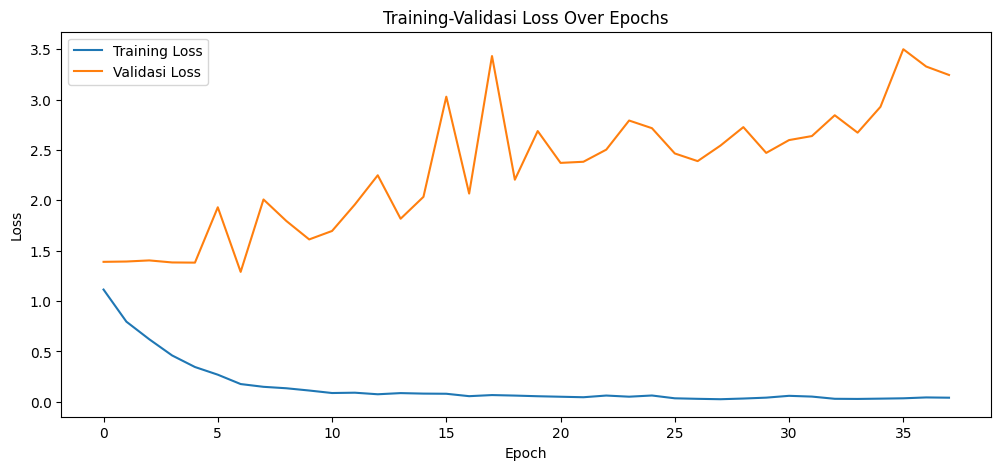

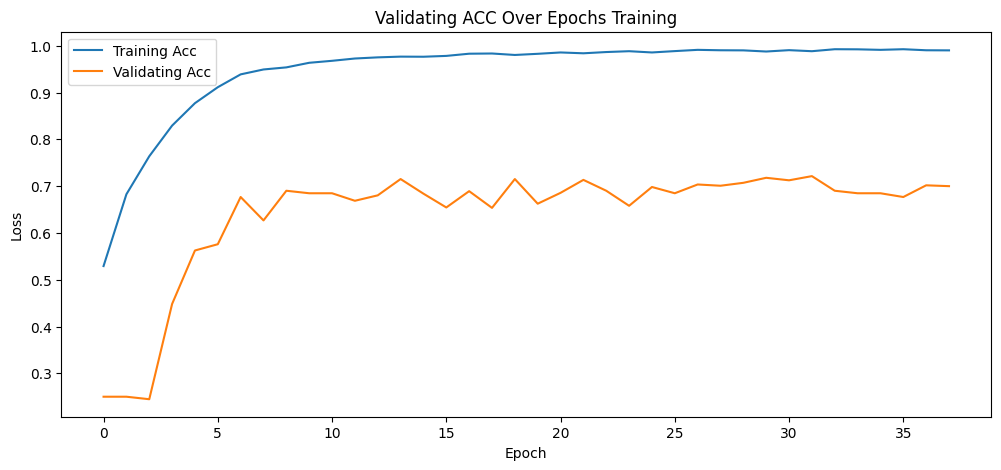

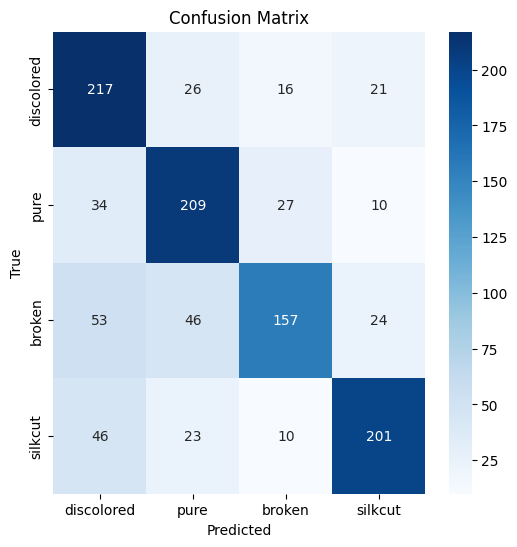

Waktu : 46.17502468029658
Loss : 3.2441007614135744
Accuracy : 0.7
Precision : 0.7100688219070435
Recall : 0.699999988079071
F1-score : 0.6988646537065506
Model Terbaik adalah model pada fold ke-1


In [ ]:
model = EfficientNetClassification("b2")
sistem = ClassificationNonDS(model,50)
sistem.can_predict()

### Testing

In [ ]:
data_test = write_cachedImg(args['testing_nds'])
x_test, y_test = Resize(data_test['images'], (260,260)), data_test['class']
print("Testing size", x_test.size())

Testing size torch.Size([1400, 260, 260, 3])


Hasil Testing


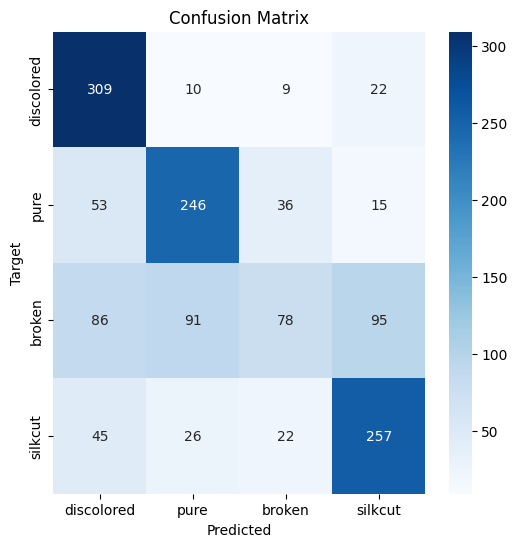

Loss : 4.564524775201624
Accuracy : 0.6357142857142857
Precision : 0.6212229132652283
Recall : 0.6357142850756645
F1-score : 0.6060699820518494


In [ ]:
sistem.predict(x_test.to(torch.float32), y_test, 'cpu')

# _____________________________________________________________________________

# Cooretan

In [ ]:
# def Resize(batchImg,size):
print(data_train['images'].size())
size = (240,240)
data_resize = Resize(data_train['images'].to(torch.float32), size)
data_resize = {'images': data_resize.to(torch.float16), 'class': data_train['class']}

In [ ]:
save_cachedImg(args['training240'],data_resize)

berhasil menyimpan pkl drive/MyDrive/dataset/batch_img/data_train240.pkl


resize data testing

In [ ]:
print(data_test['images'].size())
size = (240,240)
data_resize = Resize(data_test['images'].to(torch.float32), size)
data_resize = {'images': data_resize.to(torch.float16), 'class': data_test['class']}

In [ ]:
save_cachedImg(args['testing240'],data_resize)

berhasil menyimpan pkl drive/MyDrive/dataset/batch_img/data_test240.pkl


In [ ]:
data_train = write_cachedImg(args['training240'])

In [ ]:
xtrain, xtest, ytrain, ytest = splitting_data(data_train['images'], data_train['class'], 0.2)

In [ ]:
xtrain.size()

torch.Size([11200, 240, 240, 3])

In [ ]:
a =[1,2,3,4]
b = [2,3,4]
a.extend(b)
a

[1, 2, 3, 4, 2, 3, 4]

In [ ]:
model = EfficientNet("b0")
summary(model.to('cuda'), (3,224,224))
# fit(self, X,y,xval,yval,k, device)

RuntimeError: ignored

In [ ]:
sistem = Classification(model,10)
sistem.fit(xtrain.to(torch.float32), ytrain, xtest.to(torch.float32), ytest, 0,'cuda')

fold ke-0
Epoch : 1 train loss : 1.2257510310411452 train acc : 0.377578125 val loss : 1.7542896223068238 val acc : 0.3940625 
Menyimpan Model
Epoch : 2 train loss : 1.2017666149139403 train acc : 0.384921875 val loss : 1.2235825896263122 val acc : 0.403125 
Menyimpan Model
Epoch : 3 train loss : 1.176293605864048 train acc : 0.428046875 val loss : 1.6639620161056519 val acc : 0.4225 
Menyimpan Model
Epoch : 4 train loss : 1.0325752273201942 train acc : 0.53609375 val loss : 1.1966618633270263 val acc : 0.5246875 
Menyimpan Model
Epoch : 5 train loss : 0.9894276118278503 train acc : 0.55796875 val loss : 1.0294807970523834 val acc : 0.548125 
Menyimpan Model
Epoch : 6 train loss : 0.9449325859546661 train acc : 0.58484375 val loss : 1.0874375784397126 val acc : 0.515 
Menyimpan Model
Epoch : 7 train loss : 0.9136831051111222 train acc : 0.601015625 val loss : 1.1779018473625182 val acc : 0.4928125 
Menyimpan Model
Epoch : 8 train loss : 0.8998666048049927 train acc : 0.597890625 val lo

In [ ]:
model = EfficientNet('b0')
# sistem = Classification(model, 40)

block ke- 0
block ke- 0
block ke- 1
block ke- 0
block ke- 1
block ke- 0
block ke- 1
block ke- 2
block ke- 0
block ke- 1
block ke- 2
block ke- 0
block ke- 1
block ke- 2
block ke- 3
block ke- 0


## New EfficientNet

#### TRY Training

In [ ]:
# fit with param X,y, Xval,yval, k,device
# X_train, X_test, y_train, y_test
sistem = Classification(model,100)
sistem.fit(data_train['images'].to(torch.float32), data_train['class'],'cuda')

fold ke-0
Epoch : 1 train loss : 78.53145034790039 acc : 0.42875000834465027 precision : 0.4331585466861725 recall : 0.4287499971687794 f1 : 0.41008032113313675
Menyimpan Model
Epoch : 2 train loss : 66.69237438201904 acc : 0.5418750047683716 precision : 0.5750537514686584 recall : 0.5418750010430813 f1 : 0.5159842222929001
Menyimpan Model
Epoch : 3 train loss : 54.225625915527345 acc : 0.5809375047683716 precision : 0.5907937586307526 recall : 0.5809375047683716 f1 : 0.5803569331765175
Menyimpan Model
Epoch : 4 train loss : 40.55332332611084 acc : 0.5512499809265137 precision : 0.5807897076010704 recall : 0.5512500181794167 f1 : 0.5457966849207878
Menyimpan Model
Epoch : 5 train loss : 28.41085852622986 acc : 0.5562499761581421 precision : 0.5835957378149033 recall : 0.5562500059604645 f1 : 0.5561587363481522
Menyimpan Model
Epoch : 6 train loss : 20.47158344745636 acc : 0.567187488079071 precision : 0.5855690762400627 recall : 0.5671875029802322 f1 : 0.5692488253116608
Menyimpan Mode

In [ ]:
stats = sistem.fold_stats

In [ ]:
stats[0]['perform'][0][4]

tensor([[520,  39,  61, 180],
        [325, 135, 287,  53],
        [502,  63, 215,  20],
        [ 82, 121,  95, 502]])

fold ke-0


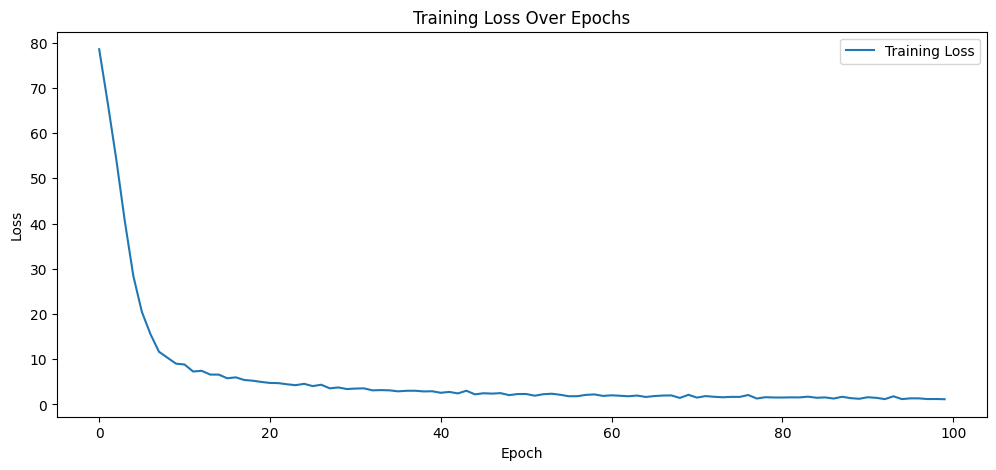

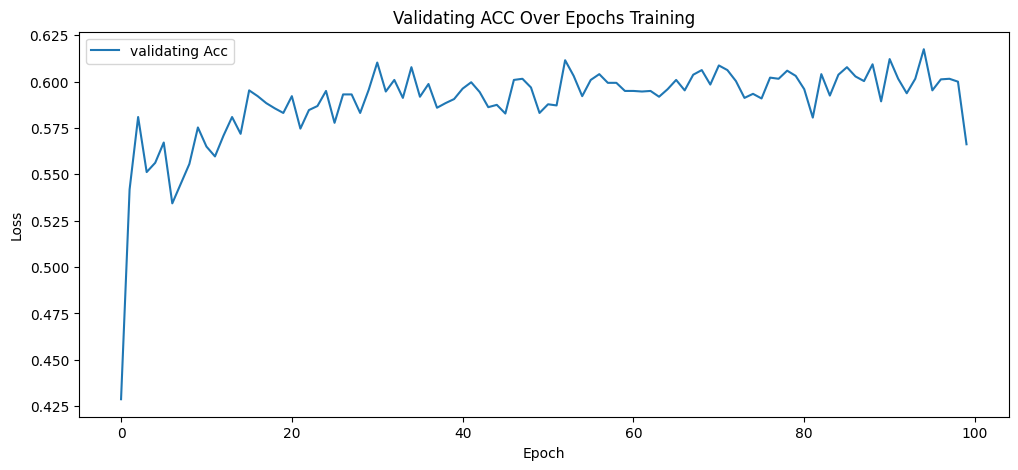

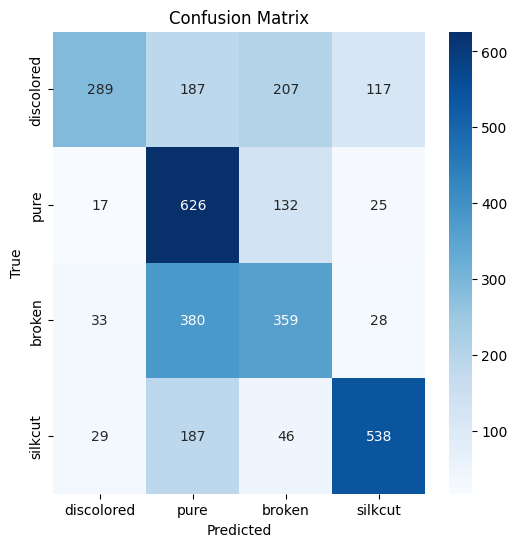

Accuracy : 0.5662500262260437
Precision : 0.6203407719731331
Recall : 0.5662500113248825
F1-score : 0.5619321838021278
fold ke-1


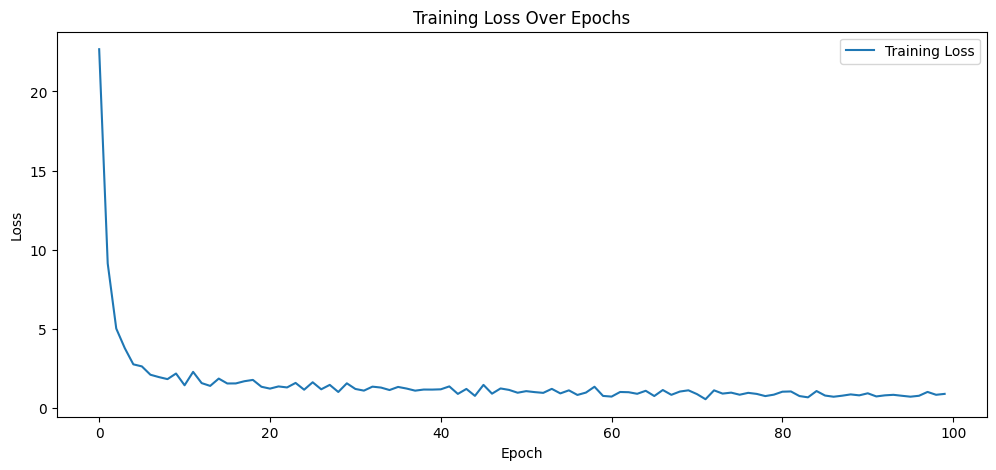

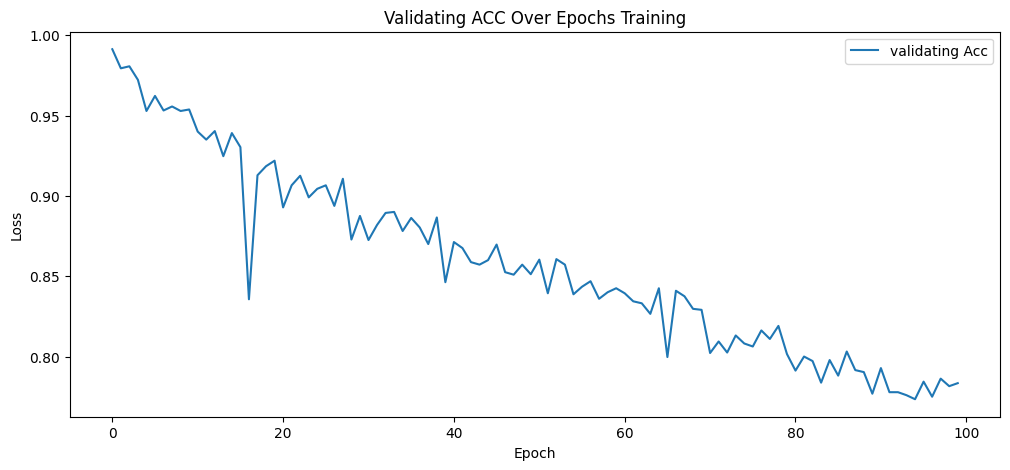

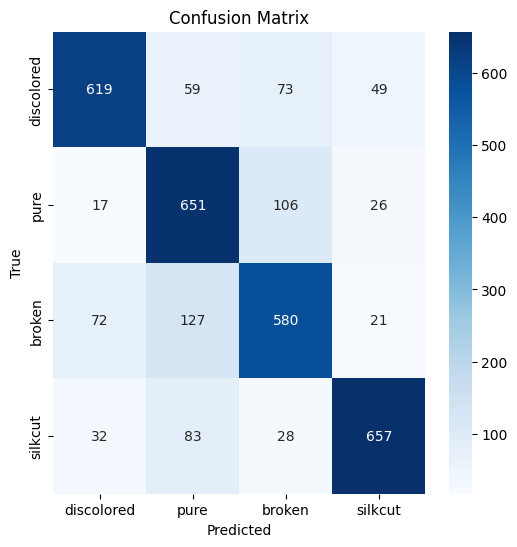

Accuracy : 0.7834374904632568
Precision : 0.7883952409029007
Recall : 0.7834375202655792
F1-score : 0.7844790071249008
fold ke-2


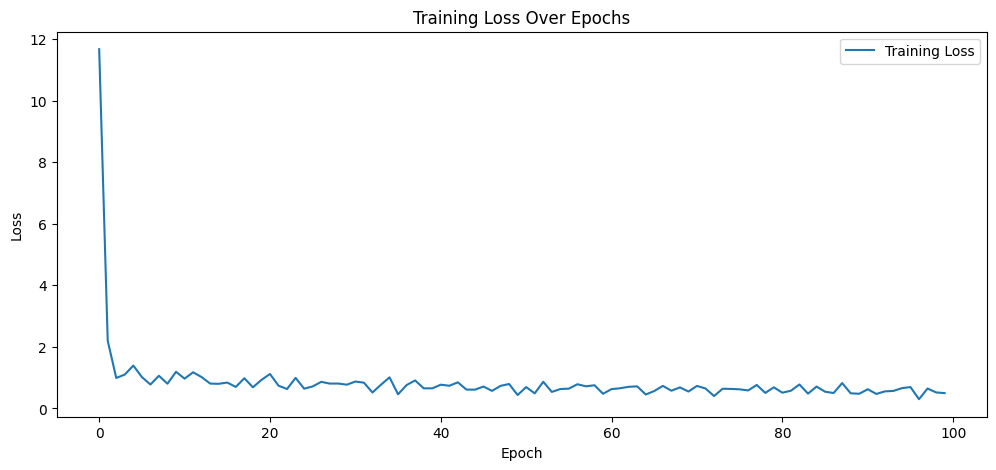

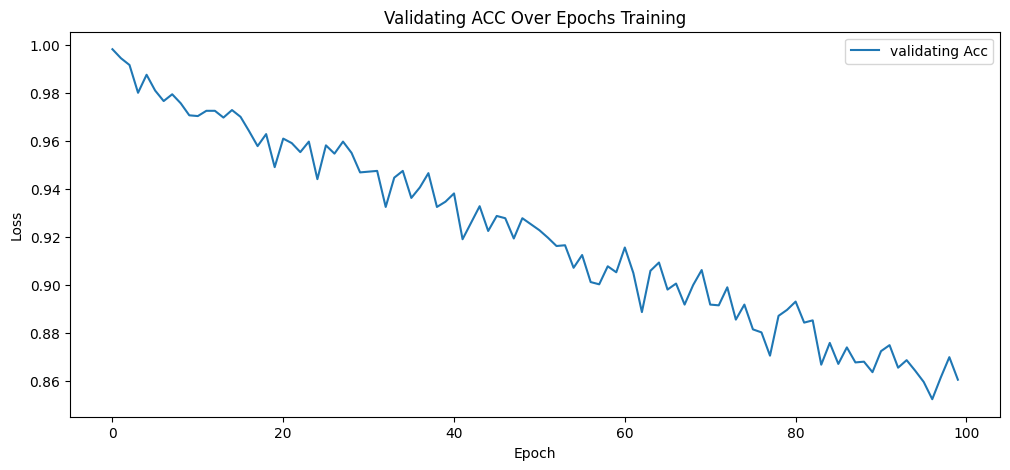

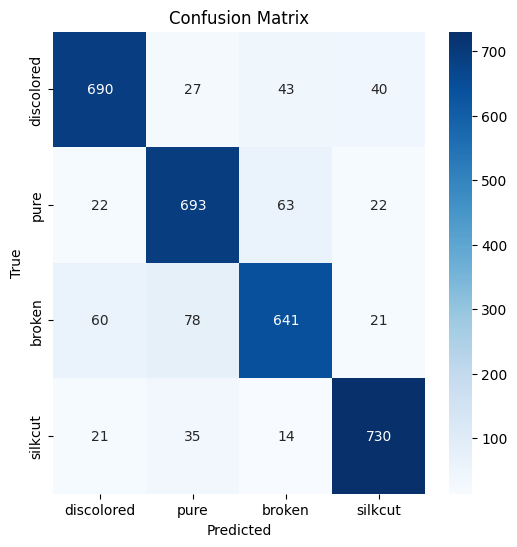

Accuracy : 0.8606250286102295
Precision : 0.8605670034885406
Recall : 0.8606249988079071
F1-score : 0.8603621572256088
fold ke-3


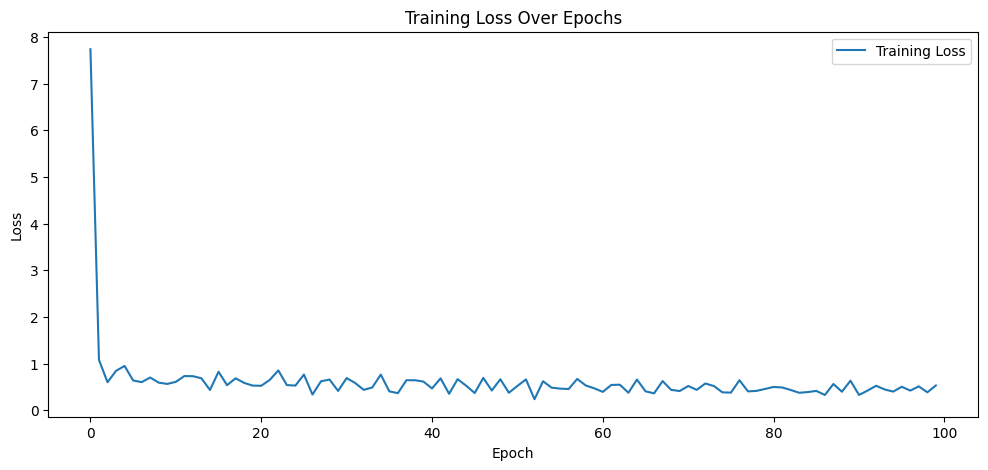

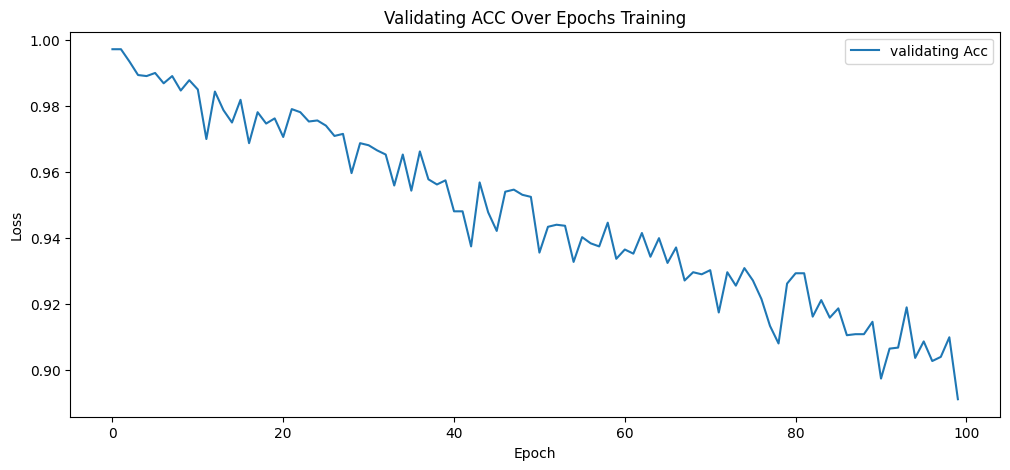

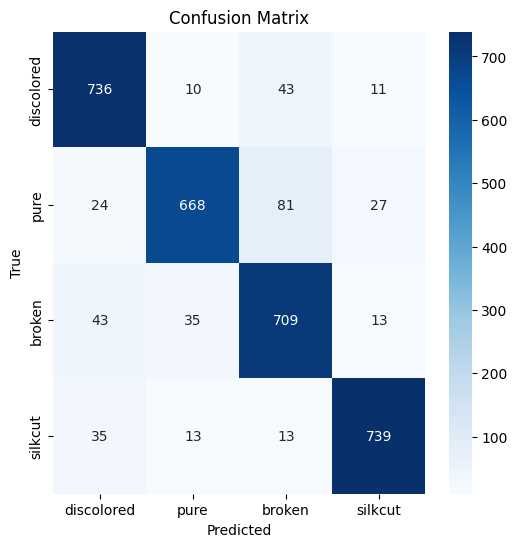

Accuracy : 0.8912500143051147
Precision : 0.8929740637540817
Recall : 0.8912499994039536
F1-score : 0.8912976086139679
fold ke-4


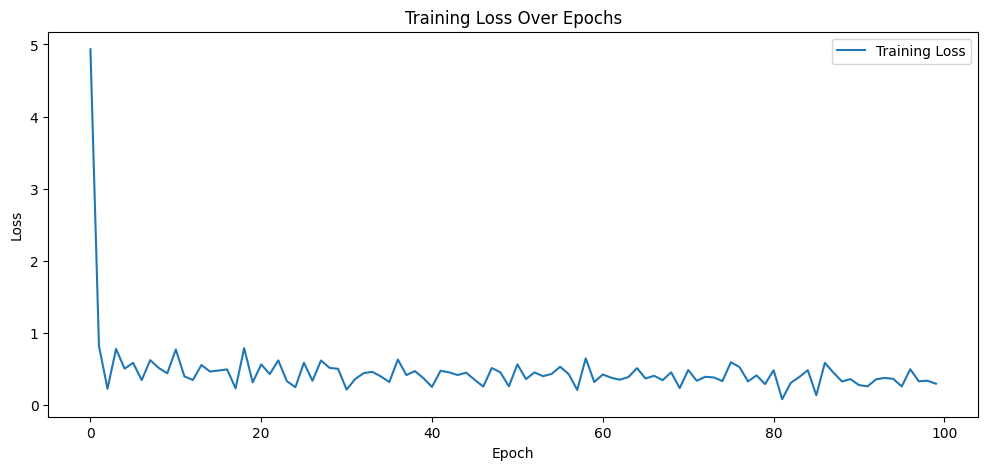

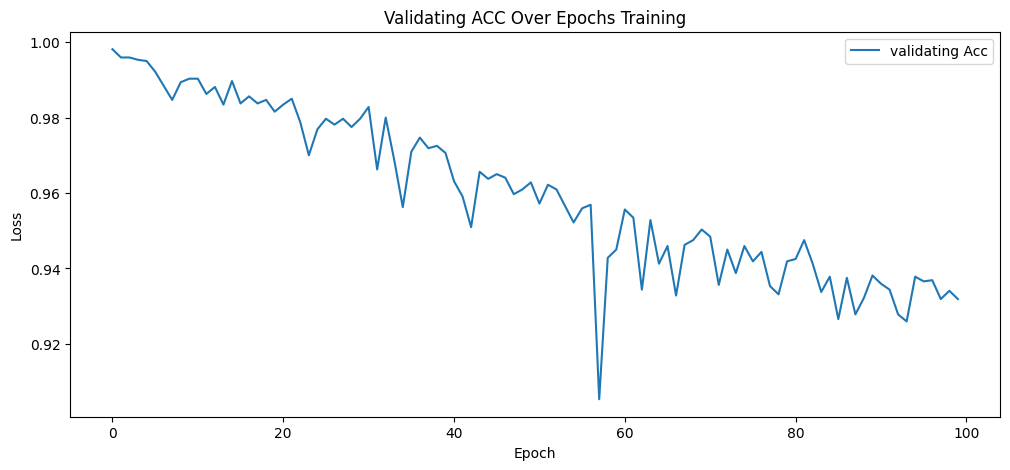

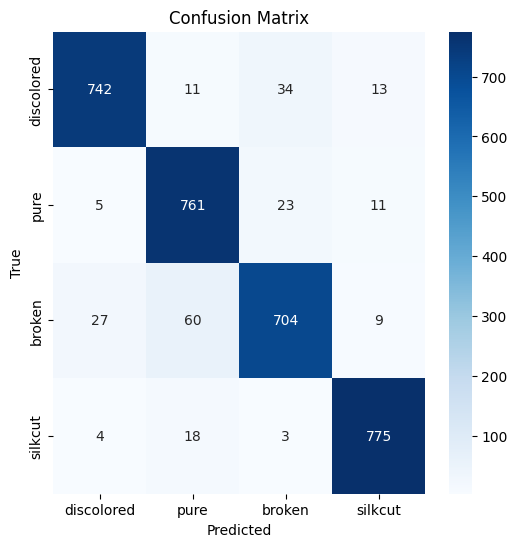

Accuracy : 0.9318749904632568
Precision : 0.9324115067720413
Recall : 0.931875005364418
F1-score : 0.9317603260278702


In [ ]:
for k in (stats):
  print(f"fold ke-{k}")
  acc = []
  for i in range(len(stats[k]['perform'])):
    acc.append(stats[k]['perform'][i][0])

  plt.figure(figsize=(12, 5))
  plt.plot(stats[k]['loss_training'], label='Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss Over Epochs')
  plt.legend()
  plt.show()

  plt.figure(figsize=(12, 5))
  plt.plot(acc, label='validating Acc')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Validating ACC Over Epochs Training')
  plt.legend()
  plt.show()


  plt.figure(figsize=(6, 6))
  sn.heatmap(stats[k]['perform'][-1][4], annot=True, fmt='d', cmap='Blues', xticklabels=args['class'], yticklabels=args['class'])
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

  print(f"Accuracy : {stats[k]['perform'][-1][0]}")
  print(f"Precision : {stats[k]['perform'][-1][1]}")
  print(f"Recall : {stats[k]['perform'][-1][2]}")
  print(f"F1-score : {stats[k]['perform'][-1][3]}")



In [ ]:
dataset = write_cachedImg(args['skripsi'])
xtrain, xval, ytrain, yval = splitting_data(dataset['images'], dataset['class'], 0.2)

In [ ]:
model = EfficientNet('b0')
# summary(model.to('cuda'), (3,224,224))

In [ ]:
sistem = Classification(model,100)
sistem.fit(xtrain.to(torch.float32),ytrain, xval.to(torch.float32), yval,0,'cuda')


fold ke-0
Epoch : 1 train loss : 1.0524223900976635 train acc : 0.5449101796407185 val loss : 1.393021710216999 val acc : 0.25149700598802394 
Menyimpan Model
Epoch : 2 train loss : 0.8231873216610106 train acc : 0.6586826347305389 val loss : 1.534571710973978 val acc : 0.25149700598802394 
Menyimpan Model
Epoch : 3 train loss : 0.6874774748843814 train acc : 0.7180638722554891 val loss : 1.994774241000414 val acc : 0.249500998003992 
Menyimpan Model
Epoch : 4 train loss : 0.5995550671267131 train acc : 0.7594810379241517 val loss : 7.709632724523544 val acc : 0.25249500998003993 
Menyimpan Model
Epoch : 5 train loss : 0.5257197185641244 train acc : 0.8026447105788423 val loss : 5.013780884444714 val acc : 0.37325349301397204 
Menyimpan Model
Epoch : 6 train loss : 0.4672820641407891 train acc : 0.8241017964071856 val loss : 2.1468057138845325 val acc : 0.593812375249501 
Menyimpan Model
Epoch : 7 train loss : 0.38712654747660197 train acc : 0.8522954091816367 val loss : 1.068416393361

In [ ]:
import torch
import math
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
import copy

#width, depth res, dropout
EFFICIENT_PARAMS = {
    'b0' : [1, 1, 224, 0.2],
    'b1' : [1, 1.1, 240, 0.2],
    'b2' : [1.1, 1.2, 260, 0.3]
}

BLOCK_PARAMS = [
    {
        'ex_ratio': 1, 'in_channel': 32, 'out_channel' : 16, 'kernel':3, 'repeat': 1, 'stride':1, 'se_ratio':0.25
    },
    {
        'ex_ratio': 6, 'in_channel': 16, 'out_channel' : 24, 'kernel':3, 'repeat': 2, 'stride':2, 'se_ratio':0.25
    },
    {
        'ex_ratio': 6, 'in_channel': 24, 'out_channel' : 40, 'kernel':5, 'repeat': 2, 'stride':2, 'se_ratio':0.25
    },
    {
        'ex_ratio': 6, 'in_channel': 40, 'out_channel' : 80, 'kernel':3, 'repeat': 3, 'stride':2, 'se_ratio':0.25
    },
    {
        'ex_ratio': 6, 'in_channel': 80, 'out_channel' : 112, 'kernel':5, 'repeat': 3, 'stride':1, 'se_ratio':0.25
    },
    {
        'ex_ratio': 6, 'in_channel': 112, 'out_channel' : 192, 'kernel':5, 'repeat': 4, 'stride':2, 'se_ratio':0.25
    },
    {
        'ex_ratio': 6, 'in_channel': 192, 'out_channel' : 320, 'kernel':3, 'repeat': 1, 'stride':1, 'se_ratio':0.25
    },
]

GLOBAL_PARAMS = {
    'width_coef': None,'depth_coef': None, 'image_size':None,'res': None, 'num_class' :4, 'batch_norm_momentum': 0.99,
    'batch_norm_eps': 1e-5, 'drop_connect_rate': None, 'depth_divisor':8, 'mindepth':None
}

def round_channel(channel, global_params):

    multiplier = global_params['width_coef']
    divisor = global_params['depth_divisor']
    min_depth = global_params['mindepth']
    channel *= multiplier
    min_depth = min_depth or divisor  # pay attention to this line when using min_depth
    # follow the formula transferred from official TensorFlow implementation
    new_filters = max(min_depth, int(channel + divisor / 2) // divisor * divisor)
    if new_filters < 0.9 * channel:  # prevent rounding by more than 10%
        new_filters += divisor
    return int(new_filters)

def round_repeats(repeat, global_params):
    repeat *=global_params['depth_coef']
    return int(math.ceil(repeat))

#for drop connect and stochastic depth
def drop_connect(inputs, prob, training):
    if not training:
        return inputs
    batch_size = inputs.size(0)
    keep_prob = 1-prob

    random_tensor = keep_prob
    random_tensor += torch.rand(inputs.size(), dtype=inputs.dtype, device=inputs.device)
    binary_tensor = torch.floor(random_tensor)

    return inputs / keep_prob * binary_tensor

def get_size(x):
    if isinstance(x, int):
        return x, x
    if isinstance(x, list) or isinstance(x, tuple):
        return x

def calc_output_img(input_image_size, stride):

    if input_image_size is None:
        return None
    image_height, image_width = get_size(input_image_size)
    stride = stride if isinstance(stride, int) else stride[0]
    image_height, image_width = int(math.ceil(image_height / stride)), int(math.ceil(image_width / stride))

    return [image_height, image_width]

def get_same_padding_conv2d(image_size=None):
    if image_size is None:
        return Conv2dDynamicPaddingSame
    else:
        return partial(Conv2dStaticPaddingSame, image_size=image_size)

class Conv2dDynamicPaddingSame(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

    def forward(self, x):
        ih, iw = x.size()[-2:]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)  # change the output size according to stride ! ! !
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, [pad_w // 2, pad_w - pad_w// 2,
                          pad_h // 2, pad_h - pad_h// 2])
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

class Conv2dStaticPaddingSame(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, image_size=None, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, stride, **kwargs)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

        # Calculate padding based on image size and save it
        # assert image_size is not None
        ih, iw = (image_size, image_size) if isinstance(image_size, int) else image_size
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            self.static_padding = nn.ZeroPad2d((pad_w // 2, pad_w - pad_w // 2,
                                                pad_h // 2, pad_h - pad_h // 2))
        else:
            self.static_padding = nn.Identity()

    def forward(self, x):
        x = self.static_padding(x)
        # print('static',x.size())
        x = F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        return x

class MBConv(nn.Module):
    # 'ex_ratio' 'in_channel' 'out_channel' 'kernel', 'repeat', 'stride', 'se_ratio'
    def __init__(self, block_args, global_params, image_size=None):
        super(MBConv, self).__init__()
        self._block_args = block_args
        self._bn_momentum = 1 - global_params['batch_norm_momentum']
        self._bn_epsilon = global_params['batch_norm_eps']
        self.has_se = 0 < self._block_args['se_ratio'] <=1

        #expansion
        in_channel = self._block_args['in_channel']
        out_channel = self._block_args['in_channel'] * self._block_args['ex_ratio']

        if self._block_args['ex_ratio']!=1:
            Conv2d = get_same_padding_conv2d(image_size)
            self._expand_conv = Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=1, bias=False)
            self._bn_expand = nn.BatchNorm2d(out_channel, momentum=self._bn_momentum, eps=self._bn_epsilon)
            # image_size = calc_output_img(image_size, 1)

        # depthwise
        k=self._block_args['kernel']
        s=self._block_args['stride']
        Conv2d=get_same_padding_conv2d(image_size)
        self._depthwise_conv = Conv2d(out_channel, out_channel, groups=out_channel, kernel_size = k, stride=s, bias=False)

        self._bn1 = nn.BatchNorm2d(out_channel, momentum=self._bn_momentum, eps=self._bn_epsilon)
        image_size =calc_output_img(image_size, s)

        #SE
        if self.has_se:
            Conv2d = get_same_padding_conv2d(image_size=(1,1))
            squeezed_channel = max(1, int(self._block_args['in_channel']*self._block_args['se_ratio']))
            self._global_avg_pool = nn.AdaptiveAvgPool2d(1)
            self._se_reduce = Conv2d(in_channels = out_channel, out_channels=squeezed_channel, kernel_size = 1)
            self._se_expand = Conv2d(in_channels = squeezed_channel, out_channels=out_channel, kernel_size = 1)
            self._sigmoid = nn.Sigmoid()

        #pointwise
        last_channel = self._block_args['out_channel']
        Conv2d = get_same_padding_conv2d(image_size=image_size)
        self._pointwise_conv = Conv2d(in_channels = out_channel, out_channels = last_channel, kernel_size = 1, bias=False)
        self._bn2 = nn.BatchNorm2d(last_channel, momentum=self._bn_momentum, eps=self._bn_epsilon)
        self._swish = nn.SiLU()

        #skip conn
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channel, last_channel, 1,s,bias = False),
            nn.BatchNorm2d(last_channel, momentum=self._bn_momentum, eps=self._bn_epsilon))

    # def adjust_dimensions(self, x, output_block):
    #     if x.shape[1]!=output_block.shape[1]:
    #         channel_padding = output_block.shape[1] - x.shape[1]
    #         adjusted_x = F.pad(x, (0, 0, 0, 0, 0, channel_padding))
    #         return F.interpolate(adjusted_x, size=output_block.shape[2:], mode='nearest')
    #     elif x.shape[2:]!=output_block.shape[2:]:
    #         return F.interpolate(x, size=output_block.shape[2:], mode='nearest')
    #     else:
    #         return x


    def forward(self, inputs, drop_connect_rate=None):
        x=inputs
        #expansion
        if self._block_args['ex_ratio']!=1:
            x = self._swish(self._bn_expand(self._expand_conv(inputs)))
            # print("ex=6", x.size())
        #depthwise
        x = self._swish(self._bn1(self._depthwise_conv(x)))
        # print("dept", x.size())

        #Squeeze and Excitation
        if self.has_se:
            x_pool = self._global_avg_pool(x)
            x_squeeze = self._swish(self._se_reduce(x_pool))
            x_excitattion = self._se_expand(x_squeeze)
            x = self._sigmoid(x_excitattion) *x
        # print("se", x.size())

        #pointwise convolution
        x = self._bn2(self._pointwise_conv(x))
        # print("poin", x.size())

        #skip connection and drop connect
        in_channel, out_channel = self._block_args['in_channel'], self._block_args['out_channel']
        if self._block_args['stride']==1 and in_channel==out_channel:
            # stocastic depth dan drop connect
            if drop_connect_rate:
                x = drop_connect(x, drop_connect_rate, self.training)
                # print('drop',x.size())
            # adjust_dimension_inputs= self.adjust_dimensions(inputs,x)

            x += self.shortcut(inputs)
            # print('skipcon',x.size())
        return x

    # efficientnet_params
class EfficientNet(nn.Module):
    def __init__(self, version):
        super(EfficientNet, self).__init__()
        self.version = version
        # print(global_params)
        self._global_params,self._block_args = copy.deepcopy(GLOBAL_PARAMS), copy.deepcopy(BLOCK_PARAMS)
        self._global_params = self.select_version(self._global_params)

        bn_momentum = 1 - self._global_params['batch_norm_momentum']
        bn_epsilon = self._global_params['batch_norm_eps']

        image_size = self._global_params['image_size']
        Conv2d = get_same_padding_conv2d(image_size=image_size)

        in_channels = 3 #RGB
        #convolusi pembuka
        out_channels = round_channel(32, self._global_params)
        self._conv_head = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        self._bn0 = nn.BatchNorm2d(out_channels, momentum=bn_momentum, eps=bn_epsilon)
        # calc_output_img(depth_or_conv, img_size, stride, padding, kernel):
        image_size = calc_output_img(image_size,2)

        #MEMBANGUN 7 BLOCK
        # 'ex_ratio', 'in_channel', 'out_channel', 'kernel', 'repeat', 'stride', 'se_ratio'
        self._blocks = nn.ModuleList([])
        for blocks in self._block_args:
            blocks['in_channel']=round_channel(blocks['in_channel'], self._global_params)
            blocks['out_channel']=round_channel(blocks['out_channel'], self._global_params)
            blocks['repeat']=round_repeats(blocks['repeat'], self._global_params)

            self._blocks.append(MBConv(blocks, self._global_params, image_size=image_size))
            image_size = calc_output_img(image_size, blocks['stride'])

            if blocks['repeat']>1:
                blocks['in_channel'] = blocks['out_channel']
                blocks['stride']=1

            for _ in range(blocks['repeat']-1): #sebanyak jumlah repeatnya
                self._blocks.append(MBConv(blocks, self._global_params, image_size=image_size))

        # final extraction
        in_channels = self._block_args[-1]['out_channel']
        out_channels = round_channel(1280, self._global_params)

        Conv2d = get_same_padding_conv2d(image_size=image_size)
        self._last_conv = Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self._bn1 = nn.BatchNorm2d(out_channels, momentum=bn_momentum, eps=bn_epsilon)

        #fully connected layer
        self._avg_pool = nn.AdaptiveAvgPool2d(1)
        self._dropout = nn.Dropout(self._global_params['drop_connect_rate'])
        self._fc = nn.Linear(out_channels, self._global_params['num_class'])

        self._swish = nn.SiLU()

    def extraction_fitur(self, inputs):

        #head
        x = self._swish(self._bn0(self._conv_head(inputs)))
        # print("conv head efficcenet", x.size())

        #blocks
        for id, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params['drop_connect_rate']
            if drop_connect_rate:
                drop_connect_rate *= float(id)/len(self._blocks)
            x = block(x, drop_connect_rate=drop_connect_rate)
            # print("block ke-",id, x.size())

        #last extraction
        x = self._swish(self._bn1(self._last_conv(x)))
        return x

    def select_version(self, global_params):
        x=global_params
        x['width_coef'] = EFFICIENT_PARAMS[self.version][0]
        x['depth_coef'] = EFFICIENT_PARAMS[self.version][1]
        x['image_size'] = EFFICIENT_PARAMS[self.version][2]
        x['drop_connect_rate'] = EFFICIENT_PARAMS[self.version][3]
        return x

    def forward(self, inputs):

        # extraction feature
        x = self.extraction_fitur(inputs)

        #classifier
        x = self._fc(self._dropout(self._avg_pool(x).flatten(start_dim=1)))
        return x

In [ ]:
base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}


class CNNBlock(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU()  # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))


class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)


class InvertedResidualBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        expand_ratio,
        reduction=4,  # squeeze excitation
        survival_prob=0.8,  # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels,
                hidden_dim,
                kernel_size=3,
                stride=1,
                padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim,
                hidden_dim,
                kernel_size,
                stride,
                padding,
                groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = (
            torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        )
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        self.version = version
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = int(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )

    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha**phi
        width_factor = beta**phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4 * int(int(channels * width_factor) / 4)
            layers_repeats = int(repeats * depth_factor)

            for layer in range(layers_repeats):
                if layer >0:
                  stride =1
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride=stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size // 2,  # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        x = self.pool(self.features(x))
        return self.classifier(x.view(x.shape[0], -1))